# T5 NusaX-MT Sundanese-Javanese Machine Translation

---




Translation converts a sequence of text from one language to another. It is one of several tasks you can formulate as a sequence-to-sequence problem, a powerful framework for returning some output from an input, like translation or summarization. Translation systems are commonly used for translation between different language texts, but it can also be used for speech or some combination in between like text-to-speech or speech-to-text.


Before you begin, make sure you have all the necessary libraries installed:

# Install & Import Dependencies

In [1]:
!pip install transformers[torch]
!pip install datasets
!pip install accelerate
!pip install evaluate
!pip install scikit-learn
!pip install bert-score
!pip install sacrebleu
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 206.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 1.2 MB/s eta 0:00:00


In [2]:
import torch
import transformers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sentencepiece
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams
from wordcloud import WordCloud
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import load_dataset, load_metric
from sacrebleu.metrics import BLEU, CHRF, TER
from bert_score import score as bert_score
from nltk.translate.meteor_score import meteor_score

from datasets import Dataset as DatasetHF
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm


# Load Datasets

Start by loading the Full NusaX datasets and Sundanese to English NusaX SubDataset

In [3]:
nusax_mt = load_dataset("indonlp/NusaX-MT")
nusax_sun_jav = load_dataset("indonlp/NusaX-MT", name='sun-jav')
nusax_jav_sun = load_dataset("indonlp/NusaX-MT", name='jav-sun')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for indonlp/NusaX-MT contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/indonlp/NusaX-MT
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnin

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating train split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400 [00:00<?, ? examples/s]

# Exploratory Datasets Analysis

Before using the datasets we should do some Exploratory to gain more information about the datasets

In [4]:
display(nusax_mt)
display(nusax_sun_jav)
display(nusax_jav_sun)

DatasetDict({
    train: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 66000
    })
    validation: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 13200
    })
    test: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 52800
    })
})

DatasetDict({
    train: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 500
    })
    validation: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 100
    })
    test: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 400
    })
})

DatasetDict({
    train: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 500
    })
    validation: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 100
    })
    test: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 400
    })
})

### Convert Datasets HuggingFace into Pandas Dataframe

Before explore it we need to convert the datasets into pandas/dataframe type cause the datasets was in huggingface format

In [5]:
nusax_mt_df_train = nusax_mt['train'].to_pandas()
nusax_mt_df_test = nusax_mt['test'].to_pandas()
nusax_mt_df_valid = nusax_mt['validation'].to_pandas()

nusax_sun_jav_df_train = nusax_sun_jav['train'].to_pandas()
nusax_sun_jav_df_test = nusax_sun_jav['test'].to_pandas()
nusax_sun_jav_df_valid = nusax_sun_jav['validation'].to_pandas()

nusax_jav_sun_df_train = nusax_jav_sun['train'].to_pandas()
nusax_jav_sun_df_test = nusax_jav_sun['test'].to_pandas()
nusax_jav_sun_df_valid = nusax_jav_sun['validation'].to_pandas()

In [6]:
display(nusax_mt_df_train)
print('#'*100)
display(nusax_sun_jav_df_train)
print('#'*100)
display(nusax_jav_sun_df_train)

,id,text_1,text_2,text_1_lang,text_2_lang
0,0,Neumeuseunang ngon neubayeue bacut-bacut angsu...,Nikmati cicilan 0% kanti 12 bulan antuk pemesa...,ace,ban
1,1,Kueh nyang dihidang peuingat lon masa dilee. B...,Jaje-jaje ne sane kasajiang ngaenang tiang ber...,ace,ban
2,2,Ibu tom geukereuja bak Grab Indonesia,Ibu naenang makarya ring grab Indonesia,ace,ban
3,3,"Paleng galak ta pajoh bu leuho inoe, manok ngo...",Paling demen sajan ngajeng siang driki be siap...,ace,ban
4,4,Peulayanan bus DAMRI cukop get,Pelayanan bus DAMRI luung pesan.,ace,ban
...,...,...,...,...,...
65995,65995,Si A pangkataionna tong kosong nyaring bunyina...,Si A nyarita tong kosong heuras bunyina bicara...,bbc,sun
65996,65996,Sambalna dang nahaluluan di inganan na asing. ...,Sambelna moal aya di tempat nu sanes. Rasa tar...,bbc,sun
65997,65997,"Pandapothu lumayan do hu lala steak nai, alai ...","Numutkeun abdi steakna cekap raos, mung leuwih...",bbc,sun
65998,65998,radotu sipanganon on dah gus na lagi musim na ...,Dijaganya gus tuangeunna nuju usumna ayeuna ma...,bbc,sun


####################################################################################################


,id,text_1,text_2,text_1_lang,text_2_lang
0,0,Nikmati angsuran 0% dugi ka 12 bulan kanggo me...,Nikmatono cicilan 0% sampek 12 sasi dinggo pes...,sun,jav
1,1,Kue anu disajikeun ngajantenkeun kuring nostal...,Roti-roti sing disajekne nggarai aku nostalgia...,sun,jav
2,2,Ibu kantos ngadamel di grab indonesia,Ibu uwis tahu kerja ing grab indonesia,sun,jav
3,3,Pang resepna tuang beubeurangan di dieu hayam ...,Paling seneng banget mangan awan ing kene pith...,sun,jav
4,4,Palayanan beus DAMRI sae pisan,Pelayanane bis DAMRI apik banget.,sun,jav
...,...,...,...,...,...
495,495,Si A nyarita tong kosong heuras bunyina bicara...,Si A omonge tong kosong banter unine ngomong o...,sun,jav
496,496,Sambelna moal aya di tempat nu sanes. Rasa tar...,Sambele ora bakal ana ing panggonan liya. Rasa...,sun,jav
497,497,"Numutkeun abdi steakna cekap raos, mung leuwih...","Miturutku stike cukup enak, mung luwah apik pe...",sun,jav
498,498,Dijaganya gus tuangeunna nuju usumna ayeuna ma...,Dijaga ya mangane gus pancen lagi musime saiki...,sun,jav


####################################################################################################


,id,text_1,text_2,text_1_lang,text_2_lang
0,0,Nikmatono cicilan 0% sampek 12 sasi dinggo pes...,Nikmati angsuran 0% dugi ka 12 bulan kanggo me...,jav,sun
1,1,Roti-roti sing disajekne nggarai aku nostalgia...,Kue anu disajikeun ngajantenkeun kuring nostal...,jav,sun
2,2,Ibu uwis tahu kerja ing grab indonesia,Ibu kantos ngadamel di grab indonesia,jav,sun
3,3,Paling seneng banget mangan awan ing kene pith...,Pang resepna tuang beubeurangan di dieu hayam ...,jav,sun
4,4,Pelayanane bis DAMRI apik banget.,Palayanan beus DAMRI sae pisan,jav,sun
...,...,...,...,...,...
495,495,Si A omonge tong kosong banter unine ngomong o...,Si A nyarita tong kosong heuras bunyina bicara...,jav,sun
496,496,Sambele ora bakal ana ing panggonan liya. Rasa...,Sambelna moal aya di tempat nu sanes. Rasa tar...,jav,sun
497,497,"Miturutku stike cukup enak, mung luwah apik pe...","Numutkeun abdi steakna cekap raos, mung leuwih...",jav,sun
498,498,Dijaga ya mangane gus pancen lagi musime saiki...,Dijaganya gus tuangeunna nuju usumna ayeuna ma...,jav,sun


### Merge Splited Datasets

after convert the datasets into dataframe we need to merge/concat the splitted dataframe, so we can analys the data easly

In [7]:
sun_jav_df = pd.concat(
    [
        nusax_sun_jav_df_train,
        nusax_sun_jav_df_test,
        nusax_sun_jav_df_valid
    ],
    axis=0,
    ignore_index=True
    )

jav_sun_df = pd.concat(
    [
        nusax_jav_sun_df_train,
        nusax_jav_sun_df_test,
        nusax_jav_sun_df_valid
    ],
    axis=0,
    ignore_index=True
    )

nusax_full_df = pd.concat(
    [
        nusax_mt_df_train,
        nusax_mt_df_test,
        nusax_mt_df_valid
    ],
    axis=0,
    ignore_index=True
    )

display(sun_jav_df)
print('#'*100)
display(nusax_full_df)

,id,text_1,text_2,text_1_lang,text_2_lang
0,0,Nikmati angsuran 0% dugi ka 12 bulan kanggo me...,Nikmatono cicilan 0% sampek 12 sasi dinggo pes...,sun,jav
1,1,Kue anu disajikeun ngajantenkeun kuring nostal...,Roti-roti sing disajekne nggarai aku nostalgia...,sun,jav
2,2,Ibu kantos ngadamel di grab indonesia,Ibu uwis tahu kerja ing grab indonesia,sun,jav
3,3,Pang resepna tuang beubeurangan di dieu hayam ...,Paling seneng banget mangan awan ing kene pith...,sun,jav
4,4,Palayanan beus DAMRI sae pisan,Pelayanane bis DAMRI apik banget.,sun,jav
...,...,...,...,...,...
995,95,Mohon informasikeun atm mana wae di semarang n...,Tolong infoake atm nang ndi wae ing semarang s...,sun,jav
996,96,Rerencangan nyarankeun tempat ieu kusabab rasa...,Kanca ngrekomendasikake panggonan iki amarga r...,sun,jav
997,97,"Mimiti kuring kadieu nganggap enteng, sawaktos...","Kaping pisa mara mrene aku nyepelake, pas wekt...",sun,jav
998,98,Tempatna nyenengkeun nya kanggo nu atos berkul...,Panggonane nyenengake kanggo sing uwis kaluwar...,sun,jav


####################################################################################################


,id,text_1,text_2,text_1_lang,text_2_lang
0,0,Neumeuseunang ngon neubayeue bacut-bacut angsu...,Nikmati cicilan 0% kanti 12 bulan antuk pemesa...,ace,ban
1,1,Kueh nyang dihidang peuingat lon masa dilee. B...,Jaje-jaje ne sane kasajiang ngaenang tiang ber...,ace,ban
2,2,Ibu tom geukereuja bak Grab Indonesia,Ibu naenang makarya ring grab Indonesia,ace,ban
3,3,"Paleng galak ta pajoh bu leuho inoe, manok ngo...",Paling demen sajan ngajeng siang driki be siap...,ace,ban
4,4,Peulayanan bus DAMRI cukop get,Pelayanan bus DAMRI luung pesan.,ace,ban
...,...,...,...,...,...
131995,13195,Tolong jolo paboa atm na didia do di semarang ...,Mohon informasikeun atm mana wae di semarang n...,bbc,sun
131996,13196,Dongan mangarekomendasihon inganan on alani da...,Rerencangan nyarankeun tempat ieu kusabab rasa...,bbc,sun
131997,13197,Parjolo sahali au ro tuson dang apala lomo roh...,"Mimiti kuring kadieu nganggap enteng, sawaktos...",bbc,sun
131998,13198,"Inganan na tabo, denggan laho tu akka naung ma...",Tempatna nyenengkeun nya kanggo nu atos berkul...,bbc,sun


### Setences Length

First the easiest way is to check the sentence length from the each languages in the datasets. We can use apply and lambda function to get the length

In [8]:
nusax_full_df['text_1_length'] = nusax_full_df['text_1'].apply(lambda x: len(x.split()))
nusax_full_df['text_2_length'] = nusax_full_df['text_2'].apply(lambda x: len(x.split()))
sun_jav_df['text_1_length'] = sun_jav_df['text_1'].apply(lambda x: len(x.split()))
sun_jav_df['text_2_length'] = sun_jav_df['text_2'].apply(lambda x: len(x.split()))
jav_sun_df['text_1_length'] = jav_sun_df['text_1'].apply(lambda x: len(x.split()))
jav_sun_df['text_2_length'] = jav_sun_df['text_2'].apply(lambda x: len(x.split()))

display(nusax_full_df.describe())
display(sun_jav_df.describe())

,text_1_length,text_2_length
count,132000.000000,132000.000000
mean,24.171417,24.171417
std,15.180737,15.180737
min,1.000000,1.000000
25%,13.000000,13.000000
50%,20.000000,20.000000
75%,32.000000,32.000000
max,107.000000,107.000000


,text_1_length,text_2_length
count,1000.000000,1000.000000
mean,23.098000,23.058000
std,14.290298,14.318158
min,1.000000,4.000000
25%,12.000000,12.000000
50%,19.000000,19.000000
75%,31.000000,31.000000
max,76.000000,76.000000


### Check Languages Distribution

After that we also need to check the languages distribution, we can use library Matplotlib and Seaborn to do that.

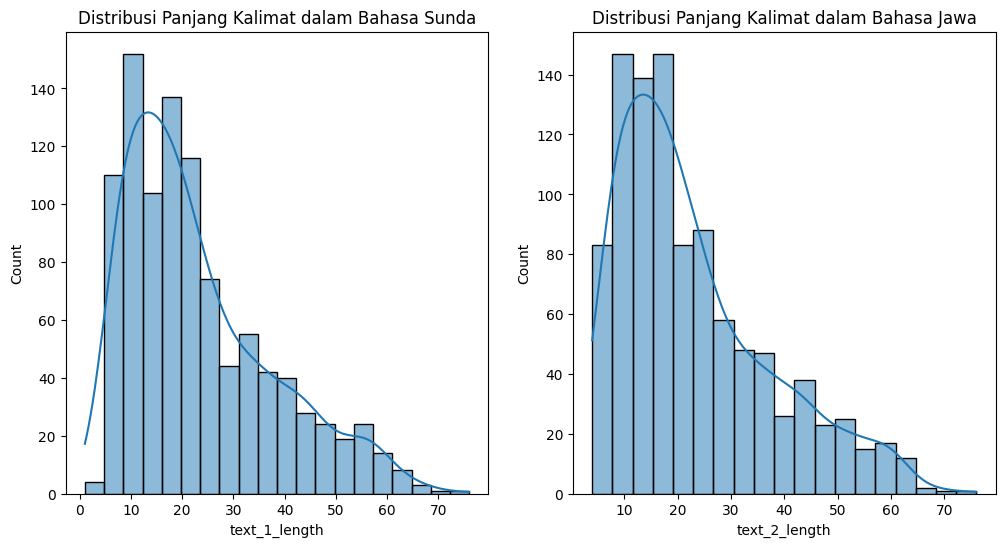

In [9]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sns.histplot(sun_jav_df['text_1_length'], kde=True)
plt.title('Distribusi Panjang Kalimat dalam Bahasa Sunda')

plt.subplot(1,2,2)
sns.histplot(sun_jav_df['text_2_length'], kde=True)
plt.title('Distribusi Panjang Kalimat dalam Bahasa Jawa')

plt.show()


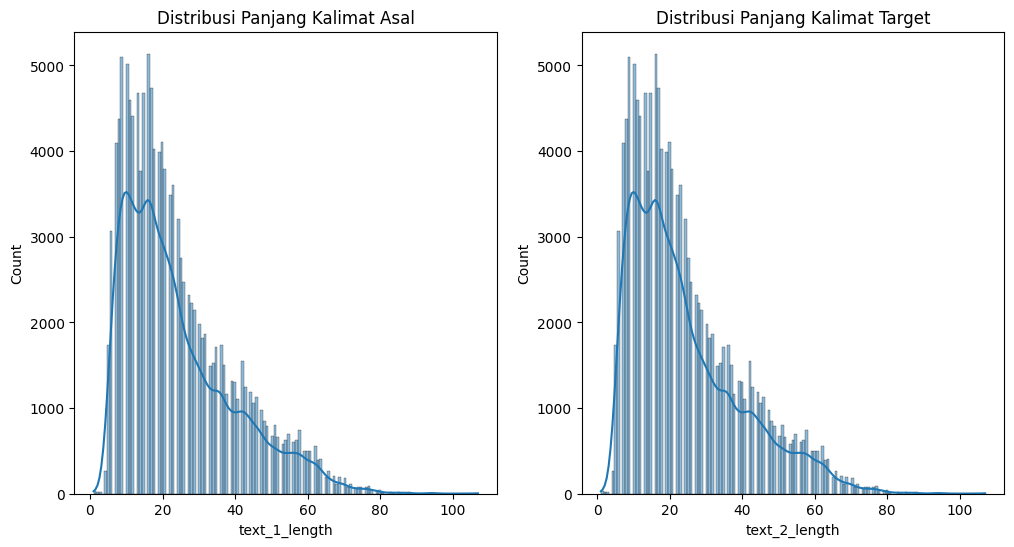

In [10]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sns.histplot(nusax_full_df['text_1_length'], kde=True)
plt.title('Distribusi Panjang Kalimat Asal')

plt.subplot(1,2,2)
sns.histplot(nusax_full_df['text_2_length'], kde=True)
plt.title('Distribusi Panjang Kalimat Target')

plt.show()


### Most Common Words

After that let see the most common words in each languaes using Counter From Collections Library. And After that we can also visualize it using Matplotlib and Seaborn

In [11]:
# kata kata paling umum
def get_most_common_words(series, n_most_common=10):
    counter = Counter()
    for sentence in series:
        counter.update(sentence.lower().split())
    return counter.most_common(n_most_common)

print("Kata-kata Paling Umum dalam Bahasa Sunda:")
print(get_most_common_words(sun_jav_df['text_1']))

print("\nKata-kata Paling Umum dalam Bahasa Jawa:")
print(get_most_common_words(sun_jav_df['text_2']))

Kata-kata Paling Umum dalam Bahasa Sunda:
[('nu', 615), ('sareng', 542), ('di', 457), ('teu', 375), ('abdi', 314), ('ka', 247), ('aya', 216), ('anu', 214), ('kanggo', 198), ('ku', 192)]

Kata-kata Paling Umum dalam Bahasa Jawa:
[('sing', 667), ('lan', 555), ('ora', 450), ('karo', 328), ('aku', 302), ('ing', 285), ('ning', 265), ('kanggo', 240), ('mangan', 219), ('iki', 205)]


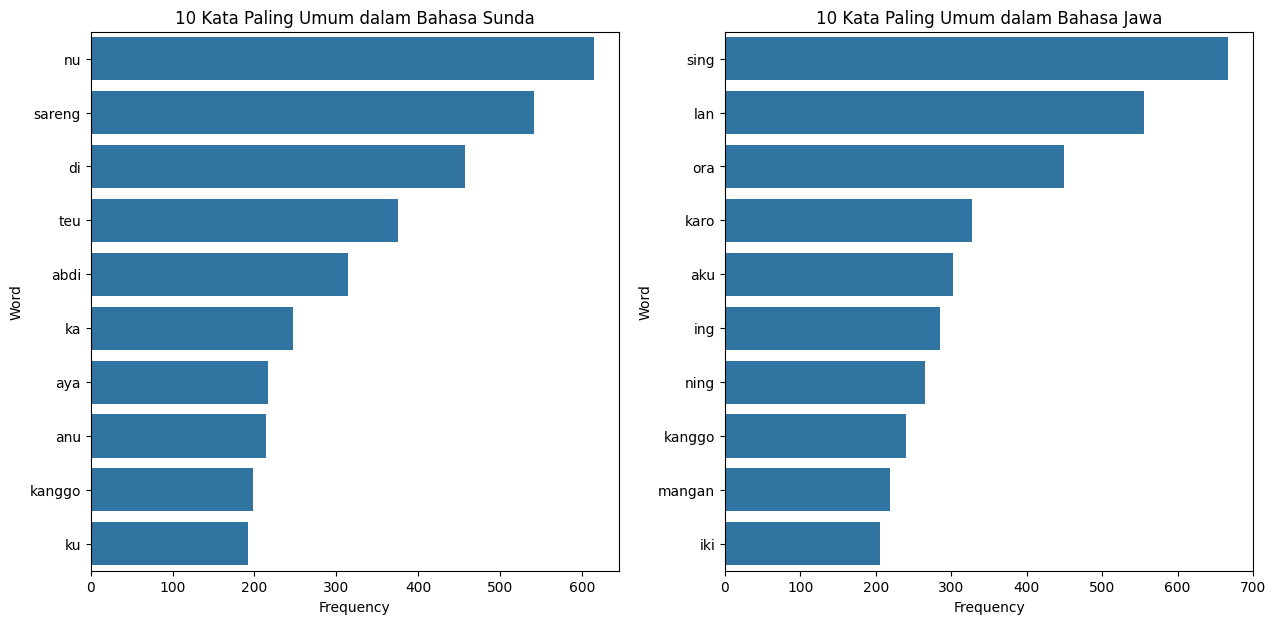

In [12]:
# Mendapatkan 10 kata teratas
top_sun_words = get_most_common_words(sun_jav_df['text_1'], 10)
top_eng_words = get_most_common_words(sun_jav_df['text_2'], 10)

# Membuat dataframe untuk visualisasi
df_vis_sun = pd.DataFrame(top_sun_words, columns=['Word', 'Frequency'])
df_vis_eng = pd.DataFrame(top_eng_words, columns=['Word', 'Frequency'])

# Visualisasi
plt.figure(figsize=(15, 7))
plt.subplot(1,2,1)
sns.barplot(x='Frequency', y='Word', data=df_vis_sun)
plt.title('10 Kata Paling Umum dalam Bahasa Sunda')

plt.subplot(1,2,2)
sns.barplot(x='Frequency', y='Word', data=df_vis_eng)
plt.title('10 Kata Paling Umum dalam Bahasa Jawa')

plt.show()

### N-Grams Analysis

We also can check the most common words using N-Grams function in this below code cell

In [13]:
def generate_ngrams(text, n):
    words = text.split()
    ngrams = zip(*[words[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

# Contoh untuk bigram dalam Bahasa Sunda
sun_bigrams = generate_ngrams(" ".join(sun_jav_df['text_1']), n=2)
display(Counter(sun_bigrams).most_common(10))

print('#'*20)

# Contoh untuk bigram dalam Bahasa Inggris
eng_bigrams = generate_ngrams(" ".join(sun_jav_df['text_2']), n=2)
display(Counter(eng_bigrams).most_common(10))

[('di dieu', 40),
 ('tuang di', 37),
 ('teu aya', 37),
 ('ka dieu', 27),
 ('sumping ka', 27),
 ('tempat ieu', 24),
 ('tuangeun nu', 24),
 ('teu tiasa', 24),
 ('di tempat', 23),
 ('di dieu.', 21)]

####################


[('ora ana', 34),
 ('enak lan', 30),
 ('mangan ning', 27),
 ('ora isa', 26),
 ('panganan sing', 24),
 ('ana ing', 24),
 ('lan ora', 21),
 ('ing kene', 20),
 ('sing apik', 20),
 ('sing ora', 20)]

In [14]:
# Contoh untuk trigram dalam Bahasa Sunda
sun_trigrams = generate_ngrams(" ".join(sun_jav_df['text_1']), n=3)
display(Counter(sun_bigrams).most_common(10))

print('#'*20)

# Contoh untuk trigram dalam Bahasa Inggris
eng_trigrams = generate_ngrams(" ".join(sun_jav_df['text_2']), n=3)
display(Counter(eng_bigrams).most_common(10))

[('di dieu', 40),
 ('tuang di', 37),
 ('teu aya', 37),
 ('ka dieu', 27),
 ('sumping ka', 27),
 ('tempat ieu', 24),
 ('tuangeun nu', 24),
 ('teu tiasa', 24),
 ('di tempat', 23),
 ('di dieu.', 21)]

####################


[('ora ana', 34),
 ('enak lan', 30),
 ('mangan ning', 27),
 ('ora isa', 26),
 ('panganan sing', 24),
 ('ana ing', 24),
 ('lan ora', 21),
 ('ing kene', 20),
 ('sing apik', 20),
 ('sing ora', 20)]

### WordClouds

We can also visualize the most common words in the datasets from each languages using WordClouds library.

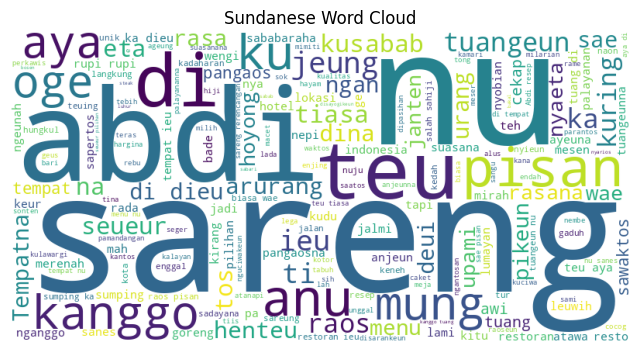

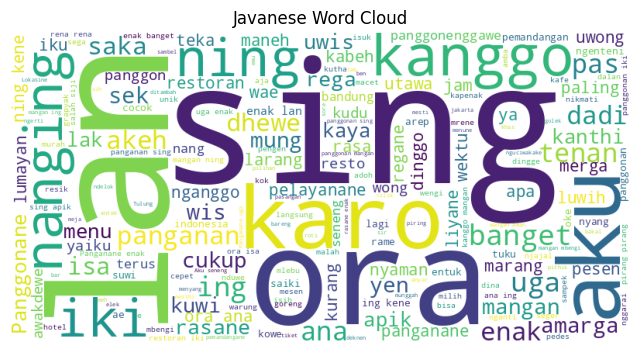

In [15]:
def plot_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(" ".join(text))
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()

plot_word_cloud(sun_jav_df['text_1'], 'Sundanese Word Cloud')
plot_word_cloud(sun_jav_df['text_2'], 'Javanese Word Cloud')


# Datasets Preprocessing

Here we gonna splits the convert our dataframes into HuggingFace Datasets, and after that we splits the datasets become 80% train, 10% test, 10% validation, and concate the datasets. After that we vectorize and tokenize the datasets using tokenizer from T5.

In [16]:
nusax_SunJav = DatasetHF.from_pandas(sun_jav_df)
nusax_JavSun = DatasetHF.from_pandas(jav_sun_df)

display(nusax_SunJav)
display(nusax_JavSun)

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length'],
    num_rows: 1000
})

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length'],
    num_rows: 1000
})

In [17]:
# Split the dataset into training, validation, and test sets
split_ratios = [0.8, 0.1, 0.1]  # 80% training, 10% validation, 10% test
split_names = ['train', 'validation', 'test']

splits_sunjav = nusax_SunJav.train_test_split(test_size=0.2)
train_dataset_sunjav, valid_test_dataset_sunjav = splits_sunjav['train'], splits_sunjav['test']

splits_sunjav = valid_test_dataset_sunjav.train_test_split(test_size=0.5)
valid_dataset_sunjav, test_dataset_sunjav = splits_sunjav['train'], splits_sunjav['test']

display(train_dataset_sunjav)
display(test_dataset_sunjav)
display(valid_dataset_sunjav)

splits_javsun = nusax_JavSun.train_test_split(test_size=0.2)
train_dataset_javsun, valid_test_dataset_javsun = splits_javsun['train'], splits_javsun['test']

splits_javsun = valid_test_dataset_javsun.train_test_split(test_size=0.5)
valid_dataset_javsun, test_dataset_javsun = splits_javsun['train'], splits_javsun['test']

display(train_dataset_javsun)
display(test_dataset_javsun)
display(valid_dataset_javsun)

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length'],
    num_rows: 800
})

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length'],
    num_rows: 100
})

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length'],
    num_rows: 100
})

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length'],
    num_rows: 800
})

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length'],
    num_rows: 100
})

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length'],
    num_rows: 100
})

In [18]:
from datasets import concatenate_datasets

train_dataset = concatenate_datasets([train_dataset_sunjav, train_dataset_javsun])
test_dataset = concatenate_datasets([test_dataset_sunjav, test_dataset_javsun])
valid_dataset = concatenate_datasets([valid_dataset_sunjav, valid_dataset_javsun])

In [35]:
train_dataset['text_1'][0]

'Teu nyesel oge tuang di solaria tempatna beresih tur cocog kanggo kulawargi oge. Tuangeun enggal kaluar saatos dipesen.'

In [40]:
train_dataset['text_1'][900]

'Uwis aku kirim pesen langsunge, tulung ndang dicek'

In [19]:
checkpoint = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(checkpoint)

source_lang = 'sun'
target_lang = 'jav'
prefix = "Translate Sundanese to Javanese: "

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


The preprocessing function you want to create needs to:

1. Prefix the input with a prompt so T5 knows this is a translation task. Some models capable of multiple NLP tasks require prompting for specific tasks.
2. Tokenize the input (Sundanese) and target (English) separately because you can't tokenize French text with a tokenizer pretrained on an English vocabulary.
3. Truncate sequences to be no longer than the maximum length set by the `max_length` parameter.

To apply the preprocessing function over the entire dataset, use 🤗 Datasets [map](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.map) method. You can speed up the `map` function by setting `batched=True` to process multiple elements of the dataset at once:

In [41]:
def preprocess_function(examples):
    prefix = ''
    if examples['text_1_lang'] == 'sun' :
      prefix = 'Translate Sundanese to Javanese: '
    elif examples['text_1_lang'] == 'jav':
      prefix = 'Translate Javanese to Sundanese: '

    inputs = [prefix + src for src in examples["text_1"]]
    targets = examples["text_2"]
    model_inputs = tokenizer(inputs, max_length=256, truncation=True, padding="max_length", return_tensors="pt")

    # Prepare decoder_input_ids
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=256, truncation=True, padding="max_length", return_tensors="pt")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


tokenized_nusax_train = train_dataset.map(preprocess_function, batched=True)
tokenized_nusax_test = test_dataset.map(preprocess_function, batched=True)
tokenized_nusax_valid = valid_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [23]:
display(tokenized_nusax_train)
display(tokenized_nusax_test)
display(tokenized_nusax_valid)

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1600
})

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 200
})

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 200
})

In [24]:
tokenized_nusax_train['input_ids'][:1]

[[2255,
  76,
  3,
  29,
  63,
  20736,
  3,
  32,
  397,
  3,
  17,
  76,
  1468,
  1227,
  3693,
  23,
  9,
  10301,
  144,
  29,
  9,
  36,
  60,
  7,
  23,
  107,
  3,
  2905,
  11530,
  122,
  3,
  157,
  1468,
  839,
  3,
  2729,
  4207,
  8240,
  23,
  3,
  32,
  397,
  5,
  2740,
  3280,
  202,
  3,
  4606,
  6191,
  3,
  4766,
  76,
  291,
  3,
  7,
  9,
  9,
  235,
  7,
  10823,
  15,
  7,
  35,
  5,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

In [25]:
tokenized_nusax_train['attention_mask'][:1]

[[1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


#### **Load Model**

We gonna use our T5 pretrained that was trained on Sundanese and Javanese subdataset from CC100, check our notebook to see the process

[Notebook](https://colab.research.google.com/drive/1wDmxYyLrwDi9SyHBl4zf65ekejCBtsbr?usp=sharing)

In [27]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model_path = "/content/drive/MyDrive/Models/T5-small-CC100-SU-JV-02"
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)

Now create a batch of examples using [DataCollatorForSeq2Seq](https://huggingface.co/docs/transformers/main/en/main_classes/data_collator#transformers.DataCollatorForSeq2Seq). It's more efficient to *dynamically pad* the sentences to the longest length in a batch during collation, instead of padding the whole dataset to the maximum length.

In [28]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [30]:
!pip install git+https://github.com/google-research/bleurt.git

  Cloning https://github.com/google-research/bleurt.git to /tmp/pip-req-build-wds6ucna
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/bleurt.git /tmp/pip-req-build-wds6ucna
  Resolved https://github.com/google-research/bleurt.git to commit cebe7e6f996b40910cfaa520a63db47807e3bf5c
  Preparing metadata (setup.py) ... done
  Created wheel for BLEURT: filename=BLEURT-0.0.2-py3-none-any.whl size=16456765 sha256=920db30127414e1f45088ddc71521f3b7ab8747253c03c651c2805c13f8eec3b
  Stored in directory: /tmp/pip-ephem-wheel-cache-mhquezc1/wheels/64/f4/2c/509a6c31b8ebde891a81029fd94f199b1b92f0e7cfc20d417a
Successfully built BLEURT


In [31]:
import evaluate

# Load metrics
sacrebleu_metric = evaluate.load("sacrebleu")
meteor_metric = evaluate.load("meteor")
bertscore_metric = evaluate.load("bertscore")
bluert_metrics = evaluate.load("bleurt", module_type="metric")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


compute metrics function for the metrics we gonna use Bleu, Meteor, Bleurt and BertScore to see the accuracy with various type metrics

- Bleu: Bilingual evaluation understudy (BLEU) is an automatic evaluation metric used to measure the similarity of the hypothesis to the reference. BLEU measures both adequacy by looking at word precision and fluency by calculating n-gram precision for n =1,2,3,4.
- Meteor: The metric for evaluation of translation with explicit ordering (METEOR) is a metric designed to address the limitations of BLEU, which is a commonly used evaluation metric for machine translation.  For instance, BLEU does not consider the stems and synonyms of words, meaning that it does not match “running” and “runs”, as they are not counted as the same word in the n-gram matching process. Additionally, BLEU does not use recall, which results in short sentences being penalized.
- Bleurt: BLEURT is a pre-trained model with a BERT structure using multi-task loss on synthetic data of a large number of references. It is a sentence-level metric that learns prediction scores that explain the similarity between the hypothesis and references.
- BertScores: BERTscore compares the hypothesis and reference statements of the translator using features extracted by BERT that is trained for the masked language model and next sentence prediction. BERTscore uses token embeddings of the pre-trained BERT.



In [66]:
# def postprocess_text(preds, labels):
#     preds = [pred.strip() for pred in preds]
#     labels = [[label.strip()] for label in labels]

#     return preds, labels

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    # Flatten the list of lists for labels into a list of strings
    # labels = [label.strip() for sublist in labels for label in sublist]
    labels = [label.strip() for label in labels]
    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    print(f"Decoded preds: {len(decoded_preds)}, Decoded labels: {len(decoded_labels)}")

    # Check if the number of predictions and references match
    if len(decoded_preds) != len(decoded_labels):
        raise ValueError(f"Number of predictions ({len(decoded_preds)}) does not match number of references ({len(decoded_labels)})")

    # Initialize result dictionary
    result = {}

    # Compute sacreBLEU
    bleu_result = sacrebleu_metric.compute(predictions=decoded_preds, references=decoded_labels)
    result["bleu"] = bleu_result["score"]

    # Compute METEOR
    meteor_result = meteor_metric.compute(predictions=decoded_preds, references=decoded_labels)
    result["meteor"] = meteor_result["meteor"]

    # Compute BLEURT
    # bleurt_result = bluert_metrics.compute(predictions=decoded_preds, references=decoded_labels)
    # result["Bleurt"] = [round(score, 4) for score in bleurt_result['scores']]

    # Compute BLEURT
    bleurt_result = bluert_metrics.compute(predictions=decoded_preds, references=decoded_labels)
    # Choose a specific value to log (e.g., mean or median)
    result["Bleurt"] = round(np.mean(bleurt_result['scores']), 4)


    # Compute BERTScore
    bertscore_result = bertscore_metric.compute(predictions=decoded_preds, references=decoded_labels, lang="id")
    result["bertscore_precision"] = np.mean(bertscore_result["precision"])
    result["bertscore_recall"] = np.mean(bertscore_result["recall"])
    result["bertscore_f1"] = np.mean(bertscore_result["f1"])

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    # result = {k: round(v, 4) for k, v in result.items()}

    # Round specific metrics
    result["bleu"] = round(result["bleu"], 4)
    result["meteor"] = round(result["meteor"], 4)
    result["bertscore_precision"] = round(result["bertscore_precision"], 4)
    result["bertscore_recall"] = round(result["bertscore_recall"], 4)
    result["bertscore_f1"] = round(result["bertscore_f1"], 4)
    result["gen_len"] = round(result["gen_len"], 4)

    return result


training arguments

In [67]:
training_args = Seq2SeqTrainingArguments(
    output_dir="T5_NusaX_Sun_Jav_checkpoints",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=5,
    num_train_epochs=200,
    predict_with_generate=True,
    fp16=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_nusax_train,
    eval_dataset=tokenized_nusax_valid,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Bleu,Meteor,Bleurt,Bertscore Precision,Bertscore Recall,Bertscore F1,Gen Len
1,No log,0.825005,0.358700,0.085100,-0.807700,0.720800,0.657800,0.687300,18.945000
2,No log,0.813595,0.357400,0.085100,-0.801600,0.721900,0.658800,0.688400,18.940000
3,No log,0.804922,0.353100,0.085500,-0.801300,0.720900,0.658000,0.687500,18.940000
4,No log,0.797350,0.352400,0.085500,-0.799400,0.720600,0.657600,0.687100,18.930000
5,0.903200,0.789801,0.351300,0.084500,-0.796100,0.719600,0.656800,0.686300,18.930000
6,0.903200,0.783707,0.357500,0.086300,-0.797500,0.719900,0.657000,0.686500,18.930000
7,0.903200,0.777173,0.355600,0.087900,-0.795400,0.719300,0.657100,0.686300,18.945000
8,0.903200,0.770778,0.356300,0.087000,-0.797300,0.719600,0.657500,0.686600,18.955000
9,0.903200,0.765045,0.348200,0.086300,-0.800600,0.717800,0.656300,0.685200,18.955000
10,0.875700,0.759770,0.348700,0.086200,-0.804900,0.718200,0.655700,0.685000,18.955000


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200
Decoded preds: 200, Decoded labels: 200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 200, Decoded labels: 200


TrainOutput(global_step=20000, training_loss=0.6376295516967774, metrics={'train_runtime': 8587.4913, 'train_samples_per_second': 37.264, 'train_steps_per_second': 2.329, 'total_flos': 2.165468823552e+16, 'train_loss': 0.6376295516967774, 'epoch': 200.0})

Save the model to drive, or you aslo can push the model to HuggingFace if you want.

In [68]:
model_name = "/content/drive/MyDrive/Models/T5-small-CC100&NusaX-SU-JV-03"
trainer.save_model(model_name)

# Predict Evaluate

### Inference

Great, now that you've finetuned a model, you can use it for inference!

Come up with some text you'd like to translate to another language. For T5, you need to prefix your input depending on the task you're working on. For translation from English to French, you should prefix your input as shown below:

In [69]:
from transformers import pipeline

source = "Translate Sundanese to Javanese: Nikmati angsuran 0% dugi ka 12 bulan kanggo mesen tiket pasawat air asia nganggo kartu kiridit BNI!"
# label = "If you have further questions you'd like to ask, or have issues regarding Traveloka's products, be sure to contact us again."

translator = pipeline("translation", model=model_name)
translator(source)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/__init__.py:1049: UserWarning: "translation" task was used, instead of "translation_XX_to_YY", defaulting to "translation_en_to_de"
  warnings.warn(


[{'translation_text': 'Übersetzen Sundanese in Javane: Nikmati angsuran 0% ka 12 bulan kanggo mesen tiket pasawat air asia nganggo kartu kiridit BNI!'}]

In [70]:
source = "Translate Javanese to Sundanese: Nikmatono cicilan 0% sampek 12 sasi dinggo pesen tiket kapal air asia nganggo kertu kredit bni!"
# label = "If you have further questions you'd like to ask, or have issues regarding Traveloka's products, be sure to contact us again."

translator = pipeline("translation", model=model_name)
translator(source)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[{'translation_text': 'Übersetzen Sie Javane in Sundanese: Nikmatonan 0% sampek 12 sasi dinggo pesen tiket kapal air asia nganggo kertu kredit bni!'}]

- Bleu: Bilingual evaluation understudy (BLEU) is an automatic evaluation metric used to measure the similarity of the hypothesis to the reference. BLEU measures both adequacy by looking at word precision and fluency by calculating n-gram precision for n =1,2,3,4.
- Meteor: The metric for evaluation of translation with explicit ordering (METEOR) is a metric designed to address the limitations of BLEU, which is a commonly used evaluation metric for machine translation.  For instance, BLEU does not consider the stems and synonyms of words, meaning that it does not match “running” and “runs”, as they are not counted as the same word in the n-gram matching process. Additionally, BLEU does not use recall, which results in short sentences being penalized.
- Bleurt: BLEURT is a pre-trained model with a BERT structure using multi-task loss on synthetic data of a large number of references. It is a sentence-level metric that learns prediction scores that explain the similarity between the hypothesis and references.
- BertScores: BERTscore compares the hypothesis and reference statements of the translator using features extracted by BERT that is trained for the masked language model and next sentence prediction. BERTscore uses token embeddings of the pre-trained BERT.

In [83]:

def predict_evaluate(data):
    try:
        prefix = ''
        sources = data['text_1']
        targets = data['text_2']

        if data['text_1_lang'] == 'sun' :
          prefix = 'Translate Sundanese to Javanese: '
        elif data['text_1_lang'] == 'jav':
          prefix = 'Translate Javanese to Sundanese: '

        predictions = [translator(prefix + source)[0]['translation_text'] for source in sources]

        # Initialize lists to store results
        predicts, accuracies, bleus, meteors, bleurts, bertscore_precisions, bertscore_recalls, bertscore_f1s = [], [], [], [], [], [], [], []

        for prediction, target in zip(predictions, targets):
            predicts.append(prediction)

            # Calculate accuracy for each prediction
            accuracies.append(int(prediction == target))

            # Compute sacreBLEU
            bleu_result = sacrebleu_metric.compute(predictions=[prediction], references=[target])
            bleus.append(bleu_result["score"])

            # Compute METEOR
            meteor_result = meteor_metric.compute(predictions=[prediction], references=[target])
            meteors.append(meteor_result["meteor"])

            # Compute Bleurt
            bleurt_result = bluert_metrics.compute(predictions=[prediction], references=[target])
            bleurts.append(bleurt_result['scores'])

            # Compute BERTScore
            bertscore_result = bertscore_metric.compute(predictions=[prediction], references=[target], lang="id")
            bertscore_precisions.append(bertscore_result["precision"])
            bertscore_recalls.append(bertscore_result["recall"])
            bertscore_f1s.append(bertscore_result["f1"])

        # Return a dictionary with lists as values
        return {
            "input": data['text_1'],
            "predict": predicts,
            "target": targets,
            # "accuracy": accuracies,  # Now a list of accuracies
            "bleu": bleus,
            "meteor": meteors,
            "bleurt": bleurts,
            "bertscore_precision": bertscore_precisions,
            "bertscore_recall": bertscore_recalls,
            "bertscore_f1": bertscore_f1s
        }

    except Exception as e:
        print(f"Error during prediction or evaluation: {e}")
        return None

# Assuming test_dataset is correctly defined
data_test_predict_eval = test_dataset.map(predict_evaluate, batched=True)



Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Your input_length: 280 is bigger than 0.9 * max_length: 300. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


In [84]:
predict_eval_df = data_test_predict_eval.to_pandas()

display(predict_eval_df.drop(
    [
        'text_1', 'text_2',
        'text_1_lang', 'text_2_lang',
        'text_1_length', 'text_2_length',
    ],
    axis=1)
)

,id,input,predict,target,bleu,meteor,bleurt,bertscore_precision,bertscore_recall,bertscore_f1
0,330,Karya bakti bca finance posisi relationship of...,Karya bakti bca finance posisi relationship of...,Karya bakti bca finance posisi relationship of...,54.910049,0.736111,[0.39940303564071655],[0.8832608461380005],[0.8677693605422974],[0.8754465579986572]
1,204,Ku meser morinaga chil kid sareng chil school ...,Ku meser morinaga chil kid lan chil school sah...,Kanthi tuku morinaga chil kid lan chil school ...,58.150254,0.748264,[0.05238611623644829],[0.9016667604446411],[0.8972935080528259],[0.8994748592376709]
2,391,Punten perhatosanna admin. Jaringan di cileung...,Pangan perhatosane admin. Jaringan ning cileun...,Tulung perhatiane admin. Jaringan ning cileung...,46.892439,0.680527,[0.08063302934169769],[0.8890392780303955],[0.9060338139533997],[0.897456169128418]
3,200,Tuangeun india numutkeun abdi teu raos. Seueur...,Panganan indi aku ora enak. Ora ora rempah,Panganan india miturut ku ora enak. Kakehan bu...,19.070828,0.350694,[-0.3789321482181549],[0.7342050075531006],[0.7337422370910645],[0.733973503112793]
4,462,Tagihan internet abdi teu lebet kanu akal 250%...,Tagihan internet aku ora akal 250% leuwih saka...,Tagihan internetku ora mlebu akal 250% luwih l...,15.057703,0.505283,[0.1816372126340866],[0.9019162654876709],[0.8675310611724854],[0.8843895792961121]
...,...,...,...,...,...,...,...,...,...,...
195,252,Aku wis ndaftar namung ora entuk sms seka 5111.,Abdi ndaftar teu tiasa sms seka 5111.,Abdi tos registrasi mung teu acan nampi sms ti...,9.545139,0.347664,[-0.018434587866067886],[0.8419338464736938],[0.8087822198867798],[0.8250251412391663]
196,73,Adikku lagi ndhelok harry potter ing trans tv,Adikku kusabab harry potter di trans tv,Rai abdi nuju nongton harry potter di trans tv,46.199934,0.565909,[-0.12095622718334198],[0.8309070467948914],[0.8146182298660278],[0.8226820230484009]
197,352,"Panggon parkir kesempiten, sampek mobil kudu d...","Tempat parkir kesempiten, sampek mobil kudu di...","Tempat parkir sempit teuing, nika mobil kudu d...",28.897738,0.646144,[0.1440880000591278],[0.8676532506942749],[0.867392897605896],[0.8675230741500854]
198,153,Timbangane rame-rame soal barang flash sale me...,Timbangane rame-rame soal barang flash sale me...,Tibatan raribut ngeunaan barang flash sale leu...,21.423489,0.494865,[-0.1961246132850647],[0.7655574083328247],[0.789755642414093],[0.7774682641029358]


In [88]:
display(predict_eval_df[:1]['predict'])
display(predict_eval_df[:1]['target'])

0    Karya bakti bca finance posisi relationship of...
Name: predict, dtype: object

0    Karya bakti bca finance posisi relationship of...
Name: target, dtype: object

In [89]:
display(predict_eval_df['bleu'].mean())
display(predict_eval_df['meteor'].mean())
display(predict_eval_df['bleurt'].mean())

15.334266604564634

0.3900363024364832

array([-0.13708009])

In [95]:
display(predict_eval_df.drop(
    [
        'text_1', 'text_2',
        'text_1_lang', 'text_2_lang',
        'text_1_length', 'text_2_length',
        # 'input',
        # 'bleu',
        # 'meteor',
        # 'bleurt',
        'bertscore_precision',
        'bertscore_recall',
        'bertscore_f1'
    ],
    axis=1)
)

,id,input,predict,target,bleu,meteor,bleurt
0,330,Karya bakti bca finance posisi relationship of...,Karya bakti bca finance posisi relationship of...,Karya bakti bca finance posisi relationship of...,54.910049,0.736111,[0.39940303564071655]
1,204,Ku meser morinaga chil kid sareng chil school ...,Ku meser morinaga chil kid lan chil school sah...,Kanthi tuku morinaga chil kid lan chil school ...,58.150254,0.748264,[0.05238611623644829]
2,391,Punten perhatosanna admin. Jaringan di cileung...,Pangan perhatosane admin. Jaringan ning cileun...,Tulung perhatiane admin. Jaringan ning cileung...,46.892439,0.680527,[0.08063302934169769]
3,200,Tuangeun india numutkeun abdi teu raos. Seueur...,Panganan indi aku ora enak. Ora ora rempah,Panganan india miturut ku ora enak. Kakehan bu...,19.070828,0.350694,[-0.3789321482181549]
4,462,Tagihan internet abdi teu lebet kanu akal 250%...,Tagihan internet aku ora akal 250% leuwih saka...,Tagihan internetku ora mlebu akal 250% luwih l...,15.057703,0.505283,[0.1816372126340866]
...,...,...,...,...,...,...,...
195,252,Aku wis ndaftar namung ora entuk sms seka 5111.,Abdi ndaftar teu tiasa sms seka 5111.,Abdi tos registrasi mung teu acan nampi sms ti...,9.545139,0.347664,[-0.018434587866067886]
196,73,Adikku lagi ndhelok harry potter ing trans tv,Adikku kusabab harry potter di trans tv,Rai abdi nuju nongton harry potter di trans tv,46.199934,0.565909,[-0.12095622718334198]
197,352,"Panggon parkir kesempiten, sampek mobil kudu d...","Tempat parkir kesempiten, sampek mobil kudu di...","Tempat parkir sempit teuing, nika mobil kudu d...",28.897738,0.646144,[0.1440880000591278]
198,153,Timbangane rame-rame soal barang flash sale me...,Timbangane rame-rame soal barang flash sale me...,Tibatan raribut ngeunaan barang flash sale leu...,21.423489,0.494865,[-0.1961246132850647]


In [96]:
predict_eval_dict = [{"index":0,"id":"330","input":"Karya bakti bca finance posisi relationship officer muka lowongan kanggo panempatan Pekanbaru","predict":"Karya bakti bca finance posisi relationship officer muka lowongan kanggo kusabab pekanbaru","target":"Karya bakti bca finance posisi relationship officer mbukak lowongan dingge manggon pekanbaru","bleu":"54.91004867761124","meteor":"0.7361111111111112","bleurt":"[0.39940304]"},{"index":1,"id":"204","input":"Ku meser morinaga chil kid sareng chil school saharga rp 500. 000, bunda bakal nampi voucher gopay rp 50. 000. ","predict":"Ku meser morinaga chil kid lan chil school saharga rp 500. 000, bunda bakal nampi voucher gopay rp 50. 000.","target":"Kanthi tuku morinaga chil kid lan chil school rega rp 500. 000, ibu isa entuk voucher gopay rp 50. 000.","bleu":"58.15025407036991","meteor":"0.748263888888889","bleurt":"[0.05238612]"},{"index":2,"id":"391","input":"Punten perhatosanna admin. Jaringan di cileungsi bogor awon pisan kualitasna. Padahal mayarna awis.","predict":"Pangan perhatosane admin. Jaringan ning cileungsi bogor awis banget kualitase. Padahal mayarna awis.","target":"Tulung perhatiane admin. Jaringan ning cileungsi bogor elek banget kualitase. Padahal bayare larang.","bleu":"46.892438882117254","meteor":"0.6805268595041322","bleurt":"[0.08063303]"},{"index":3,"id":"200","input":"Tuangeun india numutkeun abdi teu raos. Seueur teuing rempah","predict":"Panganan indi aku ora enak. Ora ora rempah","target":"Panganan india miturut ku ora enak. Kakehan bumbon","bleu":"19.070828081828378","meteor":"0.3506944444444444","bleurt":"[-0.37893215]"},{"index":4,"id":"462","input":"Tagihan internet abdi teu lebet kanu akal 250% leuwih awis kakak! Peryogi penjelasan.","predict":"Tagihan internet aku ora akal 250% leuwih saka! Peryogi penjelasan.","target":"Tagihan internetku ora mlebu akal 250% luwih larang kang! Njaluk penjelasan.","bleu":"15.05770286076146","meteor":"0.505283273381295","bleurt":"[0.18163721]"},{"index":5,"id":"122","input":"baheula resep pisan tuang di dieu dina sami waktosna di Jakarta, nembe terang yen aya oge di Bandung. Tempatna sae pisan. Aya seueur pilihan suasana anu tiasa dipilih, naha di luar, di jero rohangan, ngaroko atanapi henteu, aya tempat pikeun sadaya jinis tamu. Dahareunana oge raos. Siga pasta-pasta ala urang Indonesia.","predict":"Aku seneng banget mangan ning kene ning karo wektu, nembe terang ana uga ning bandung. Panggonane apik banget. Aya seueur pilihan suwasane sing isa dipilih, nanging jero rohangan, nggawe akeh, ana panggonane sadaya jinis tamu. Dahareunane uga enak. Siga pasta-pasta enak.","target":"Biyen aku seneng banget mangan ning kene wektu podo ning jakarta, lagek eruh lak ning bandung uga ana. Panggone enak banget. Akeh pilihan kahanan sing isa dipilih, sir ning jaba, jero, ngrokok utawa ngge ora, ana panggon dinggo kabeh jenis wong moro. Panganane uga enak seh. Ya pasta-pasta ala wong indonesia.","bleu":"13.997172942497256","meteor":"0.4161971820190063","bleurt":"[-0.17970386]"},{"index":6,"id":"97","input":"Abdi teu kuciwa ka produk apple","predict":"Aku ora kuciwa ka produk apple","target":"Aku ora kuciwa karo produke apple","bleu":"32.46679154750991","meteor":"0.8066666666666668","bleurt":"[0.60135025]"},{"index":7,"id":"2","input":"Kangkungna lumayan mung kepiting saos padangna nguciwakeun arurang dipasihan kepiting anu kopong ahirna arurang teu tuang kepitingna sareng dibalikkeun.","predict":"Kanggonane lumayan nanging nguciwakeun awakdewe dipasihan awakdewe ora mangan awakdewe lan dibalikkeun.","target":"Kangkunge lumayan nanging yuyu saus padange nguciwakake dhewe dikei yuyu sing kopong akhir dhewe ora mangan yuyune lan dibalekake.","bleu":"5.643423197451416","meteor":"0.26482440990213013","bleurt":"[-0.15498953]"},{"index":8,"id":"493","input":"Parah pisan kuring mesen di bukalapak nganggo gosend kamari nepi ayeuna teu acan sumping kumaha ieu. Barangna peryogi pisan","predict":"Abdi mesen ning bukalapak nganggo gosend nyaeta ora acan kumaha iki. Panganane peryogi banget","target":"Nemen pesen bukalapak nanggo gosend dekwingi sampek saiki durung teka piye iki. Butuh barange banget","bleu":"6.1827411661290235","meteor":"0.23396226415094337","bleurt":"[-0.15670584]"},{"index":9,"id":"174","input":"Mimiti ka dieu eta ngarayakeun kalulusan rai abdi, tempatna eta loh, keren pisan. Disainna oge unik, keren, merenah, merenah, cocog pisan kanggo tuang wengi sareng kulawargi, pasangan, dulur, sareng rerencangan, pamandanganna oge keren, tuangeunna oge raos-raos. Pangaos saluyu sareng palayananna, teu nyesel ka dieu. Disarankeun pisan.","predict":"Mimiti ning kene kulawargi kuwi, panggonane kuwi, keren tenan. Disaine uga unik, tenan, tenan, cocok tenan kanggo mangan wengi lan kulawargi, pasangan, dulur, lan kanca, panganane uga tenan, panganane uga enak-enak. Disaranke ning kene.","target":"Kapisan marang mrene kuwi ngerayakake kelulusan adikku, panggonane kuwi loh, apik tenan. Desaine uga unik, apik, kapenak, kapenak, cocok tenan kanggo mangan mbengi bareng kaluwarga, pasangan, sedulur, lan kanca-kanca, pemandangane uga apik, panganane uga enak-enak. Regane sebanding karo pelayanane, ora gela marang mrene. Bener-bener direkomendasikake.","bleu":"18.554984102985628","meteor":"0.3486780678163579","bleurt":"[-0.20813209]"},{"index":10,"id":"57","input":"Rumah makan ieu tangtua kagolong mirah mung dibandikeun kanu rumah makan nu sanesna. Mun tuangeun nu disayogikeun biasa wae teu aya nu istimewa. Seseurna mah tuangeunna ngan lauk atawa hayam nu cara masak digoreng. Tiasa disebat menu tuangeunna teu aya rupi-rupi sama sekali.","predict":"Kanggonan iki tangtua kagolong nanging dibandikeun nanging rumah nanging enak. Nanging panganan sing disayogikeun biasa nanging ora ana sing istimewa. Seseure panganane nanging akeh nanging cara masak digoreng. Isa disebat menu panganane ora ana enak sama sekali.","target":"Omah mangan iki mesthu kagolong murah yen dibandingake karo omah mangan sakjenise. Nanging panganan sing disediakake biasa wae ora ana sing istimewa. Akeh-akehe panganan mung iwak utawa oithik kanthi cara masak digoreng. Bisa diomong menu panganane ora ana variasine blas.","bleu":"24.78238686631454","meteor":"0.4625829755848479","bleurt":"[-0.13292158]"},{"index":11,"id":"127","input":"Dina restoran eta aya seeur pilihan tuangeun, mimiti ti nu mirah nepi nu awis","predict":"Aku restoran ana pilihan panganan, mimiti sing mirah nepi sing awis","target":"Ing restoran kuwi kasadia akeh pilian panganan, mulai saka sing murah nganti sing larang","bleu":"6.632729312157198","meteor":"0.25306122448979596","bleurt":"[-0.14577435]"},{"index":12,"id":"142","input":"Kue patepang taun spesial nganggo endog sapiring ditambihan mozzarella kanggo anjeun","predict":"Kue patepang taun spesial nganggo endog sapiring ditambihan mozzarella kanggo ajeun","target":"Roti ulang tahune spesial nganggo ndhog sakpiring ditambah mozzarella kanggo kowe","bleu":"10.600313379512592","meteor":"0.34090909090909094","bleurt":"[-0.0176141]"},{"index":13,"id":"29","input":"Tuangen di dieu raos-raos ku seueur rupi-rupi. Sadayana raos ku pamandangan sae. Palayanan nu maksimal ti mbak diah sareng gina ti mimiti sumping nepi rengse dilayanan ku sae pisan.","predict":"Panggonane enak-enak. Panganane enak enak karo pamandangane apik. Panganane sing maksimal saka mbak diah lan gina saka mimiti sumping ngse dilayanane saka enak banget.","target":"Panganan ing kene enak-enak kanthi akeh variasine. Kabehane enak kanthi pemandangan apik. Pelayanane sing maksimal saka mbak diah lan gina saka ngewiwiti teka nganti rampung, dilayani kanthi apik tenan.","bleu":"23.930559017896012","meteor":"0.37167352537722914","bleurt":"[-0.1293731]"},{"index":14,"id":"244","input":"Kafe ieu, ngagaduhan cemilan anu pang hadena, tahu ti lumboenk sareng volkano risols namina. Sensasi unik tina panampilan anu sami ngajantenkeun hoyong deui hoyong deui, pikeun anu panasaran tiasa dicobian deh.","predict":"Kafe iki, ngagaduhan cemilan sing hadena, tahu ora lumboenk lan volkano risols namine. Sensasi unik sing panggonan sing ngajantenke sing nyaeta nyaeta nyaeta nyaeta nyaeta dicobian nyaeta.","target":"Kafe iki, nduwe pirang-pirang cemilan sing top banget, tahu ning lumboenk karo vulkano risols jenenge. Sensasine unik saka wujude karo rasane nggarai sir maneh si maneh, dinggo sing penasaran oleh njajal wis.","bleu":"6.312139612101272","meteor":"0.21669159243123737","bleurt":"[-0.20141259]"},{"index":15,"id":"306","input":"Saleresna nya sapertosna abdi teu ditakdirkeun nikmatan indomie goreng, padahal ngan ngulub miena lho. Tiasa-tiasana leuleus teuing.","predict":"Aku aku ora ditakdirke nikmatan indomie goreng, padahal nanging ngulub miene lho. Teu-etiasane luwih.","target":"Mesthi ya kayane aku ora ditakdirake nikmati indomie goreng, sanadyan mung nggodhok mine lho. Isa-isane kaliwat lembek.","bleu":"10.844080760155272","meteor":"0.38071065989847713","bleurt":"[-0.27489597]"},{"index":16,"id":"463","input":"Kuciwa pisan. Pesen sareng mayar tiket pesawat dienggalkeun tabuh satengah 1 enjing kanggo penerbangan jam 6 enjing. E - tiket henteu dikirim. Ngadadak dihubungi liwat email upami tiket nu tos dibayar tos seep dina waktos-waktos enjing. Mung tiketna seep naha keneh bisa dibooking.","predict":"Kuciwa banget. Pesen lan mayar tiket pesawat satengah 1 enjing kanggo penerbangan jam 6 enjing. E - tiket enjing dikirim. Ngadadak dihubungi liwat email nanging tiket nanging dibayar nanging waktos-waktos enjing. Nanging tikete akeh bisa dibooking.","target":"Kuciwa banget. Pesen lan mbayar tiket motor mabur dilaksanakake jam setengah 1 isuk kanggo penerbangan jam6 isuk. E - tiket ora dikirim. Dumadakan dihubungi via email yen tiket sing uwis dibayar uwis entek jam-jam isuk. Yen tikete entek ngapa egek isa dipesen.","bleu":"16.33191451918006","meteor":"0.43979369011146585","bleurt":"[-0.1022194]"},{"index":17,"id":"68","input":"Hese ngartos jalma anu ngarasa osok bener","predict":"Hese ngartos jalma sing ngarasa osok bener","target":"Angel banget ngerteni wong sing terus rumangsa pener","bleu":"5.693025330278465","meteor":"0.06329113924050632","bleurt":"[-0.32003397]"},{"index":18,"id":"231","input":"Satuju beuki naek fase wajar upami tiket naek. Mung, pangaos dasar sawaktos fase panyisihan tos kaawisan. Cobi bandingkeun pangaos lalajo di malaysia, thailand.","predict":"Aku nyaeta fase wajar nanging tiket nyaeta. Ngan, regane nyaeta fase nyisihan tiasa. Cobi bandingke regane ning malaysia, thailand.","target":"Setuju saya munggah fase wajar yen tiket munggah. Nanging, rega dasar ing pas fase penyisihan uwis kelarangan. Coba bandingake rega nonton ing malaysia, thailand.","bleu":"11.066171274883231","meteor":"0.35867446393762187","bleurt":"[-0.1297721]"},{"index":19,"id":"198","input":"Sumping ka restoran ieu teu aya bosenna, komo dina dinten wengi arurang sakulawargi resep pisan tempat ieu kumargi aya live musikna. Suasanana teu gentos ti tahun ka tahun. Menu nu disayogikeun ge keneh teteup sami, ti mimiti menu eropa nepi menu khas indonesia keneh memikat. Porsina ge teu eleuh seueur.","predict":"Panggonane iki ora ana bosene, komo ing dina wengi seneng banget panggonane iki kumargi ana live musike. Suwasanane ora gentos ing tahun ing tahun. Menu sing disayogikeun karo teteup sami, ora mimiti menu eropa nepi menu khas indonesia keneh memikat. Porsine uga ora enak.","target":"Teko marang restoran iki ora ana bosene, apa maneh ini mbengi minggu dhewe sakaluwarga seneng tenan panggonan iki amarga ana live musike. Suwasanane ora owah nahunan. Menu sing disajikake egek tetep padha, saka mulai menu eropa nganti menu khas indonesia tetep nyengsemake. Porsine uga ora kalah akeh.","bleu":"25.624487697618193","meteor":"0.5047220501103666","bleurt":"[-0.18800953]"},{"index":20,"id":"152","input":"Hayang ka hotel nu di mongkok Hongkong, teu aya! Sasih Juni kamari, kuring pesen sareng parantos mayar 2 kamar. Tapi hotelna teu kapanggih.","predict":"Aku hotel sing ning mongkok Hongkong, ora ana! Sasih Juni kamari, kuring pesen lan pesen mayar 2 kamar. Tapi hotelne ora kapanggih.","target":"Arep nyang hotel ning mongkok hongkong, ora ana! Sasi juni wingi, aku mesen lan wis mbayar dingge 2 kamar. Nanging hotele ora temu","bleu":"15.35259783865636","meteor":"0.5398582175925926","bleurt":"[-0.15853569]"},{"index":21,"id":"442","input":"Lungse dina perjalanan nu lumayan tebih ti kota kabayar ku suasana tur raosna tuangeun, disampurnakeun ku palayanan nu someah tur enggal ti pramusaji. Tong hilap milih desert buah stroberi seger dihidangkeun sareng susu coklat, anjeun bakal katagihan.","predict":"Lungse ing perjalanan sing lumayan ora kota kabayar ing suwasanane enak panganan, disampurnake ing palayanan sing akeh saka pramusaji. Anu hilap milih desert buah stroberi seger dihidangke lan susu coklat, ora bakal katagihan.","target":"Kesel ning perjalanan sing lumayan adoh saka kutha kebayar karo suwasanan lan lezate panganan, disempurnakne karo pelayanan sing grapyak lan cepet saka pramusaji. Aja lali milih desert buah stroberi seger dihidangne karo susu coklat, sampeyan bakale ketagihan.","bleu":"17.90063064905218","meteor":"0.4893155948750601","bleurt":"[-0.20106214]"},{"index":22,"id":"385","input":"Kahiji cobi kusabab ulasan sababaraha jalmi mung nyatana rasana biasa wae. Sapiring 30 rebu. Hese milarian tempat diuk.","predict":"Kahiji cobi kusabab sababaraha jalmi nanging nyatane rasane biasa wae. Sapiring 30 rebu. Hese nyatan panggonan nyaeta.","target":"Kapisan njajal amarga ulasan pirang-pirang uwong nanging jebule rasane biasa wae. Sakpiring 30 ewu. Engel nggolek panggonan njagong.","bleu":"13.963923473554178","meteor":"0.3668261562998405","bleurt":"[-0.34912071]"},{"index":23,"id":"194","input":"Nganggo laurier double nalika bade bobo sawaktos haid supados henteu bocor","predict":"Nganggo laurier double nalika bade bobo supados ora bocor","target":"Ngganggo laurier dobel pas arep turu pas menstruasi ben ora bocor","bleu":"8.449917822620138","meteor":"0.23662551440329216","bleurt":"[-0.241281]"},{"index":24,"id":"345","input":"Ti wengi teh teu tiasa dianggo, layanan indosat naha siga kieu. Daftar extra 2 gb 10 rebu teu kenging-kenging, sia-sia pulsa abdi kalahka seep teu dianggo nanaon.","predict":"Wengi ora isa dianggo, layanan indosat nyaeta nyaeta. Daftar extra 2 gb 10 rebu ora kenging-kenging, sia-sia pulsa aku ora dianggo banget.","target":"Saka mambengi kok ora iso dienggo, layanan indosat kok kaya ngene. Ndaftar extra 2 gb 10 ewu ora isa-isa, eman-eman pulsaku malah entek ora isa dienggo apa-apa.","bleu":"13.431324971537853","meteor":"0.3980428236868518","bleurt":"[-0.16759208]"},{"index":25,"id":"55","input":"Restoran seafood. Menu spesialna keyeup nu diemam sareng kulitna. Kanggo abdi kirang raos. Kulitna keneh rada heuras. Palayananna biasa-biasa wae.","predict":"Restoran seafood. Menu spesiale karo kulite. Kanggo aku kirang enak. Kulite keneh rada enak. Panganane biasa-biasa wae.","target":"Restoran seafood. Menu spesiale yuyu sing dipangan karo kulite. Kanggo aku kurang enak. Kulite isih rada atos. Pelayanane biasa-biasa bae.","bleu":"35.405715095337946","meteor":"0.6523962287939707","bleurt":"[0.26408675]"},{"index":26,"id":"10","input":"Sawaktos kadieu mesen nasi goreng jeung kentang goreng, nasi gorengna sadayana resep. Kentang goreng na raos pisan, jeung tampilanna sae. Kulawargi nyarios kopina ge raos. Anu sae pisan di dieu nyaeta tempat na lapang jeung anu di luar tiasa ningali pamandangan dusun bambu, ngan palayananana henteu gancang jadina abdi kudu tumaros sababaraha kali pesenan abdi. Pangaosna rada awis, ngan kusabab pituangeunna raos, sagala na jadi kabayar. Henteu kudu mikir dua kali mung hoyong ka dieu deui. ","predict":"Kanggo mesen goreng lan kentang goreng, kanggo goreng enak banget, lan tampilane apik. Kulawargi yarios kopine uga enak. Ora apik banget ing kene yaiku panggonane lan ing nyaeta panggonane aku kudu tumaros sababaraha pesenane kuwi. Panganane enak enak, lan kudu mikir nanging kene kabayar.","target":"Wektu kuwi mara mrene pesen sega goreng karo kentang goreng, sega gorenge kabehane seneng, Kentang gorenge enak tenan, lan dhelokane apik. Keluarga ngomong yen kopine enak. Babagan paling apik nang kene yaiku panggonane jembar lan sek nang njaba iso ndhelok pemandangan dusun pring, nanging pelayanane ora cepet dadi aku kudu takon kaping pirang-pirang babagan pesenanku. Regane cukup larang, nanging amarga panganane enak kabeh dadi kabayar. Ora kudhu mikir ping pindho yen pengen mara panggonan iki maneh.","bleu":"4.1615000165616145","meteor":"0.1878787878787879","bleurt":"[-0.26561433]"},{"index":27,"id":"17","input":"Akhirna abdi menakan cara aktivasi paket roaming telkomsel","predict":"Akhirna aku cara aktivasi paket roaming telkomsel","target":"Akhire aku nemukake cara sing pas dinggo paket roaming telkomsel","bleu":"18.094495256969623","meteor":"0.4597938144329897","bleurt":"[-0.03657547]"},{"index":28,"id":"336","input":"Abdi pang teu resepna eta, mung ngadeukeutan pemilu, suasanana sok paranas.","predict":"Aku seneng ora seneng, nanging ngadeukeun pemilu, suwasanane sok paranas.","target":"Aku paling ora seneng kuwi, yen nyepaki pemilu, suasane tansah panas.","bleu":"9.30514025247622","meteor":"0.4118337982675084","bleurt":"[0.07328217]"},{"index":29,"id":"460","input":"Mahasiswa jaman ayeuna seueur teuing ngeluh mung kirang berkarya","predict":"Mahasiswa jamane akeh nyaeta mung kirang berkarya","target":"Mahasiswa jaman saiki kakehan sambat nanging kurang makarya","bleu":"5.693025330278465","meteor":"0.2373417721518987","bleurt":"[-0.42954063]"},{"index":30,"id":"349","input":"Lokasina bener saeutik nyumput di sudut sahiji parumahan. Konsep tempatna sae, sapertos bumi di padesaan eropa ku lantai sareng dinding kai. Sanes di lebeut, pangunjung tiasa nikmatan tuangeunna dina kursi-kursi di area taman nu unik nganggo drum tilas.","predict":"Lokasine nyumput ing sudut siji parumahan. Konsep panggonane apik, akeh bumi ing padesaan eropa karo lantai lan kai. Sanes ing luwih, pangunjung isa nikmatan panganane ing kursi-kursi ing area taman sing unik nganggo drum tilas.","target":"Lokasine iku setithik ndelik ing sudut perumahan. Konsep panggonane apik, kaya omah ing ndesa eropa kanthi mester lan tembok kayu. Kajaba ing njero, pengunjung bisa nikmati panganan ing kursi-kursi ing area taman sing unik nganggo drum bekas.","bleu":"31.068403821318945","meteor":"0.5726124401913876","bleurt":"[-0.05010207]"},{"index":31,"id":"430","input":"Otak maneh nyatana ngan sagede kaleci.","predict":"Otak nyatana ngan sagede kaleci.","target":"Utekmu nyatane mung segede neker.","bleu":"8.116697886877475","meteor":"0.08333333333333333","bleurt":"[-0.26084793]"},{"index":32,"id":"116","input":"Tos sababaraha kali tuang di tempat ieu. Menu nyaeta menu khas sunda, utamana disayogikeun menu nu atos jarang kapanggih di rumah makan nu sanes di bandung. Rasa tuangeunna, raos pisan.","predict":"Abdi sababaraha mangan ing panggonan iki. Menu yaiku menu khas sunda, utamane disayogikeun menu sing awis kapanggih ing rumah panganan sing enak ing bandung. Rasa panganane, enak banget.","target":"Uwis kaping pirang-pirang mangan ing panggonan iki. Menu yaiku menu khas sunda, utamane kasadia menu sing uwis langka ditemukake ing omah mangan liyane ing bandung. Rasa panganane, tenan enak","bleu":"50.29311140805834","meteor":"0.625","bleurt":"[-0.0214588]"},{"index":33,"id":"271","input":"Mimiti nyobian tos disuguhan ku kalalaian palayan nu ngajieun arurang nungguan lami wae 4 lagu marcell. Teras tos lami nya teu jadi mesenlah. Teu paduli bade raos sapertos naon mung palayanna buruk kumahalah nu namina rasa.","predict":"Mimiti nyobian uwis disuguhan sing ngajieun uwis nungguan lami wae 4 lagu marcell. Ora uwis lami ya ora mung mesenlah. Ora paduli bade enak nanging palayane buruk kumahalah sing namine rasa.","target":"Kapisan njajal uwis disuguhi karo lalaine pelayan sing marakake dhewe ngenteni suwi wae 4 lagu marcell. Banjur uwis suwi ya ora sida pesenlah. Ora peduli arep enak kaya ngapa yen pelayanane elek karepe sing jenenge rasa.","bleu":"13.531606201919859","meteor":"0.37860186688311687","bleurt":"[-0.03374529]"},{"index":34,"id":"206","input":"Rekomendasi kanggo tuang siang ala indonesia, pilihan tuangeun seueur pisan tinggal tunjuk we. Pangseueurna nu bentuk gorengan, misalkeun empal, hayam goreng, tahu goreng dll. parabot tuangeun nu dianggo nu ala model jaman baheula, sapertos piring seng, gelas seng, ngingetkeun tuang dina jaman baheula. Palayanan enggal. Mantap","predict":"Rekomendasi kanggo mangan siang indonesia, pilihan panganane mangan nanging tunjuk we. Panganane sing bentuk gorengan, misalkeun empal, hayam goreng, tahu goreng dll. parabot panganane sing dianggo sing nanging model jaman baheula, sapertos piring seng, gelas seng, ngingetke mangan enak. Palayanan enggal. Mantap","target":"Rekomendasi kanggo mangan awan ala indonesia, pilian panganane akeh tenan gari ngacung bae. Paling akeh sing bentuk gorengan, kaya empal, pithik goreng, tahu goreng lsp. peralatan mangan sing dienggo sing ala model jaman mbien, kaya piring seng, ngelingake mangan ing jaman mbiyen. Pelayanane cepet. Mantap","bleu":"15.888189990304943","meteor":"0.4344432882414151","bleurt":"[-0.12713332]"},{"index":35,"id":"41","input":"Nyobian kanggo buka puasa di dieu. Ku pangaos nu kagolong awis di antara hotel berbintang sakelasna, rasa nu ditawiskeun nguciwakeun pisan. Pastana hambar, tuangeun nu sanes oge hambar. Beda pisan sareng nu biasa ditawiskeun. Sareng pelayananna oge kirang profesional sawaktos ngalakukeun pembayaran ngaggo kartu keredit.","predict":"Yen kanggo buka puasa ing kene. Rega sing kagolong iku ing antara hotel berbintang sakelasna, rasa sing ditawiskne nguciwakne banget. Panganane hambar, panganane sing apik uga hambar. Panganane lan sing biasawiskne. Lan pelayanane uga kirang profesional ngalakuke pembayaran ngaggo kartu keredit.","target":"Njajal kanggo buka puasa ing kene. Kanggo rega sing kagolong larang ana ing antara hotel berbintang sakelasae, rasa sing ditawakake tenan nguciwakake. Pastane ora ana rasane, panganan liyane uga ora ana rasane. Beda tenan karo apa sing biasa ditawakake. Lan pelayanane uga kurang profesional pas ngelakoni pembayaran nganggo kartu kredit.","bleu":"20.552614182090238","meteor":"0.4668350168350169","bleurt":"[0.02191259]"},{"index":36,"id":"33","input":"Cekap gampil milarian lokasi ieu, ukur ngikut we ka arah tengah kota. Engke di kenca na jalan katingali parkoran mobil nu cekap seueur, di ditu tempat kafe ieu. Rasana kafe ieu bener jarang sepi, seueur pisan pangunjung.","predict":"Kadaharan lokasi iki, ukur ngikut we ka arah tengah kota. Engke ning kenca nanging katingali parkoran mobil sing kadaharan, nanging panggonan kafe iki. Rasane kafe iki bener jarang sepi, nanging banget pangunjung.","target":"Cukup gampang golek lokasi iki, mung ngikuti wae arah menyang tengah kota. Mengko ning kiwa dalan ketok parkiran mobil sing cukup akeh, nengkono panggonan kafe iki. Rasane kafe iki pancen arang sepi, pengunjunge akeh banget.","bleu":"23.486327723006386","meteor":"0.5151582837533251","bleurt":"[-0.20474465]"},{"index":37,"id":"139","input":"Salah sahiji restoran seafood pangalusna di kota ieu. Kedahna sumping dina dinten pere sabtu, kepiting keneh sae nembe sumping. Pangaos bersaing, teu mirah benerna mung teu kaawisan da.","predict":"Salah siji restoran seafood pangaosna ing kota iki. Kedahna enak, kepiting enak nembe enak. Pangaos bersaing, ora mirah enak nanging ora kaawisan da.","target":"Salah siji restoran panganan laut paling apik ing kota iki. Apike teka pas preinan dina setu, yuyu isih apik lagi teka. Rega kompetitif, ora murah pancen nanging ora kelarangen kok.","bleu":"12.180200128467877","meteor":"0.38265306122448983","bleurt":"[-0.39064467]"},{"index":38,"id":"213","input":"Nalika kuring ngadatangan restoran ieu kusabab rencang bisnis kuring ngajak. Nalika kuring ngarasakeun mie ieu asa gaduh citarasa nikmat pisan. Hanjakalna dina waktos eta, mie kuring asin teuing. Jadina mie anu kedah ngeunah pisan teu tiasa abi raosan. Pikeun tempat mah biasa wae. Pikeun hargina awis pisan. 2 mangkok mie hargina Rp. 95.000.","predict":"Kanggo kadaharan restoran iki kusabab bisnis kadaharan. Kanggo kadaharan iki akeh citarasa nikmat banget. Nanging nanging wektu kuwi, mie kadaharan banget ora isa abi enak. Kanggo panggonan kadaharan banget. Kanggo kadaharan karo kadaharan. 2 mangkok kadaharan kadaharan kadaharan kadaharan Rp. 95.000.","target":"Pas dolani panggon mangan iki merga dijak kanca bisnisku. Pas aku nikmati mie iki rasane nduwe citarasa sing nikmat banget. Sayange pas iku, mi ku kasinen. Dadi mi sing kudune nikmat ora isa tak rasakne. Dinggo kondisi panggon sing kegolong biasa-biasa ae. Dinggo rega kegolong larang banget. 2 mangkok mie regane rp. 95.000.","bleu":"6.357093128290549","meteor":"0.28292371314258813","bleurt":"[-0.38746455]"},{"index":39,"id":"313","input":"Anu ruang rame, antre, menu masakan, masakan standar sapertos di bumi. Rasana oge biasa. Pangaos teu cocog jeung kualitas rasa.","predict":"Aku rame, antre, menu masakan, masakan standar ning bumi. Rasane uga biasa. Panganane ora cocok lan kualitas rasa.","target":"Sing mangan rame, antri, menu panganan, panganane biasa koyo ning omah. Rasa biasa ae. Rega ora podo kualitas rasa.","bleu":"9.638345058806832","meteor":"0.45979837718219824","bleurt":"[0.00102809]"},{"index":40,"id":"381","input":"Duh indosat nguciwakeun. Abdi bade nembean daftar kalahka keuna tarif per kb? Pulsa ngurangan drastis","predict":"Indosat nguciwakeun. Abdi bade nembean daftar kanggo tarif per kb? Pulsa ngurangan drastis","target":"Duh indomaret nguciwakake. Aku arep ndaftar anyar kok malah kena tarif per kb? Pulsa ngurang drastis","bleu":"21.909499203152023","meteor":"0.379914677735501","bleurt":"[0.03456223]"},{"index":41,"id":"238","input":"Upami ka mangkok ayam pasti meser kwetiaw siramna, upami ditingali siga anu sakedik, ngan pas keur dituang beuh, seueur pisan kanggo abdi mah, kwetiaw siramna masih keneh juara di dieu tibatan di tempat nu sanesna, bener. Sambel na oge cocog pisan jeung selera abdi.","predict":"Mangkok ayam meser kwetiaw sirame, kanggo pas kanggo aku mah, kwetiaw sirame masih keneh juara ing kene tibatan ing panggonan sing enak, enak. Sambel uga cocok banget lan selera aku.","target":"Lak nyang mangkok iwak pitik mesti tuku kwetiaew sirame, lak didelok kayake sing sitik, nangis pas dipangan beh, akeh banget lak kanggo porsiku, kwetiaw sirame sik juara ning kene timbang nggon liya, tenan. Sambele uga sekeca banget karo seleraku.","bleu":"4.750620715289051","meteor":"0.293963517543792","bleurt":"[-0.19600815]"},{"index":42,"id":"367","input":"Ya, abdi tos ngahubungan liwat halo bca. Ngan kaputus wae sareng pulsa abdi kapotong seueur mung telepon sababaraha kali!","predict":"Yen, aku ngahubungan liwat bca. Ngan kaputus wae lan pulsa aku kapotong nanging telepon sababaraha kali!","target":"Ya, aku uwis ngubungi via halo bca. Nanging kapedhot terus lan pulsaku kapotong akeh yen telepon bola-bali!","bleu":"6.460277033650751","meteor":"0.31934673366834165","bleurt":"[-0.2626]"},{"index":43,"id":"206","input":"Warung makan nu tos hadir tos lami sareng tos jadi sarupi legenda meureun ayeuna tos muka cabang. Kasohor ku konsistensi rasa-na salami tangtahunan, kumargi bangunan asli tos dipugar mung kaaslian keneh teuteup dijaga sareng tetep hese parkir. Sababaraha waktos akhir aya saeutik parubahan sawaktos ibu chef utami tos teu katingali deui.","predict":"Kanggo sing mung karo karo karo karo karo mbengi cabang. Kasohor karo konsistensi rasa-karo tangtahunan, kumargi bangunan asli karo kaasian keneh teuteup dijaga karo tetep hese parkir. Sababaraha waktos akhir ana saeutik parubahan saka katingali deui.","target":"Warung mangan sing uwis teka wiwit suwi lan uwis dadi kaya legenda kayane saiki uwis buka cabang. Terkenal amarga konsisteni rasa -ne uwis pirang-pirang tahun, sanadyan bangunan asli uwis dibongkar nanging kaasliane tetep dijaga lan tetep engel parkir. Sawetara wektu kepungkur ana setithik pangowahan nalika ibu chef utama uwis ora ketok maneh.","bleu":"2.5369263301705307","meteor":"0.1740579044117647","bleurt":"[-0.61737281]"},{"index":44,"id":"366","input":"Rerencangan abdi didamel di gojek","predict":"Rerencangan abdi didamel ning gojek","target":"Kancaku kerja ing gojek","bleu":"10.682175159905848","meteor":"0.12195121951219512","bleurt":"[-0.7848894]"},{"index":45,"id":"323","input":"Rekomendasi pisanlah. Cappucinona katagihan, pangaos miring, jeung valet parkir mayar saikhlasna. Sumping pas nyanghareupan maghrib pasti leuwih rame suasanana.","predict":"Rekomendasi pisanlah. Cappucinone katagihan, regane miring, lan valet parkir mayar saikhlase. Pangaos pas nyanghareupan maghrib pasti leuwih rame suasanane.","target":"Rekomendasi bangetlah. Cappucinone ketagihan, rega miring, lan valet parkir mbayar sakikhlase. Teka pas arep maghrib mesti luwih seru suwasanane.","bleu":"19.77520017890044","meteor":"0.4785502958579881","bleurt":"[0.00652977]"},{"index":46,"id":"39","input":"Buffet tuangeun wengi pang topna. Pangaos cocoh ku nu ditampi. Rasana raos pilihanna seueur. Pangaos kadang dikorting mung sumping rombongan. Sukses wae nya.","predict":"Buffet panganane. Panganane cocok sing ditampi. Rasane enak piliane enak. Panganane kadang dikorting nanging rombongan. Sukses wae ya.","target":"Buffet mangan mbengi paling top. Regane pas karo sing dientukake. Rasane enak piliane akeh. Regane kadang didiskon yen teko rombongan. Sukses terus ya.","bleu":"14.930980885829417","meteor":"0.41632653061224495","bleurt":"[-0.16010809]"},{"index":47,"id":"43","input":"Ngan ngetang hungkul jumlah serateun v9 dina gambar ieu, anjeun tiasa narima kejutan ti bhinneka!","predict":"Ngan ngetang jumlah serateun v9 ing gambar iki, nanging isa narima kejutan saka bhinneka!","target":"Mung nyacah jumlah tulisan v9 ing gambar iki, kowe isa entuk kejutan saka bhinneka!","bleu":"40.325042950627804","meteor":"0.6709710743801653","bleurt":"[0.21542388]"},{"index":48,"id":"156","input":"Abdi sapamadegan, acara eta kudu dileungitkeun, seueur acara nu teu aya guna. Jalmi-jalmi anu dilebet acarana ge tingkahna sapertos jalmi nu teu sakola wae.","predict":"Aku saka, acara kudu dileungitke, acara sing ora ana guna. Jalmi-jalmi sing dilebet acarane sing ora skola wae.","target":"Aku sapendapat, acara kasebut kudu diilangake, akeh acara sing ora guna. Uwong-uwong ing acarane uga tumindhak kaya uwong ora sekolah bae.","bleu":"9.625315397219753","meteor":"0.3668878614378459","bleurt":"[-0.26521128]"},{"index":49,"id":"425","input":"Tempatna alus kanggo popotoan, sareng hawa na deui tiis, tapi tong nyobian tuang didinya, geus awis, henteu ngeunah deui, keheul deui.","predict":"Panggonane kanggo popotoan, lan enak, nanging nyobian mangan dinggo, nanging enak, nanging enak.","target":"Panggone apik dingge poto-poto, lak andem pisan udarane, nanging ojo coba-coba mangan ning kono, wis regane larang, ora enak pisan, gela wis","bleu":"3.563457678516677","meteor":"0.13409961685823754","bleurt":"[-0.61424839]"},{"index":50,"id":"31","input":"Cenah di ditu bade diwangun transmart, di sabelah wangunan eta.","predict":"Aku ning dinggo dinggo transmart, ning sabelah dinggo wangunan kuwi.","target":"Jerene ning kana bakale dibangun transmart, ning sisih bangunan iku.","bleu":"14.323145079400492","meteor":"0.37166666666666676","bleurt":"[-0.17283811]"},{"index":51,"id":"385","input":"Sahenteuna kartu internet kuring henteu tiasa dianggo sanaos kuota lokalna masih aya, kuring aya di lokasi aktivasi sareng kartu na oge parantos didaptarkeun","predict":"Panganane kartu internet ora isa dianggo sanaos kuota lokale masih ana, kartu ana ing lokasi aktivasi lan kartu uga dhewe","target":"Saksitike kertu internetku ora kenek digawe padahal kuota lokal e isik, aku manggon ning panggonan sing aktivasi lan kertune uga wis didaftarne.","bleu":"4.143853545239803","meteor":"0.24153965383621803","bleurt":"[-0.31925806]"},{"index":52,"id":"337","input":"Rada nyesel kana kaputusan leubeut jurusan film, hoyong leubeut seni rupa saleuresna mah. Mung ragu kana bakat anu digaduhan.","predict":"Aya nyesel kaputusan luwih jurusan film, nanging luwih enak saleurese mung. Nanging ragu luwih kuwi dhuwih","target":"Lumayan nyesel karo kaputusan mlebu jurusan film, pengen mlebu seni rupa sakasline. Nanging ragu karo bakar sing didhuweni.","bleu":"12.22987206262306","meteor":"0.3392964975845411","bleurt":"[-0.27107888]"},{"index":53,"id":"67","input":"Indomie seeur kapendak dina warung-warung nu caket.","predict":"Indomie kusabab warung-warung sing kusabab.","target":"Indomie akeh ditemukake ing warung-warung paling cepak.","bleu":"7.654112967106117","meteor":"0.19230769230769232","bleurt":"[-0.4826268]"},{"index":54,"id":"43","input":"Rumah makan nusa indah ayeuna nguciwakeun ah. Kotor, pangunjung dicicingkeun wae ngarokok di ruangan ber ac, tuangeun lami sumpingna.","predict":"Ayeuna nguciwakeun ah. Kotor, pangunjung dinggo ngarokok ing ruangan ber ac, panganane lami sumpinge.","target":"Omah mangan nusa indah saiki gelakne ah. Reget, uwong ditokne wae ngrokok ning ruangan nggo ac, pangganan suwe tekane.","bleu":"5.292233396200405","meteor":"0.254421768707483","bleurt":"[-0.28319669]"},{"index":55,"id":"37","input":"Sambeul jeung daun serawung, tomat, sareng cabe rawit. Rasa sambel ieu anu ngajantenkeun kota di garut namina cibiuk janten kawentar. Sambeul ieu tiasa dinikmati ku gurame goreng atanapi sareng hayam goreng. Rasana raos pisan. Salain ti lengkong cibiuk oge seueur cabangna","predict":"Sambeul lan sanes, tomat, lan cabe rawit. Rasa sambel iki sing ngajantenke ning garut namine cibiuk janten kawentar. Sambeul iki isa dinikmati lan gurame goreng atanapi lan hayam goreng. Rasane enak banget. Salain lan cibiuk uga akeh cabangna","target":"Sambel nganggo godhong serawung, tomat, lan lombok rawit. Rasa sambele iki sek nggawe kutha ing garut sek jenengane cibiuk dadi kondhang. Sambel iki isa dinikmati nganggo gurame goreng utawa nganggo pithik goreng. Rasane tenan enak. Liyane ing lengkong cibiuk uga ndhuwe akeh cabang","bleu":"12.663485788950902","meteor":"0.4597938144329897","bleurt":"[-0.20431101]"},{"index":56,"id":"26","input":"Kotor pisan sareng teu diperhatoskeun ku palayan restoran. Nguciwakeun pisan palayananna!","predict":"Kotor banget lan ora diperhatoskeun banget. Nguciwake banget banget banget!","target":"Reget banget lan ora digatekake karo pelayan restoran. Nguciwakake tenan pelayanane!","bleu":"13.177929630227897","meteor":"0.2883720930232559","bleurt":"[-0.35594714]"},{"index":57,"id":"44","input":"Abdi iri ningali aranjeun nu tiasa nemu kabahagiaan.","predict":"Abdi iri ningali akeh sing isa akeh kabahagian.","target":"Aku meri ndeleng kaliyan sing isa nemukake rasa seneng.","bleu":"9.442944296079734","meteor":"0.25813692480359146","bleurt":"[-0.51387852]"},{"index":58,"id":"17","input":"Numpak kareta jayabaya malang - jakarta eureun di gubeng, tiket 35 rebu ditambih asuransi 6 rebu liwat traveloka","predict":"Numpak kareta jayabaya malang - jakarta ning gubeng, tiket 35 rebu ditambih asuransi 6 rebu liwat traveloka","target":"Numpak sepur jayabaya malang - jakarta mandek ing gubeng, tiket 35 ewu ditambah asuransi 6 ewu lewat traveloka","bleu":"29.25712720837","meteor":"0.61195620223398","bleurt":"[0.18495518]"},{"index":59,"id":"24","input":"Dupina orang Indonesia bosen ningali sinetron","predict":"Dupina teuing indonesia bosen ningali sinetron","target":"Kayane uwong indonesia uwis anyak bosen ndelok sinetron","bleu":"7.654112967106117","meteor":"0.19230769230769232","bleurt":"[-0.01461344]"},{"index":60,"id":"311","input":"Kuring ngalakukeun 5 transaksi dina kaping 22 Juni, sadayana decline nyatana kadebit tina rekening ampir 7 juta, ti 5 transaksi anyar 3 transaksi anu dibalikkeun.","predict":"Kuring ngalakukeun 5 transaksi ing kaping 22 Juni, sadayana decline nyatana kadebit ing ampir 7 juta, saka 5 transaksi anyar 3 transaksi sing dibalikkeun.","target":"Aku nglakoni 5 transaksi ning tanggal 22 juni, kabeh ditolak nyatane kesuda saka rekening sampek 7 yuta, saka 5 transaksi lagek 3 transaksi sing dibalekne.","bleu":"14.794384202421782","meteor":"0.48204227927730237","bleurt":"[-0.1635102]"},{"index":61,"id":"140","input":"Raos, tempatna bersih merenah, sareng tuangeun nu disayogikeun ge rupi-rupi. Salian eta, tempatna nu aya di kota ngajadikeun tempat reureuh jalmi-jalmi nu balanja sareng didamel kantoran. Hargina kintun awis mung setara ku raosna.","predict":"Aku, panggonane seneng, lan panganane sing disayogikeun enak. Liyane kuwi, panggonane sing ana ing kota ngajadikeun panggonan reureuh jalmi-jalmi sing balanja lan didamel kantoran. Hargina kintun enak nanging setara enak.","target":"Enak, panggonane resik nyaman, lan panganan sing disajikake reno-reno. Kajaba kuwi panggonane sing ana ing kutha ndadikake panggonan nggo ngaso uwong-uwong sing blanja lan pegawe kantoran. Regane mesthi wae larang nanging padha karo rasane","bleu":"10.367862290822643","meteor":"0.40210174559205036","bleurt":"[-0.26538983]"},{"index":62,"id":"62","input":"Korsleting listrik, dua imah adat Tongkonan hangus kaduruk","predict":"Korsleting listrik, uwis adat Tongkonan hangus kaduruk","target":"Listrik konslet, rong omah adat tongkonan angus kobongan","bleu":"5.795599612995366","meteor":"0.3546348314606741","bleurt":"[-0.32583475]"},{"index":63,"id":"212","input":"Manehna kanyahoan nyieun indomie goreng jumbo sanajan pan mung hiji mah teu wareg.","predict":"Manehna nyieun indomie goreng jumbo sanajan nanging hiji mah ora wareg.","target":"Dheweke konangan nggawe indomie goreng jumbo sanajan nek 1 kuwi ora maregi.","bleu":"21.586404366478295","meteor":"0.436046511627907","bleurt":"[-0.25769344]"},{"index":64,"id":"390","input":"Ahir minggu anu gumbira sareng kulawarga di tempat anu fasilitas na cekap sareng pangaosna kahontal. Liburan langkung gumbira ku ayana kebon stroberi anu tiasa dipeting langsung ti kebonna.","predict":"Ahir minggu sing kulawargi ing panggonan sing fasilitas lan regane kahontal. Liburane langkung panggonan sing aya kebon stroberi sing isa dipeting langsung sing kebonna.","target":"Entek e minggu sing nyenengna karo keluargo ning panggon sing fasilitase memadai lan regane murah. Preinan makin nyenengna merga ana kebon stroberi sing isa methil langsung saka kebonne.","bleu":"11.594917615942295","meteor":"0.2881006006006006","bleurt":"[-0.08410583]"},{"index":65,"id":"87","input":"Terakhir abdi tuang pesen via delivery order. Murangkalih abdi resep pisan perkedel isi daging-na. Restoran jaman kiwari nu kasohor pisan. Pangaosna cekap kahontal kantong sareng rasa tuangeunna nu cekap raos.","predict":"Abdi mangan pesen via delivery order. Murangkalih abdi seneng banget perkedel isi daging-na. Restoran jaman kiwari sing kasohor banget. Panganane cekap kahontal kantong lan rasa panganane sing cekap enak.","target":"Pungkasane aku mangan pesen lewat pesen kirim. Anakku seneng tenan gedel isi iwake. Restoran jaman mbien sing terkenal tenan. Regane sing cukup kajangkau kantong sak lan rasa panganane sing cukup enak.","bleu":"12.995992727657596","meteor":"0.42233424810086306","bleurt":"[-0.41216367]"},{"index":66,"id":"202","input":"Wilujeng siang, biaya administrasi rek simpedes Rp 5.500, - / bulan. Hatur nuhun era","predict":"Wilujeng siang, biaya administrasi rek simpedes Rp 5.500, - / bulan. Hatur nuhun era","target":"Sugeng siang, biaya administrasi rek simpedes tp 5.500, - / sasi. Maturnuwun era","bleu":"44.81501736040872","meteor":"0.7315389924085576","bleurt":"[0.24703181]"},{"index":67,"id":"322","input":"Mobil nu unggal dinten dianggo jeje nyaeta merk toyota sareng warnana krem.","predict":"Mobil sing ing dianggo jeje yaiku merk toyota lan warnane krem.","target":"Mobil sing sadina-dinane dienggo jeje yaiku merek toyota lan wernane krem.","bleu":"13.545994273378138","meteor":"0.625","bleurt":"[0.21010952]"},{"index":68,"id":"224","input":"Abdi sumping ka maxi s resto sareng kulawargi, geuningan di ditu aya uleman nikahan pesta ulang tahun ku kitu na tempat na jadi pinuh pisan. Palayananana jadi teu sae. Kedah na upami tempat na nuju pinuh, pihak resto masihan bewara ka tamu, sateuacan tamu markir kendaraan sawaktos eta hujan gede, jadi jarak lokasi parkir ka resto lmayan tebih. Upami perli ditutup sementara sawaktos pesta na lumangsung. ","predict":"Aku saka maxi s resto lan kulawargi, mung ning ning ana uleman nikahan pesta ulang tahun saka panggonane tahun tenan. Palayanane teu apik. Kedah saka panggonane akeh tenan, panggonane masihan bewara tamu markir kendaraan saka lmayan tebih, jadi jarak lokasi parkir saka resto lmayan tebih. Aku perli ditutup sementara lumangsung.","target":"Aku teka marang maxi s resto karo kaluwarga, jebula nang kana ana ngantenan pesta ulang taun dadi panggonan dadi kebak banget. Pelayanane dadi ora apik. Kudune yen panggonane tenan kebak, pihak resto wenehi ngerti karo para tamu sakdurunge tamu markirake kendharaan pas kuwi udah gedhe, dadi jarak panggonan parkir marang resto lumayan adoh. Yen perlu ditutup sawetara sajrone pesta lagi dilaksanakake.","bleu":"3.8269000564910334","meteor":"0.22058212921441622","bleurt":"[-0.09938249]"},{"index":69,"id":"378","input":"Sumping ka bandung. Milarian ramen. Nu saurna nuju kakinian. Hargina pas sareng raosna. Mung ka bandung deui pasti sumping deui.","predict":"Aku bandung. Milarian ramen. Aku saurna aku lan enak. Aku bandung akeh akeh akeh.","target":"Mampir marang bandung. Nggolek ramen. Sing jarene saiki kekinian. Regane setimpal padha karo rasane. Yen marang bandung maneh mesti mampir maneh.","bleu":"4.479778853739432","meteor":"0.13888888888888887","bleurt":"[-0.74736834]"},{"index":70,"id":"137","input":"Restoran unik kalayan menu nasi gorengna nu unik oge. Nasi gorengna disajikeun tingkat lada anu bareda. Upami anjeun resep kana tuangeun lada kedah nyobian nasi goreng di dieu. Salaku tambahan, nasi gorengna disayogikeun kalayan sababaraha jinis resep sapertos ebi, kemangi, kecap amis, rempah-rempah rahasia sareung campuran kencur. Unggal porsi dilayanan kalayan takaran anu leres. Harga per porsina dimimitian ti rp 13,000 - rp 21,000. Palayananna ngeunaheun pisan.","predict":"Restoran unik menu isi gorengna sing unik uga. Nanging gorengna disajike tingkat lada sing bareda. Aku seneng kana panganane isi gorengna ning kene. Salaku tambahan, seneng gorengna disayogikeun kalayan sababaraha jinis seneng ebi, kemangi, kecap amis, rempah-rempah rahasia lan campuran kencur. Unggal porsina dimimitian saka rp 13,000 - rp 21,000. Panganane enak banget.","target":"Restoran unik karo menu sega goreng sing unik pisan. Sega goreng sing disajikne nganggo level pedes sing seje-seje. Sampeyan seneng pedes kudu njajal sega goreng ning kene. Saklintune punika, sega goreng disajikne nganggo rena-rena resep kaya nganggo ebi, kemangi, kecap legi, bumbu rahasia sampek karo campuran kencur. Mben porsi disajikne nganggo takaran sing pas. Rega mben porsine mulai rp 13. 000 - rp 21. 000. Pelayanane nyenengne banget.","bleu":"9.386579055553943","meteor":"0.30610804837915423","bleurt":"[-0.14592725]"},{"index":71,"id":"105","input":"Kusabab kartu oktrip ayeuna nyaeta ti bni, sangkan eusi ulang tiasa dilakukeun di mitra-mitra nu kerjasama sareng bni.","predict":"Kusabab kartu oktrip ana yaiku lan bni, sanes ulang isa dilakuke ing mitra-mitra sing kerjasama lan bni.","target":"Amarga kartu oktrip wektu iki yaiku saka bni, mulakna isi ulang isa dilakokake ing mitra-mitra sing kerja sama karo bni.","bleu":"11.977165750310858","meteor":"0.5184331797235022","bleurt":"[0.11543065]"},{"index":72,"id":"224","input":"Mung ka dieu abdi mesen singkong sambel roa wae. Singkongna digoreng direncangan ku sambel roa, raos. Tuangeun nu sanes oge raos mung kanggo abdi sareng kulawargi nu pang raosna di dieu nya tuang singkong sabari nginum kopi.","predict":"Mung ning kene aku mesen sambel enak. Nanging digoreng sambel enak, enak. Panganane sing enak nanging kanggo aku lan kaluwarga sing enak ning kene ya mangan sabari nginum kopi.","target":"Yen marang rene aku mesthi pesen budin sambel roa. Budine digoreng dipasake karo sambel roa, enak. Panganan sing liyane uga enak nanging kanggo aku lan kaluwarga sing paling enak ing kene ya mangan budin karo ngombe kopi.","bleu":"22.616381527271255","meteor":"0.5486273735293289","bleurt":"[-0.06268251]"},{"index":73,"id":"397","input":"Tempat sarena kotor, bantalna bau kabeh... nyieun awak janten ateul jiga loba satona, janten teu tiasa sare nu tibra.","predict":"Panggonane kotor, bantale kabeh... nyieun wektu ateul jiga loba satona, janten ora isa lan sing tibra.","target":"Panggon turune reget, bantale mambu kabeh... gawe awak dadi gatel koyo akeh kewane, dadi ora isa turu kanthi angler.","bleu":"13.479433241092575","meteor":"0.3094025330396476","bleurt":"[-0.33422518]"},{"index":74,"id":"78","input":"Pangaos mah henteu bohong. Pangaos tuangeung sareng inuman di dieu emang awis. Namung numutkeun kana rasa sareng tempat anu dipasihan.","predict":"Panganane enak. Panganane lan inuman ing kene emang awis. Nanging nanging mung rasa lan panggonan sing dipasihan.","target":"Pancene rega ora isa ngapusi. Rega panganan lan ombenan ning kene pancene larang. Nanging sumbut karo rasa lan panggon sing diwenehne.","bleu":"5.430133131266739","meteor":"0.31525423728813556","bleurt":"[-0.22857927]"},{"index":75,"id":"167","input":"Gunana shazam: ngarah nyaho lagu-lagu ajaib anu dimaenkeun ku supir gocar","predict":"Panganane shazam: ngarah nyaeta lagu-lagu ajaib sing nyaeta supir gocar","target":"Gunane shazam: Ben ngerti lagu-lagu ajaib sek diputer sopir gocar","bleu":"11.208466750961147","meteor":"0.4054545454545455","bleurt":"[-0.06687447]"},{"index":76,"id":"452","input":"Mingon kamari di kampung abdi sempet aya jaringan 4G","predict":"Mingon kamari ning kampung aku jaringan 4G","target":"Minggu wingi ning kampungku sempet ana jaringan 4G","bleu":"12.600736402830258","meteor":"0.3234880450070324","bleurt":"[0.25670576]"},{"index":77,"id":"325","input":"Tempat tuang sareng suasana alam ieu pang benerna kanggo acara sareng pasangan atawa sareng kulawargi. Tuangeunna raos sareng pangaosna oge cekap kahontal","predict":"Panggon mangan lan regane kanggo acara lan pasangan utawa lan kulawargi. Panganane enak lan regane uga cekap kahontal","target":"Panggonan mangan kanthi suasana alam iki paling pas kanggo acara karo pasangan utawa karo kaluwarga. Panganane enak lan regane uga cukup kajangkau","bleu":"25.576365113097097","meteor":"0.4750237694726834","bleurt":"[0.01730987]"},{"index":78,"id":"19","input":"Abdi sumping kanggo tuang wengi sareng kulawargi. Ieu kalli kahiji abdi ka dieu. Kondisi teu kitu rame. Kanggo interior, rada kotor nyumutkeun abdi. Ku aya remah-remah sesa tuangeun dina ubin sareng meja, sigana teu diberesihkeun sacara sampurna. Kanggo rasa tuangeun, standar, teu pati istimewa.","predict":"Aku kanggo mangan wengi karo kulawargi. Iki kanggo mangan karo kene. Kondisi ora rame. Kanggo interior, rada kotor nyumutke aku. Ku ana kuwi-kuwi saka panganane ing ubin lan meja, sigane ora diberesikne sampure. Kanggo rasa panganane, standar, ora pati istimewa.","target":"Aku teka kanggo mangan mbengi bareng kaluwarga. Iki kapisan aku marang rene. Kondisine ora patia rame. Kanggo interior, agak reged miturutku. Anane remukan bekas panganan ing jogan lan meja, kayane ora diresiki kanthi sampurna. Kanggo rasa panganan, standar, ora patia istimewa.","bleu":"19.255914808690804","meteor":"0.5654114822091246","bleurt":"[-0.23733151]"},{"index":79,"id":"114","input":"Kuring sumping ka restoran sapulidi ieu kusabab direkomendasikeun ti internet yen kuring kantos maca yen pamandanganna sae pisan sareng tempat tuang pas di sawah anu ngajantenkeun kuring hoyong sumping ka tempat ieu. Namung pas kuring sumping sadayana robih janten goreng, mimitian ti tempat parkir anu tiasa disebatkeun aya, jalan aksesna reksak sareng ruang aksesna alit.","predict":"Aku saka restoran sapulidi iki kusabab direkomendasikeun lan panggonan mangan pas ing sawah sing ngajantenke saka panggonan iki. Ngan saka saka panggonan robih janten goreng, mimitian saka panggonan parkir sing isa disebatke aya, jalan aksese reksak lan enak aksese alit.","target":"Aku teka ning resto sapulidi iki merga ana rekomendasi saka internet sing tau tak waca lak pemandangan sing apik banget lan panggon mangan pas ning sawah sing nggarai aku sir teka nyang panggon iki. Nanging pas aku teka kabeh ganti dadi elek, mulai panggon parkir sing isa diarani enek, dalan akses amoh lan panggon akses sing cilik.","bleu":"4.335750420425083","meteor":"0.19694793163033747","bleurt":"[-0.30568069]"},{"index":80,"id":"9","input":"Kamarna kotor bau, aya tilas anduk batur.  Kamar hilap dibersihkeun saateuacan tamu dongkap. Seeur  cucunguk sareung reungit.  Ranjangna kotor,  pesen nu 1 ranjang ageung dipasihan nu twin bed.","predict":"Kamarna kotor bau, ana tilas anduk batur. Kamar hilap dibersihkeun tamu dongkap. Seeur cucunguk lan reungit. Ranjane kotor, pesen sing 1 ranjang ageung dipasihan sing twin bed.","target":"Kamar reget mambu, ana bekas anduk uwong. Kamar lali diresiki sakdurunge tamu anyar teka. Akeh coro lan nyamuk. Ranjang reget, pesen sg 1 ranjang gedhe dikeki sing twin bed.","bleu":"11.743205067610372","meteor":"0.4387901205106789","bleurt":"[-0.29866338]"},{"index":81,"id":"60","input":"Asup ka resto sagoo urang disuguhkeun interior antik, pernak-pernik heubeul anu ngingetkeun urang barang barang di dapur jaman baheula. Dahareun anu ditawarkeun oge khas Peranakan jaman baheula, hargi, jeung rasa sabanding biasa-biasa wae atanapi standar henteu aya anu istimewa, penampilan rohangan sareng ngalayanan oge biasa pisan.","predict":"Aku resto sagoo aku disuguhkeun interior antik, pernak-pernik aku aku aku barang ing dapur jaman baheula. Dahare aku ditawarkeun uga khas peranakan jaman baheula, hargi, lan rasa sabanding biasa-biasa wae aya sing istimewa, penampilan rohangan lan ngalayan uga biasa banget.","target":"Mlebu resto sagoo awakdewe disuguhi interior antik, pernak pernik jadul ngelengne awakdewe karo barang barang lawas ning pawon jaman biyen. Panganan sing ditawakne uga khas peranakan jaman biyen, rega, lan rasane sebanding biasa-biasa ae alias standar ora anak sing istimewa, tampilane ruang lan penyajiane uga biasa banget.","bleu":"14.80240468751258","meteor":"0.43021032504780116","bleurt":"[-0.3577888]"},{"index":82,"id":"0","input":"Upami anjeun ngagaduhan patarosan deui hoyong terang atanapi ngalaman masalah anu aya hubunganana sareng produk Traveloka, tong ragu ngahubungi kami deui.","predict":"Abdi ngaduhan pangaosna terang ngalaman masalah sing ana kadaharan lan produk Traveloka, lan ragu ngadaharan kadaharan.","target":"Lak ana pitakonan sakteruse sing sir mok eruhi utawa ngalami kendala soal produk traveloka, aja ragu dinggo nelpon awadewe maneh.","bleu":"2.691533361054525","meteor":"0.2650226757369614","bleurt":"[-0.23987164]"},{"index":83,"id":"226","input":"Kaleueutanna teu aya anu abdi resep, Hayam gorengna biasa wae. Aya saos keju mung atanapi abdi teu resep saos keju di dieu. Teu raos.","predict":"Akeh ora ana sing seneng, karo gorenge biasa wae. Akeh keju nanging akeh ora seneng keju ning kene. Ora enak.","target":"Ombeane aku ora ana sing seneng. Pithik gorengen biasa bae. Ana saus keju nanging aku ora seneng saus keju ing kene. Ora enak.","bleu":"26.772033775028746","meteor":"0.5459240402621723","bleurt":"[0.15531108]"},{"index":84,"id":"193","input":"Palayanan batik air kelas bisnis di halim nguciwakeun, gelas kotor / bau, tv henteu aya ku alesan pasawat anyar, mapag turun dina pasawat diicalkeun.","predict":"Palayanan batik air kelas bisnis ing halim nguciwakeun, gelas kotor / bau, tv ora ana ning alesan pasawat anyar, mapag ning pasawat diicalkeun.","target":"Pelayanane batik air bisnis class ing halim nguciwakake, gelas reged / mambu, tv ora ana nganggo alesan pesawat anyar, aling methuk saka medhuk pesawat diilangake","bleu":"14.399511275720515","meteor":"0.4968538430904022","bleurt":"[-0.13594377]"},{"index":85,"id":"289","input":"Payah pisan palayanan pos indonesia ayeuna ieu","predict":"Pangaosan palayanan pos indonesia aneka iki","target":"Payah tenan pelayanan pos indonesia wektu iki","bleu":"15.207218222740094","meteor":"0.3703703703703703","bleurt":"[0.03912019]"},{"index":86,"id":"10","input":"Gambar dina menu alus pisan tapi henteu cocog sareng kanyataan lamun keur disajikeun. Sapo tahu seafoodna, laukna atos bau. Buburna biasa wae bau sapertos tipung. Sangu goreng seafoodna ampir teu aya seafoodna. Ngan ukur sangu sareng bawang.","predict":"Aku menu nanging kanggo cocok lan nyataane kanggo disayogikeun. Panggonane tahu enak. Buburne biasa wae enak tipung. Sangu goreng seafoodne ampir ora ana seafoodne. Ngan ukur sangu lan bawang.","target":"Gambar ning menu jan menarik nanging ora podo karo kenyataane pas disajikne. Sapo tahu seafoode, iwake uwis mambu. Bubure biasa wae mambu glepung. Sega goreng seafoode meh ora ana seafoode. Mung sega lan bawang.","bleu":"6.039680691034141","meteor":"0.30564015792442195","bleurt":"[-0.31030047]"},{"index":87,"id":"158","input":"Kudu nyobian nyante atanapi tuang di the 18th, pamandangan anu ditingalina sae sareng nu jadi daya tarik di the 18th nyaeta aya lantai kaca. Pangaos na mah kaasup awis kusabab aya di trans hotel, namung sabanding ku merenahna.","predict":"Kudu nyobian mangan ning the 18th, pamandangan sing ditingalina apik lan sing jadi daya tarik ning the 18th yaiku ana lantai kaca. Panganane mah kaasup ana ning trans hotel, nanging sabanding ana ning nyaeta.","target":"Kudu njajal nggo nyantai utawa mangan mbengi nang 18th iki, pemandangan sek katon ki apik lan sek dadi daya tarik nang 18th yaiku ndue mester kaca. Regane lumayan larang amarga panggonane ana ing trans hotel, namung unda-undi karo rasa kepenake.","bleu":"6.255049698231327","meteor":"0.35330261136712754","bleurt":"[-0.31248257]"},{"index":88,"id":"345","input":"Rizal ramli ngajelaskeun carana ngestabilkeun pangaos beas","predict":"Rizal ramli ngajelake carane ngestabilke regane enak","target":"Rizal ramli mbeberne carane nyetabilne rega beras","bleu":"14.535768424205482","meteor":"0.3650793650793651","bleurt":"[-0.08317684]"},{"index":89,"id":"14","input":"Beuki apatis ngalaporkeun perkawis siga kieu. Kusabab nepi minggon kamari angger keneh teu acan didamelan. Janji-janji hungkul wae.","predict":"Abdi apatis ngalaporkeun siga nyaeta. Kusabab nepi minggon agger keneh ora acan doamelan. Janji-janji hungkul wae.","target":"Saya apatis ngelaporake bab-bab kaya iki. Amarga nganti minggu wingi isih tetep hurung digarap. Mung janji-janji terus.","bleu":"2.7162118995714084","meteor":"0.12562814070351758","bleurt":"[-0.17114416]"},{"index":90,"id":"101","input":"Steak mirah, cocog kanggo nu budgetna sakedik mung hoyong tuangeun mirah sareng wareg, salian ti steak oge tuangeun lian na raos tur mirah. Suasana na lumayan rame, biasana seueur kulawargi atawa barudak sakola.","predict":"Steak kirang, cocok kanggo sing panganan kirang lan wareg, liyane saka steak uga panganane enak lan kirang. Suwasane lumayan rame, biasane akeh kulawargi utawa barudak sakola.","target":"Bistik murah, cocok kanggo sing anggarane cilik nanging pingin mangan murah lan wareg, kajaba bistik uga panganan liyane enak lan murah. Susanane lumayan rame, umume akeh kaluwarga utawa bocah sekolahan.","bleu":"14.805672980779473","meteor":"0.4958528813667877","bleurt":"[-0.48597157]"},{"index":91,"id":"17","input":"Teu ngarti euy kunaon resto ieu calik dina peringkat 12 ti 1800an resto nu aya di jakarta. Pangaosna awis! Lokasina nyumput, sareng rasa tuangeunna oge biasa wae. Tong percanten teuing ku review anu nyesatkeun.","predict":"Ora ngarti ora kanggo resto iki lan ing peringkat 12 ora 1800an resto sing ana ing jakarta. Panganane enak! Lokasine nyumput, lan rasa panganane uga biasa wae. Lan percanten ora karo review sing nyesatkeun.","target":"Ora ngerti ya kenangapa resto iki manggoni ranking 12 saka 1800an resto sing ana ing jakarta. Regane larang! Panggonane ndhelik, lan rasa panganane biasa bae. Aja percaya banget karo review sing nyesatake.","bleu":"27.044432486660934","meteor":"0.5434106460499424","bleurt":"[-0.10241289]"},{"index":92,"id":"135","input":"Lain ngan saukur namina swike waled. Rasana sami raosna sareng anu di kampung waled cirebon kuah taucona asinna pas. Swieke gorengna oge raos. Ngan hargana rada mahal dibandingkeun sareng swike di cirebon.","predict":"Lain nanging namine swike waled. Rasane enak lan ning kampung waled cirebon kuah taucone asine pas. Swieke gorenge uga enak. Ngan nanging rada mahal dibandingke lan swike ning cirebon.","target":"Ora mung jenenge tok swike waled. Rasane podo enake karo sing ning desa waled cirebon kuahe taucone asine pas. Swieke gorenge uga enak. Mung regane radak larang timbang swike ning cirebon.","bleu":"38.110389492916255","meteor":"0.6284732117412368","bleurt":"[-0.05738889]"},{"index":93,"id":"394","input":"Teu aya gunana kuring ngapdet nomer telepon seluler panganyarna ka palayanan palanggan cab bni upami data di bni masih ku nomer telepon anu lami, kumaha sih palayannanana!","predict":"Aya gunane kuring ngapdet nomer telepon seluler tuangeunna cab nanging bni masih nomer telepon nanging lami, kumaha sih tuangeunna!","target":"Terus aku sia-sia no nganyari nomer hape paling anyar nyang pelayanan pelanggan cabang bni lak data ning bni isik nomer hape lawas, piye seh pelayanane!","bleu":"2.040772158804365","meteor":"0.0946969696969697","bleurt":"[-0.39336836]"},{"index":94,"id":"72","input":"Tempat tuang nu cocog kanggo mahasiswa pikeun ngeusian patuangan sareng nongkrong jeung rarencangan. Tempatna cekap asik, pilihan tuangeunna seueur, aya asia, indonesia, tuangeun barat sareng pangaos nu kahontal pisan. Palayananna oge tiasa disaur sae.","predict":"Panggonan mangan sing cocok kanggo panganan lan nongkrong lan rarencangan. Panggonane cekap asik, pilihan panganane enak, ana asia, indonesia, panganane barat lan regane sing kahontal banget. Panganane uga isa disaur apik.","target":"Panggonan mangan sing cocok kanggo mahasiswa kanggo ngisi weteng lan jagongan karo kanca. Panggonane cukup asik, pilian panganane akeh, ana asia, indonesia, panganan barat lan kanthi rega sing kajangkau tenan. Pelayanane isa diomong apik.","bleu":"26.15847841786799","meteor":"0.571066339066339","bleurt":"[0.04385075]"},{"index":95,"id":"125","input":"Minimal biaya transaksi bulan 11 nu kedahna direfund bulan 12 kamari teu lebet ka rekening abdi yeuh.","predict":"Minimal biaya transaksi bulan 11 sing kedahna direfund bulan 12 kanggo ora rekening aku yeuh.","target":"Minimal biaya transaksi wulan 11 sing kudune dibalekake wulan 12 wingi ora mlebu ing rekeningku kie.","bleu":"12.09431425432932","meteor":"0.41558801775147924","bleurt":"[0.04829734]"},{"index":96,"id":"384","input":"Restoran anu konsep tempat tuangna asri pisan, hususna wengi suasana anu endah kalayan lampu-lampuna, tuangeunana oge ngeunah rasana. Cocog pikeun tempat kempel kulawarga.","predict":"Restoran sing konsep panggonane asri banget, hususane wengi banget panganane uga enak rasane. Cocok banget panggonan kempel kulawargi.","target":"Restoran nganggo konsep panggon mangan sing asri banget, apa meneh lak wengi kahanane apik banget karo lampu lampune, panganane uga enak rasane. Cocok dinggo panggon nglumpuk karo keluarga.","bleu":"19.165215398101548","meteor":"0.4135203164329378","bleurt":"[-0.10914451]"},{"index":97,"id":"479","input":"Ngeheulkeun. Senen isuk sareng macet parah jeung banjir","predict":"Ngeheulkeun. Senen isuk lan macet parah lan banjir","target":"Njengkelake. Senin isuk karo macet parah lan banjir","bleu":"33.03164318013809","meteor":"0.625","bleurt":"[0.25014544]"},{"index":98,"id":"214","input":"Bakmina raos. Ditambih daging rica2na mantep pisan. Rasana mah lada-lada mung nikmat. Tuang hiji karaos kirang deh.","predict":"Bakmina enak. Ditambih daging rica2na mantep banget. Rasane mung lada-lada nanging nikmat. Tuang hiji karaos kirang deh.","target":"Bakmine enak. Ditambah daging rica2ne mantep banget. Rasane si pedes-pedes nanging nikmat. Mangan siji krasa kurang tah.","bleu":"19.268479640608692","meteor":"0.4992129083038174","bleurt":"[0.19152439]"},{"index":99,"id":"318","input":"Upami aya pulsa sagudang, bakal ngaktifkeun wifi sadaya jalmi ambeh tiasa internetan","predict":"Aya pulsa sagudang, bakal ngaktifkeun wifi sadaya jalmi isa internetan","target":"Yen ana pulsa sakgudang, arep ngaktifake wifi kanggo kabeh uwong ben isa internetan","bleu":"7.175377580688497","meteor":"0.2715328467153285","bleurt":"[-0.09051746]"},{"index":100,"id":"194","input":"Panggonane gedhe. Buka 24 dina. Cocok nggo ngemil. Kursi sofane kepenak. Sayange akeh mahasiswa sek nggarap tugas nang kana, dadi arang kosong panggonane yen mbengi. Hehehe","predict":"Tempatna gedhe. Buka 24 ing. Cocok ngemil. Kursi sofana kepenak. Aya seueur mahasiswa sareng nggarap tugas sareng tiasa, tiasa awis kosong tempatna sareng mbengi. Hehe","target":"Tempat na ageung. Muka 24 dinten. Cocog pikeun nyemil. Sofa na merenah. Ngan hanjakal seueur mahasiswa nu ngadamel tugas di dinya, jadi na jarang lowong tempat na upami wengi. Hehehehe","bleu":"3.052602543304876","meteor":"0.1790140845070422","bleurt":"[-0.31921607]"},{"index":101,"id":"101","input":"Bistik murah, cocok kanggo sing anggarane cilik nanging pingin mangan murah lan wareg, kajaba bistik uga panganan liyane enak lan murah. Susanane lumayan rame, umume akeh kaluwarga utawa bocah sekolahan.","predict":"Bistik murah, cocog kanggo anu nggarana kanggo tuangeun murah sareng wareg, kajaba bistik oge tuangeunna raos sareng murah. Susanna lumayan rame, umumna anu kulawargi atawa bocah sekolahan.","target":"Steak mirah, cocog kanggo nu budgetna sakedik mung hoyong tuangeun mirah sareng wareg, salian ti steak oge tuangeun lian na raos tur mirah. Suasana na lumayan rame, biasana seueur kulawargi atawa barudak sakola.","bleu":"9.792405155667472","meteor":"0.3582992145721925","bleurt":"[-0.42938784]"},{"index":102,"id":"178","input":"Tulung dikirimke meneh tagihanku sasi wingi","predict":"Tulung dikirimkeun tagihankeun sasi wingi","target":"Mangga dikintunkeun deui tagihan abdi sasih kamari.","bleu":"0.0","meteor":"0.0","bleurt":"[-0.39626163]"},{"index":103,"id":"110","input":"Kanggo kakang admin tulung doooooonk bales pesen langsungku","predict":"Kanggo kakang admin tulung doooooonk bales pesen langsungku","target":"Kanggo kakak admin punten doooooonk waler pesan langsung abdi","bleu":"6.413885305524152","meteor":"0.16853932584269662","bleurt":"[0.10616584]"},{"index":104,"id":"208","input":"Iki tuwa bangka uwis mambu lemah kok ora sadar-sadar ya. Menungsa paling elek sing paling mambu","predict":"Ieu nyaeta bangka nyaeta mambu kok teu sadar-sadar ya. Menungsa nyaeta nu nyaeta mambu","target":"Ieu tua bangka geus bau taneuh naha teu eling-eling nya. manusa panggoreng na nu pangbusukna.","bleu":"3.4391855183560796","meteor":"0.1488095238095238","bleurt":"[-0.35719812]"},{"index":105,"id":"217","input":"Botol uc1000 angel banget dibukake tah, marakna tangan lara","predict":"Botol uc1000 angel pisan dibukake tah, makna tangan lara","target":"Botol uc1000 hese pisan dibukana euy, nyieun leungeun nyeuri","bleu":"9.980099403873663","meteor":"0.31562500000000004","bleurt":"[-0.17029756]"},{"index":106,"id":"359","input":"Menu utama andalane deknen yaiku pithik betutu sing entuk dipilih variasi rasane mulai saka ora pedes nganti pedes banget. Kajaba pithik uga ana bebek betutu sing variasi rasa sing padha.","predict":"Menu utama andalane deknen nyaeta pithik betutu anu dipilih variasi rasana mulai teu teu pedes nganti pedes pisan. Kajaba pithik oge aya bebek betutu anu variasi rasa anu padha.","target":"Menu utama andalan aranjeunna nyaeta hayam betutu nu tiasa dipilih variasi rasana mimiti ti nu teu lada nepi lada pisan. Sanes ti hayam aya oge bebek betutu sareng variasi rasa nu sami.","bleu":"8.229137165571055","meteor":"0.47317470784335275","bleurt":"[0.08834854]"},{"index":107,"id":"443","input":"Parkirane sabenere amba, nanging amarga pengunjung akeh, dhewe kudu parkir ing pinggir dalan. Nanging petugas keamanan tenan ngrewangi ngarahake. Kesan ora patia amba, saamba omah tuwa standar, nanging jebule ing njero ana ruang sing amba. Ana kursi lan sofa werna-werna jenise, meh ora kabeh padha, nanging kesane dadi nyenengake kanggo ngumpul.","predict":"Parkirane sabenere amba, mung kudu parkir di pinggir dalan. Mung petugas keamanan tenan ngarahake. Kesan teu patia amba, mung omah mangan standar, mung jebule di njero aya ruang anu amba. Aya kursi sareng sofa sanes-werna jenise, teu aya kabeh padha, mung kesana nyenengkeun kanggo ngumpul.","target":"Parkiran saleresna lega, mung kusabab nu nganjangan seueur, arurang kudu parkir di sisi jalan. Mung patugas kaamanan ngabantu pisan ngarahkeun. Kesan teu lega teuing, salebar bumi sepuh nu standar, mung tetela di lebet aya ruang nu lega. Aya korsi sareng sofa rupi-rupi jenis, ampi teu sami sadayana, mung kesanna janten ngabingahan kanggo kempel.","bleu":"7.572091728474874","meteor":"0.3687272010253377","bleurt":"[-0.26251969]"},{"index":108,"id":"457","input":"Panggonan iki nyediakake pirang-pirang panganan, nanging sing aku jajal mesthi wae batagore, panggonane uga resik.","predict":"Tempatna ieu nyaeta pirang-pirang tuangeun, nanging nu jajal mesthi wae batagore, tempatna oge resik.","target":"Tempat ieu nyayogikeun sababaraha tuangeun, mung nu abdi cobian pasti na batagorna, tempatna oge beresih.","bleu":"11.351454889051746","meteor":"0.3923708100558659","bleurt":"[-0.00892875]"},{"index":109,"id":"86","input":"Gampang cemburu ndelok dee guyonan karo wedokan, nanging awakdewe uduk sopo-sopone","predict":"Gampang cemburu nanging guyonan sareng wedokan, nanging awakdewe uduk sopo-soponna","target":"Osok cimburu ningali anjeunna heureuy sareng awewe, tapi urang lain sasahana","bleu":"4.069582841180382","meteor":"0.08403361344537816","bleurt":"[-0.28200084]"},{"index":110,"id":"219","input":"Ketua dpr ngapresiasi pilkada barengan sing mlaku damai.","predict":"Ketua dpr ngapresiasi pilkada baregan anu mlaku damai.","target":"Pupuhu dpr ngahargaan pilkada sakaligus anu lumangsung sacara damai.","bleu":"10.729256185679601","meteor":"0.3757575757575758","bleurt":"[-0.06846474]"},{"index":111,"id":"385","input":"Saksitike kertu internetku ora kenek digawe padahal kuota lokal e isik, aku manggon ning panggonan sing aktivasi lan kertune uga wis didaftarne.","predict":"Saksitike internetku teu kadaharan kuota lokal nyaeta, teu manggon di tempat nu aktivasi sareng kertune oge teu didaftarna.","target":"Sahenteuna kartu internet kuring henteu tiasa dianggo sanaos kuota lokalna masih aya, kuring aya di lokasi aktivasi sareng kartu na oge parantos didaptarkeun","bleu":"4.126008930975491","meteor":"0.18067325800376643","bleurt":"[-0.19721496]"},{"index":112,"id":"115","input":"Yen urusan panganan sing enak-enak kaya iki rajane. Udu mung panganan sing mantap nanging susasanane makin anget apa maneh bareng kaluwarga utawa kanca. Lagu-lagune uga nglipur tenan.","predict":"Tuangeun nu raos-raos ieu rajana. Udu tuangeun nu mantap nanging susasana tuangeun sareng kaluwarga atawa sareng. Lagu-lagune oge nglipur pisan.","target":"Mung perkawis tuangeun nu raos-raos sigana ieu rajana. Teu tuangeun nu mantap hungkul mung suasana ge haneut pisan komo sareng kulawargi atawa rerencangan. Lagu-laguna oge ngahibur pisan.","bleu":"10.581179798328458","meteor":"0.43610163064087987","bleurt":"[-0.08217341]"},{"index":113,"id":"346","input":"Aku minangka warga jakarta isin mas karo oknum sek ora ndhuwe tanggung jawab sek gelem nyapu bobotoh","predict":"Abdi minangka warga jakarta isin teu oknum teu teu tanggung jawab teu gelem nyapu bobotoh","target":"Abdi salaku wargi jakarta isin kang ka oknum nu teu bertanggung jawab nu hoyong sweeping bobotoh","bleu":"6.725321874176006","meteor":"0.3016300859966628","bleurt":"[0.10788907]"},{"index":114,"id":"143","input":"Arep nesu marang indosat! Kok sinyale ilang terus si","predict":"Aya teuing indosat! Kok sinyale ilang terus si","target":"Rek ambek ka indosat! Naha sinyalna leungit wae si","bleu":"9.442944296079734","meteor":"0.25813692480359146","bleurt":"[-0.20880072]"},{"index":115,"id":"167","input":"Tau percaya karo body lotion citra nggarai wulu tambah akeh","predict":"Teu percaya karo body lotion citra nggarai wulu tambah seueur","target":"Kantos percanten yen body lotion citra ngajantenkeun bulu tambih loba","bleu":"15.619699684601283","meteor":"0.29444444444444445","bleurt":"[-0.21753855]"},{"index":116,"id":"190","input":"Hotel iki uwes ngadeg saka telung puluh tahun sing kapungkur, sakdurunge aku lair. Panginepan kapisan ning kota iki. Saiki uwis akeh ngadeg hotel ning kene.","predict":"Hotel ieu wes ngadeg ti telung puluh tahun anu kapungkur, sakdurunge akeh. Panginepan kapisan di kota ieu. Ayeuna uwis ngadeg hotel di dieu.","target":"Hotel ieu atos gadeug ti sajak tilu puluh taun anu kapeungkeur, sateuacan abdi lahir. Pangineupan kahiji di kota ieu. Ayeuna tos seeur ngadeug hotel di dieu.","bleu":"23.25135538171466","meteor":"0.5050505050505051","bleurt":"[0.06392314]"},{"index":117,"id":"151","input":"Wifi ing kene tansah eror, panganan lan ombeane radha larang, lumpiah goreng asin tenan, teh susu mung sitik enak, suwi tenan kanggo mesen","predict":"Wifi di dieu tansah eror, tuangeun sareng ombeana radha awis, lumpiah goreng asin tenan, teh susu mung sitik raos, teu pisan kanggo mesen","target":"Wifi di dieu eror wae, tuangeun sareng inuman cekap awis, lumpiah goreng asin pisan, teh susu sakedik raos hungkul, lami pisan kanggo pesenan","bleu":"27.778564069177747","meteor":"0.6774392120652508","bleurt":"[0.20949227]"},{"index":118,"id":"437","input":"Promone ngapusi apa piye ya. Dicek jerene ana promo 77 ewu tapi kuota 30 gb diskon 40% saka rega asline, pas aku ngisi pulsa kabehe 80 ewu urung di daftarne apa-apa wis ke kethok 5 ewu. Nyapo isa ngono ya? Gela seh.","predict":"Promona ngapusi nya. Dicek jerena aya promo 77 nanging kuota 30 gb diskon 40% ti rega asline, pas aku ngisi pulsa kabeh 80 nanging daftarna ning kethok 5 nanging. Nyapo tiasa nya? Gela seh.","target":"Promona nipu atanapi kunaon. Diparios nyarios aya promo 77 rebu nampi kuota 30 GB diskon 40% tina harga aslina, nalika kuring nambihan pulsa 80 rebu teu acan didaptarkeun parantos kapotong 5 rebu. Naha kunaon kitu? Kuciwa duh.","bleu":"7.319900294841209","meteor":"0.37344233382484754","bleurt":"[-0.33804774]"},{"index":119,"id":"94","input":"Awake dhewe uga uwis nglakokake itungan lan ditemokake anane kecurangan. Mesthi ana sogokan ben dheweke menang.","predict":"Awake uwis nglakokake itungan sareng ditekokake kecurangan. Mesthi aya sogokan uwis nanging menang.","target":"Arurang ge tos ngalakukeun ngetang sareng nimu ayana kacurangan. Tangtu aya sogokan ameh anjeunna meunang.","bleu":"5.783997547556231","meteor":"0.22142857142857142","bleurt":"[-0.25947598]"},{"index":120,"id":"332","input":"Adikku seneng banget brownis primarasa","predict":"Adikku seneng pisan brownis primarasa","target":"Rai abdi resep pisan brownis primarasa","bleu":"32.555630133216134","meteor":"0.4990583804143125","bleurt":"[-0.03823734]"},{"index":121,"id":"20","input":"Meh mesthi saben pesen panganan mesthi enak ing kene. Anakku seneng tenan amarga ana blumbange. Dhewe isa mangan, bocah isa ditinggal karo dolanan banyu. Eheehe sensasi luwar biasa. Rega kisaran 20 - 100 ewu pelayanan apik.","predict":"Meh saben pesen tuangeun raos di dieu. Aya seneng pisan tiasa tuangeun, bocah tiasa ditinggal ku dolanan banyu. Aya sensasi luwih biasa. Teu kisaran 20 - 100 teu palayanan sae.","target":"Hampir sok unggal pesen tuangeun sok raos di dieu. Murangkalih abdi resep pisan kusabab aya kulahna. Arurang tiasa tuang, murangkalih tiasa ditinggal sabari nyoo cai. Eheehe sensasi luar biasa. Pangaos kisaran 20 - 100 rebu palayanan sae.","bleu":"16.66801226850581","meteor":"0.4835646260941237","bleurt":"[-0.39367872]"},{"index":122,"id":"124","input":"Apik lan kapenak panggon, panggonane direkomendasikake banget kanggo mangan mbengi. Teka karo pasangan diladeni karo mbak dela, dijelaskake detail lan grapyak banget. Menune variatif lan enak, pas teka aku lan pasangan njajal menu lokal lan asinge, loro-lorone padha-padha enak. Kanggo saran bae, aja teka marang panggonan iki, isa-isa mbolak-mbalik teka, hehehehe. Pemandangane luwar biasa.","predict":"Abdi sareng tempat, tempatna direkomendasikakeun pisan tuang mbengi. Teu sareng pasangan diladeni sareng mbak dela, dijelaskakeun detail sareng grapyak pisan. Menune variatif sareng raos, tempatna raos sareng tempat nyaeta menu lokal sareng asinge, tiasa ka tempatna ieu, tiasa mbolak-mbalik tiasa, hehehehe. Pemandangana luwar biasa.","target":"Sae sareng merenah tempat, tempatna direkomendasikeun pisan kanggo tuang wengi. Sumping sareng pasangan dilayanan ku mbak dela, dijelaskeun ditel sareng darehdeh pisan. Menuna rupi-rupi sareng raos, sawaktos sumping abdi sareng pasangan nyobian menu lokal sareng asingna, duanana sami-sami raos. Kanggo saran hungkul, tong sumping ka tempat ieu, tiasa-tiasa kalahka bolak-balik sumping, hehehehe. Pamandanganna luar biasa.","bleu":"8.73036364070144","meteor":"0.40179488394874474","bleurt":"[0.0788049]"},{"index":123,"id":"376","input":"Wong indonesia iku butuh pemimpin sing visioner uduk tukang dagel.","predict":"Wong indonesia kusabab pemimpin nu visioner uduk tukang dagel.","target":"Urang Indonesia peryogi pamingpin anu visioner, sanes tukang ngahibur,","bleu":"4.515183688171633","meteor":"0.13761467889908252","bleurt":"[-0.29846564]"},{"index":124,"id":"129","input":"Aja lewatke diskon langsung nganti Rp 10 yuta ning kene!","predict":"Aja lewatke diskon langsung nganti Rp 10 yuta di dieu!","target":"Tong liwatkeun diskon langsung nika Rp 10 juta di dieu!","bleu":"20.504572236241867","meteor":"0.611317254174397","bleurt":"[0.18838975]"},{"index":125,"id":"220","input":"Ngurus gaji karyawan dhewe wae ora isa jare arep ngurus bumn. Mikir nganggo utek","predict":"Ngurus gaji karyawan teu tiasa jare ngurus bumn. Mikir nganggo utek","target":"Ngurusanan gaji karyawan anjeun ge teu becus komo hoyong ngurus bumn. Mikir make otak","bleu":"20.406535362301735","meteor":"0.4574482854366237","bleurt":"[0.07101434]"},{"index":126,"id":"275","input":"Udan ing dina isuk tenan marakna kesel, macet lan rega ojol dadi tenan ora isa dikendalikake marakna eneg","predict":"Udan di isuk tiasa kesel, macet sareng ojol teu tiasa dikendalikake tiasa eneg","target":"Hujan di dinten enjing meuni keuheul pisan, macet, bari hargi ojol jadi makin teu kaampeuh, nyieun eneug","bleu":"4.652458072580844","meteor":"0.1288659793814433","bleurt":"[-0.34522992]"},{"index":127,"id":"59","input":"Ora bakal nate kapok kanggo mbalik maneh ing kene, apamaneh yen tekane jumat mbengi utawa sebtu mbengi ana musik langsunge, panganane enak-enak, oke tenan pokokmen, ora nate nguciwakake lan mesthi bakal mbalik maneh.","predict":"Teu nyaeta kanggo mbalik maneh di dieu, apamaneh sareng jumat mbengi aya musik langsunge, tuangeunna raos-raos, oke tenan pokokmen, teu nyaeta nguciwakeun sareng mesthi bakal mbalik maneh.","target":"Moal bade kantos kapok kanggo ka dieu deui, komo mun sumpingna jumaah wengi atawa sabtu wengi aya live musicna, tuangeunna raos-raos, oke pisan pokokna, teu kantos nguciwakeun sareng pasti bade balik deui.","bleu":"13.296624064525425","meteor":"0.3477774671512441","bleurt":"[-0.18078116]"},{"index":128,"id":"146","input":"Aneka werna ombean seger kasadia awit saka jus buah nganti rena-rena teh.","predict":"Ayeuna ombean seger kasadia ti jus buah nganti rena-rena teh.","target":"Rupi-rupi macam inuman seger aya ti mimiti jus buah nepi rupi-rupi teh.","bleu":"9.78090152232118","meteor":"0.3993055555555555","bleurt":"[-0.02833411]"},{"index":129,"id":"140","input":"Enak, panggonane resik nyaman, lan panganan sing disajikake reno-reno. Kajaba kuwi panggonane sing ana ing kutha ndadikake panggonan nggo ngaso uwong-uwong sing blanja lan pegawe kantoran. Regane mesthi wae larang nanging padha karo rasane","predict":"Raos, tempatna resik nyaman, sareng tempatna nu disajikeun rupi-rupi. Kajaba tiasa tempatna nu aya di kutha ngarai rupi-rupi nu blanja sareng pegawe kantoran. Regane mesthi wae awis awis nanging padha karo rasana.","target":"Raos, tempatna bersih merenah, sareng tuangeun nu disayogikeun ge rupi-rupi. Salian eta, tempatna nu aya di kota ngajadikeun tempat reureuh jalmi-jalmi nu balanja sareng didamel kantoran. Hargina kintun awis mung setara ku raosna.","bleu":"12.172583511169647","meteor":"0.3547791778032328","bleurt":"[-0.00697157]"},{"index":130,"id":"392","input":"Panganane enak: pithik goreng, oseng terong, sup iwak, tempe goreng, sambel. Pelayanane uga apik.","predict":"Tuangeunna raos: pithik goreng, oseng terong, sup iwak, tempe goreng, sambel. Pelayanana oge sae.","target":"Tuangeunna raos: hayam goreng, tumis terong, sop lauk, tempe goreng, sambel, Palayananna oge sae.","bleu":"31.967153441331142","meteor":"0.6084656084656085","bleurt":"[0.30827847]"},{"index":131,"id":"67","input":"Revisi uu ormas bakale dilebokne dadi prolegnas pas sasi sidang januari iki. Kesepakatane ngono karo baleg","predict":"Revisi uwis bakale dilebokkeun prolegnas pas sasi sidang januari ieu. Kesepakatane nyaeta ku baleg","target":"revisi uu ormas bakal dilebetkeun salaku prolegna dina sidang Januari ieu. Kasapukanana kitu sareng Baleg","bleu":"5.441503065865824","meteor":"0.4417256289308176","bleurt":"[0.11148545]"},{"index":132,"id":"239","input":"Atlet enom tanah air melu serpong run 2018 dinggo ajang nguji coba","predict":"Atlet tanah air melu serpong run 2018 dinggo ajang nguji coba","target":"Atlet ngora Indonesia milu dina Serpong Run 2018 pikeun acara uji coba","bleu":"4.503733751056993","meteor":"0.3747899159663866","bleurt":"[-0.02488946]"},{"index":133,"id":"63","input":"Pemandangan kutha bandung sing apik iso dideleng saka sierra kafe lounge. Ana rong pilihan panggen, isa ning jero ruangan utawa njaba. Panggon sing romantis sekeco kanggo wong loro lan sekeca kanggo nglumpuk bareng kanca-kanca karo ngilangne kesel, merga udarane adem lan nyegerne. Panganan sing disediakne uga enak lan akeh pilihane. Ana masakan indonesia, asia, malah eropa / panganan kulonan barang.","predict":"Pemandangan kutha bandung nu tiasa sierra kafe lounge. Ngan pilihan tuangeun, tiasa di jero ruangan atawa njaba. Tempat nu romantis tiasa kanggo kanggo nyaeta sareng tiasa kesel, kuwi udarana adem sareng raos sareng tiasa sareng pilihanna. Tuangeun nu disayogikeun indonesia, asia, malah eropa / tuangeun kulonan barang.","target":"Pamandangan kota bandung anu endah tiasa ditingali ti sierra cafe lounge. Aya dua pilihan tempat, boh dijero rohangan atanapi diluar rohangan. Tempat anu romantis cocog pikeun duduaan jeung oge cocog pikeun ngumpul sareng rerencangan bari santai, kusabab hawana tiis jeung seger. Kadaharan anu disayogikeun oge raoseun sareng seueur pilihan. Aya kadaharan indonesia, asia, eropa / barat oge aya.","bleu":"6.058804040854664","meteor":"0.2427842950086663","bleurt":"[-0.2802909]"},{"index":134,"id":"145","input":"Panggonan sing apik lan romantis karo pemandangan kuto/kutha bandung karo kelip lampune sing mirip karo ewunan cahya lilin ing dino/dina wengi/mbengi lan hawa anyese pagunungan,. Apa maneh panganan sing enak anget lan rupane sing menginakake banget. Wah eman tenan yen dilewatake. ","predict":"Tempat sareng romantis sareng pamandangan kuto/kutha bandung sareng kelip lampune nu mirip sareng sanes lilin dina/dina wengi/mbengi sareng aya anyese pagunungan,. Aya tuangeun nu raos pisan sareng menginake pisan. Wah eman pisan nyen dilewatake.","target":"Tempat nu endah tur romatis ku pamandangan kota bandung ku kelap-kelip lampuna nu mirip sareng rebuan cahaya lilin ti peuting jeung hawa tiis pagunungan,. Sumawonten tuangeun nu raos haneut sareng tampilan nu ngagoda pisan. Wah lebar pisan upami kaliwat. ","bleu":"9.828332172660446","meteor":"0.3370702297539514","bleurt":"[-0.12799698]"},{"index":135,"id":"59","input":"Kahanane cocok dingge kabeh wong, dinggo awakmu sing sir dewean, karo keluarga, utawa karo kanca-kanca cedek ijolan cerita","predict":"Kahanana cocok kabeh nyaeta, dinggo awakmu nu sir dewean, sareng keluarga, utawa sareng kanca-kanca cedek ijolan cerita","target":"Suasanana cocog pikeun saha wae, kalayan anjeun hoyong nyalira, sareng kulawarga, atanapi sareng babaturan caket pikeun silih tukeur carita","bleu":"4.356766657846935","meteor":"0.17064220183486237","bleurt":"[-0.3614673]"},{"index":136,"id":"22","input":"Bank bca ing pgc elek tenan pelayanane. Dadi gelo dadi nasabahe yen kaya ngene carane","predict":"Bank bca di pgc aya pisan palayanan. Aya nyaeta nyaeta carana","target":"Bank bca di pgc payah pisan palayanannya. Janten nyesel euy janten nasabahna mung siga kieu carana","bleu":"16.07504429535728","meteor":"0.3846629560915275","bleurt":"[-0.27662438]"},{"index":137,"id":"113","input":"Kuwalitas lounge nguciwakake tenan. Adoh saka eskalator, lewat lorong-lorong kotor. Desain sempit dawa.","predict":"Kuwalitas lounge nguciwakeun pisan. Aya ti eskalator, lewat lorong-lorong kotor. Desain sempit dawa.","target":"Kualitas lounge nguciwakeun pisan. Tebih ti eskalator, ngaliwat lorong-lorong kotor. Desainna heurin manjang.","bleu":"27.098211583470043","meteor":"0.6315021876519203","bleurt":"[0.16550854]"},{"index":138,"id":"15","input":"Salah sijine area kuliner sing cukup ngunggah salira. Nanging dadi bingung uga milihe. Akhire aku njajal kerak telur lan mi kocok karo ngrungokake pertunjukan musik kanthi lagu-lagu nostalgia kulon. Cukup direkomendasikake.","predict":"Salah sijina area kuliner nu cukup ngunggah salira. Nanging nyaeta bingung oge milihe. Akhire anu nyaeta kerak telur sareng mi kocok sareng nyaeta pertunjukan musik ti lagu-lagu nostalgia kulon. Cukup direkomendasikake.","target":"Salah sahiji area kuliner nu cekap ngagugah salera. Mung janten bingung oge milihna. Ahirna abdi cobi kerak telor sareng mie kocok sabari ngadangukeun pertunjukan musik ku tembang-tembang nostalgia barat. Cekap disarankeun.","bleu":"7.103702656973528","meteor":"0.3607142857142857","bleurt":"[0.05345666]"},{"index":139,"id":"12","input":"Aku kapok nganggo jasa lion air","predict":"Abdi kapok nganggo jasa lion air","target":"Abdi kapok nganggo jasa lion air","bleu":"100.00000000000004","meteor":"0.9976851851851852","bleurt":"[1.03506196]"},{"index":140,"id":"401","input":"Sugeng siyang uwong kere. Muga kalian cepet mati utawa tambah kere lan sengsara.","predict":"Sugeng sanes kere. Mung kalian cepet mati atawa tambah kere sareng sengsara.","target":"Wilujeng siang jalmi miskin. Mugia aranjeun enggal ngantunkeun atawa beuki miskin sareng samsara.","bleu":"3.739277016277878","meteor":"0.1342281879194631","bleurt":"[-0.33774602]"},{"index":141,"id":"315","input":"Panggonane rame tenan, panganane macem-macem. Desain lan lingkungane kapenak. Hawane sejuk, akeh panggonan dolanan bocah.","predict":"Tempatna rame tenan, tuangeunna macem-macem. Desain sareng lingkungana ngeunah. Tempatna sejuk, sareng tempat dolanan bocah.","target":"Tempatna rame pisan, tuangeun rupi-rupi. Desain sareng lingkungan merenah. Udara tiis, seueur tempat ulin barudak.","bleu":"10.657284485555579","meteor":"0.31775","bleurt":"[-0.12823305]"},{"index":142,"id":"233","input":"Aku teka ning omah mangan iki pas arepe jam mangan awan. Awal aku teka omah mangan iki mung ana pirang-pirang pengunjung sing lagi mangan. Nanging pas teka jam mangan awan omah mangan iki kebeg karo wong-wong kutha makassar. Akehe wong kutha makassar sing teka dinggo mangan awan nggambarne lak panggon iki iku omah mangan favorit ning kutha makassar.","predict":"Abdi tuang omah tuang ieu aya pirang-pirang pengunjung nu tuang. Ngan pas tuang tuang tuang omah tuang ieu kebeg sareng tiasa makassar. Aya tuang tiasa makassar nu tiasa dinggo abdi tuang tuang tempat ieu abdi omah tuang favorit di tuang makassar.","target":"Kuring dugi ka rumah makan ieu pas waktosna tuang siang. Nalika kuring mimiti sumping ka rumah makan ieu ngan ukur sababaraha anu tuang. Sanajan kitu, nalika waktu dahar beurang rumah makan ieu pinuh ku warga kota Makassar. Lobana warga kota Makassar anu sarumping pikeun dahar beurang ngagambarkeun yen ieu tempat teh mangrupa rumah makan favorit di kota Makassar.","bleu":"2.01143262649776","meteor":"0.19163640548281502","bleurt":"[-0.51132065]"},{"index":143,"id":"240","input":"Penting lan sebarno negriku sing wis lara, pas oknum aparat dadi keparat, sing pener disalahne lan sing salah dipenerne","predict":"Penting sareng sebarna negriku nu wis lara, pas oknum aparat dadi keparat, nu pener disalahne sareng nu salah dipenerne","target":"Penting jeung sebarkeun nagara nu keur gering, mun aparat jadi bangsat, nu bener disalahkeun jeung nu salah dibenerkeun","bleu":"6.108557268562174","meteor":"0.3140547263681593","bleurt":"[-0.27255911]"},{"index":144,"id":"367","input":"Ya, aku uwis ngubungi via halo bca. Nanging kapedhot terus lan pulsaku kapotong akeh yen telepon bola-bali!","predict":"Yen, teu ngubungi via halo bca. Nanging kapedhot terus sareng pulsaku kapotong seueur telepon bola-bali!","target":"Ya, abdi tos ngahubungan liwat halo bca. Ngan kaputus wae sareng pulsa abdi kapotong seueur mung telepon sababaraha kali!","bleu":"9.323745063226129","meteor":"0.3549382716049383","bleurt":"[-0.2219256]"},{"index":145,"id":"293","input":"Sakwijining musibah lagi wae kena kampung adat ning bajawa, flores. Kebakaran gedhe sing kadadean ing senin 13 / 8 sore ameh ngobongake kabeh kampung. Total 27 saka 33 omah adat sing ana entek dipangan geni bareng kabeh crita lan sejarahe.","predict":"Aku musibah akeh ka kampung adat di bajawa, flores. Kebakaran sareng kadadean di senin 13 / 8 sareng ngobongkeun kabeh kampung. Total 27 saka 33 omah adat nu aya tiasa ditu kabeh crita sareng sejarahe.","target":"Hiji musibah kakara pisan nimpa kampung adat di Bajawa, Flores. Kahuruan ageung nu kajadian Total 27 ti 33 bumi adat nu aya seep dilalap seuneu sadaya sareng sagala carita jeung sejarahna.","bleu":"7.716785044306419","meteor":"0.38841711956521735","bleurt":"[-0.27470407]"},{"index":146,"id":"132","input":"Lak mampir nyang sukabumi, aja lali nyicip bubur ayam hamid. Asli, enak banget, seje karo bubur ayam ing panggon liyane. Suwiran iwak pitike lumayan akeh, bumbune uga krasa banget, apameneh lak adewe mangane ditambahi sate rempela utawa usus. Dijamin bakale nagihi!","predict":"Aya sukabumi, aya lali nyicip bubur ayam hamid. Asli, raos pisan, keur bubur ayam di tempat sanes. Suwiran nyaeta nyaeta lumayan seueur, bumbune oge krasa pisan, apameneh aya tuang ditambahi sate rempela atawa usus. Dijamin bakale nagihi!","target":"Upami mampir ka Sukabumi, tong hilap ngaraosan bubur hayam hamid. Asli, ngeunah pisan, beda jeung bubur hayam di tempat sejen. Suwiran hayamna lumayan seeur, bumbuna oge karaos pisan, komo lamun dituang ditambihan ku sate ampela atawa peujit. Dijamin katagihan!","bleu":"9.426635543000843","meteor":"0.44080151673640167","bleurt":"[-0.12547377]"},{"index":147,"id":"340","input":"Handphoneku lenovo, kecemplung ing got pas 2 minggu nembe tuku, gigal ing aspal pas ngebut numpak motor nganti isie nang ndi-nang ndi, teleponku tetep tahan, mantep memang lenovo","predict":"Handphone luwih, kecemplung sareng pas 2 minggu nembe tuku, gigal di aspal pas ngebut numpak motor nganti isie sareng luwih-luwih, telepon tetep tahan, mantep luwih","target":"Handphone abdi lenovo, kacemplung di comeran sawaktos 2 minggon nembe ngagaleuh, jatoh di aspal nuju ngebut momotoran nepi ka eusi na ka mana-mana, hape abdi masih keneh kuat, hade pisan emang lenovo. ","bleu":"2.9204437350827455","meteor":"0.1755524861878453","bleurt":"[-0.27998343]"},{"index":148,"id":"30","input":"Kopi starbucks nyapo isa enak banget seh","predict":"Kopi starbucks nyapo tiasa raos pisan","target":"Kopi starbucks kunaon tiasa raos pisan sih","bleu":"32.159351091190125","meteor":"0.7014492753623188","bleurt":"[0.29770097]"},{"index":149,"id":"21","input":"Pakebonan teh walini ana ing rancabali, ciwidey, namung sawetara menit wis tekan kawah putih. Nang kene dhewe isa ndhelok kebon teh sek amba banget, kurang luwih 8 h a. Cocok didadikake panggonan foto prewed.","predict":"Pakebonan teh walini di rancabali, ciwidey, nanging sawetara menit wis tekan kawah putih. Ngan tiasa ndhelok kebon teh seueur amba pisan, kurang luwih 8 h a. Cocok didadikake tempat foto prewed.","target":"Kebon teh walini aya di rancabali, ciwidey, ngan sababaraha minit saatos kawah putih. Di dieu arurang tiasa ningali kebon teh nu lega, kira-kira 8 h a. Cocok dijieun pikeun tempat foto prewed.","bleu":"30.620157268718852","meteor":"0.5976916101864233","bleurt":"[-0.24721742]"},{"index":150,"id":"174","input":"Marai macet dalan wae iki uwong","predict":"Marai macet dalan wae ieu uwong","target":"Nyieun macet jalan wae yeuh jalmi","bleu":"9.652434877402245","meteor":"0.16666666666666666","bleurt":"[-0.41815951]"},{"index":151,"id":"58","input":"Mangan ing kene enak tenan. Paketane murah bisa kanggo akeh uwong. Rasane enak tenan. Sambel enak, tansah nyediakake kerupuk aci 1 toples. Lan sing kudu dijajal kuwi, juse. Enak banget, seger, campuran buwah lan kluban.","predict":"Tuang di dieu raos pisan. Paketana na kanggo raos pisan. Sambel raos, tansah nyaeta kerupuk aci 1 toples. Lan nu kudu dijajal raos, juse. Raos pisan, seger, campuran buwah sareng kluban.","target":"Tuang di dieu raos pisan. Paketna mirah tiasa kanggo seueur jalmi. Rasana raos pisan. Sambelna raos, disayogikeun wae karupuk aci 1 toples. Sareng nu kedah dicobian eta, jus-na. Raos pisan, seger, campuran buah sareng sayuran.","bleu":"33.22436503037836","meteor":"0.5547232625884312","bleurt":"[-0.03562271]"},{"index":152,"id":"277","input":"Kudune sik berhak entuk cashback 5 y uta nganggo cara langganan paket iplan 500ewu selama 24 sasi lur. Lan isa uga nyicil 0% nggawe cc bca, bni, mandiri, cimb niaga.","predict":"Kudune sik berhak nganggo cara langganan paket iplan 500ewu selama 24 sasi lur. Lan tiasa oge nyicil 0% nggawe cc bca, bni, mandiri, cimb nyaga.","target":"Kedahna keneh berhak nampi cashback 5 juta ku cara ngalanggan paket iplan 500k salami 24 bulan kang. Sareng tiasa oge angsuran 0% nganggo cc BCA, BNI, Mandiri, CIMB Niaga.","bleu":"4.666487109416704","meteor":"0.5419075144508669","bleurt":"[-0.09064612]"},{"index":153,"id":"3","input":"Mbien restoran iki yaiku favoritku amarga regane sing relatif kajangkau lan rasane sing lumayan. Nanging saiki, kayane ana pamedunan rasa saka panganane dadi ora spesial maneh. Kala-kala yen lagi kebak, dhewe kudu mesen panggonan lan uga sing agak nganggu yaiku pelayanane bakal dadi luwih alon.","predict":"Ayeuna restoran ieu nyaeta favoritku kusabab rasana nu lumayan. Ngan ayeuna, kayana aya pamedunan rasana tuangeunna teu spesial teuing. Kala-kala nyaeta nyaeta mesen tempat sareng oge nu agak nganggu yaiku pelayananna bakal nyaeta luwih alon.","target":"Baheula restoran ieu nyaeta karesepan abdi ku sabab pangaosna nu relatif kahontal sareng rasana nu lumayan. Mung ayeuna, kumargi aya penurunan rasa ti tuangeunna janten henteu spesial deui. Sawaktos-waktos mung nuju pinuh, arurang kudu reserved tempat sareng oge nu cekap ngaganggu nyaeta palayananna janten leuwih lambat.","bleu":"12.611938639591726","meteor":"0.3204229661026377","bleurt":"[-0.24574503]"},{"index":154,"id":"55","input":"Kupat tahu gempol iku salah siji kupat tahu legendaris. Panggone ora tek gedhe nanging cukup nyolok karo werna abange ning protelon pasar gempol. Porsine pas banget dingge ngilangne luwe. Ciri khas saka kupat tahu iki yaiku tahune lembut lan kenyel lan duduh kacange pas ning ilat, dicampur karo lontong, capar lan krupuk abang. Enak banget.","predict":"Kupat tahu gempol iku salah sahiji kupat tahu legendaris. Panggone teu mung cukup nyolok ka werna akeh di protelon pasar gempol. Porsina pas pisan dingge ngalangna luwih. Ciri khas ti kupat tahu ieu kacange pas di ilat, dicampur sareng lontong, capar sareng krupuk abang. Raos pisan.","target":"Kupat tahu gempol teh salah sahiji kupat tahu legendaris. Tempatna teu pati gede tapi rada mencolok ku warna beureumna di pertigaan pasar gempol. Porsina pas pisan jang ngaleungitkeun lapar. Ciri khas ti kupat tahu ieu nyaeta tahuna nu hipu jeung kenyel jeung kuah kacangna pas di letah, dipadu jeung lontong, toge, jeung kurupuk beureum. Ngeunah pisan.","bleu":"27.639672205057217","meteor":"0.4953298887122417","bleurt":"[0.0900487]"},{"index":155,"id":"188","input":"Sate wedus H. Ihsan iki cukop terkenal ning tegal. Lak ora iso marani panggon ning pusate. Sampeyan isa uga nemokne sate wedus H Ihsan ning pirang-pirang panggon mangan ning kutha tegal.","predict":"Sate wedus H. Ihsan ieu cukop terkenal di tegal. Tuangeun tiasa oge nemokna sate wedus H Ihsan di pirang-pirang tempat di kutha tegal.","target":"Sate kambing H. Ihsan lumayan kasohor di Tegal. Upami anjeun teu tiasa nganjang ka lokasi pusatna. Anjeun tiasa oge nimu sate kambing H Ihsan di sababaraha tempat tuang di kota Tegal.","bleu":"8.505884906902317","meteor":"0.4243768882175227","bleurt":"[-0.21032041]"},{"index":156,"id":"330","input":"Panggone nyaman lan kesane adem. Satene uga enak lan ana menu liyane maneh ning panggon iki, ora mung sate","predict":"Panggone nyaman sareng kesana adem. Tuangeun oge raos sareng aya menu liyana di tempat ieu, teu ngan sate","target":"Tempatna merenah jeung kesanna tiis. Satena ge ngeunah jeung aya menu lainna oge di tempat ieu, teu sate wungkul","bleu":"21.438250133925067","meteor":"0.44856459330143533","bleurt":"[-0.22453873]"},{"index":157,"id":"158","input":"Kudu njajal nggo nyantai utawa mangan mbengi nang 18th iki, pemandangan sek katon ki apik lan sek dadi daya tarik nang 18th yaiku ndue mester kaca. Regane lumayan larang amarga panggonane ana ing trans hotel, namung unda-undi karo rasa kepenake.","predict":"Kudu nyantai atawa tuang di 18th ieu, pemandangan sareng tiasa tiasa tiasa di 18th nyaeta nyaeta mester kaca. Teu lumayan awis awis tempatna aya di trans hotel, ngan unggal sareng rasa kepenake.","target":"Kudu nyobian nyante atanapi tuang di the 18th, pamandangan anu ditingalina sae sareng nu jadi daya tarik di the 18th nyaeta aya lantai kaca. Pangaos na mah kaasup awis kusabab aya di trans hotel, namung sabanding ku merenahna.","bleu":"12.872330585126795","meteor":"0.3703703703703703","bleurt":"[-0.27418804]"},{"index":158,"id":"83","input":"Richeese factory yaiku restoran waralaba sing nyajikake pithik kanthi rasa pedes kanthi macem-macem level. Cocok tenan kanggo kowe sing tresna rasa pedes.","predict":"Richeese factory nyaeta restoran waralaba nu nyajikeun ti rasa pedes ti macem-macem level. Cocok pisan kanggo kanggo nu tresna rasa pedes.","target":"Richeese factory nyaeta restoran waralaba nu nyayogikeun ayam ku rasa lada dina rupi-rupi level. Cocog pisan kanggo anda pecinta rasa lada.","bleu":"26.773534472711976","meteor":"0.4993568304605093","bleurt":"[-0.01419369]"},{"index":159,"id":"18","input":"Macet kaya ngene malah meh nabrak.","predict":"Macet kanggo malah meh nabrak.","target":"Macet kieu dugi ka ampir nubruk","bleu":"8.116697886877475","meteor":"0.08333333333333333","bleurt":"[-0.43644801]"},{"index":160,"id":"495","input":"Si A omonge tong kosong banter unine ngomong ora enek bobote","predict":"Si A omonge tong kosong banter unina ngomong teu aya bobote","target":"Si A nyarita tong kosong heuras bunyina bicara euwuh bobotna","bleu":"10.600313379512592","meteor":"0.37128712871287134","bleurt":"[-0.07843003]"},{"index":161,"id":"82","input":"Kanggo sek pengen nostalgia karo piring lan cangkir kaleng, karo menu panganan khas sunda, restoran iki isa dipilih. Ana ing tengah kutha, cepak gedung sate, dadi pas dina prei khususe minggu, nang sekitaran panggonan iki padat lan ramai banget.","predict":"Kanggo sek nostalgia sareng piring sareng cangkir kaleng, sareng menu tuangeunna khas sunda, restoran ieu tiasa dipilih. Ding tengah kutha, cepak gedung sate, tuangeunna sareng prei khususe minggu, sareng sekitaran tempatna ieu padat sareng ramai pisan.","target":"Keur nu hoyong nostalgia ku piring sareng cangkir kaleng, sareng menu tuangeun has sunda, restoran ieu tiasa dipilih. Perehna di pusat kota, caket ti gedung sate, ku kituna dina liburan hususna dinten minggon, di sakitaran tempat ieu padat jeung rame pisan. ","bleu":"29.09468886496215","meteor":"0.4736842105263157","bleurt":"[-0.17047857]"},{"index":162,"id":"297","input":"Pelajaran matematikan bocah sd siki engel engel","predict":"Pelajaran matematikan bocah sd siki engel","target":"Palajaran matematika budak sd ayeuna hararese","bleu":"8.116697886877475","meteor":"0.08333333333333333","bleurt":"[-0.44149059]"},{"index":163,"id":"348","input":"Lelungan kala iki kanggo urusan nggolek panggonan sing rekomendasi kanggo kliene dhewe. Jarak tempuh saka bandung kutha cukup adoh memang, nanging bab kuwi isa kabayar kanthi pemandangan sing sing apik ing wektu mbengi kanthi panganan lan pelayanan oke.","predict":"Lelungan ieu kanggo urusan nggolek tempat nu rekomendasi kanggo kliene dhewe. Jarak tempuh ti bandung tiasa cukup adoh memang, mung sanes tiasa kabayar ka pamandangan nu sae di wektu mbengi ka tuangeun sareng palayanan oke.","target":"Perjalanan sawaktos ieu dina rangka perkawis milarian tempat nu disarankeun kanggo klien arurang. Jaral timpuh ti bandung kota cekap tebih emang, mung perkawis eta tiasa kabayar ku pamandangan nu sae di waktos wengi sareng tuang wengi ku tuangeun sareng palayanan okay.","bleu":"11.139547812743736","meteor":"0.4320276497695852","bleurt":"[-0.22227617]"},{"index":164,"id":"169","input":"Tulung dikabarne kronologi lengkape, pulsa awit karo keri karo nyebutne tim ya mas/mbak, tim bakale ngecek transaksi penggaweane pulsane","predict":"Tulung dikabarna kronologi lengkap, pulsa awit sareng nyebutna tim ya mas/mbak, tim bakale ngecek transaksi penggawean pulsana","target":"Punten wartosan detil kronologi, pulsa awal sareng akhir sareng nyebatkeun timna nya kak, tim bakal mariksa transaksi panggunaan pulsana","bleu":"6.108557268562174","meteor":"0.3685897435897436","bleurt":"[-0.17702234]"},{"index":165,"id":"92","input":"Fasilitas oke, bocah seneng tenan, ana tv, kebon mini, tlagane apik, panganane komplet, layoute taman alami lan katata","predict":"Fasilitas oke, bocah seneng tenan, aya tv, kebon mini, teuing, tuangeunna komplet, layoute taman alami sareng katata","target":"Fasilitas oke, murangkalih riang pisan, aya tv, kebon leutik, empangna sae, tuangeunna lengkep, layout taman alami sareng tertata","bleu":"27.030315916243403","meteor":"0.6592409780334727","bleurt":"[0.09523174]"},{"index":166,"id":"180","input":"Aku ngrasa kaganggu ndelok parkiran mobil uwong nutupi dalan umum.","predict":"Abdi nganggu ndelok parkiran mobil uwong nutupi dalan umum.","target":"Abdi rumaos kaganggu ningali parkiran mobil batur nutupan jalan umum.","bleu":"11.355085821332205","meteor":"0.40917431192660547","bleurt":"[0.00337328]"},{"index":167,"id":"327","input":"Aku melu lomba blog cinta rupiah bank indonesia - net media lan uwis nyubmit artikel nang 22 desember 2017 kepungkur, nanging sampek saiki status artikelku isih unpublished. Nyuwun tulung dijelasne.","predict":"Abdi lomba blog cinta rupiah bank indonesia - net media sareng nyubmit artikel nang 22 desember 2017 kepungkur, nanging sampek ayeuna status artikel abdi isih unpublished. Ngan tulung dijelasna.","target":"Abdi ngiringan pasanggiri blog cinta rupiah bank Indonesia - net media sareng geus submit tulisan di 22 Desember 2017 kapungkur, tapi dugi ka ayeuna status tulisan kuring masih teu diterbitkeun. Punten panjelasannana.","bleu":"16.34384231357292","meteor":"0.5034777813356104","bleurt":"[-0.24901749]"},{"index":168,"id":"239","input":"Apik, liyahe wisata wahana aku uga seneng wisata kuliner. Wiwit aku ing bandung kuliner sek paling aku golek yaiku siomay lan batagor. Bisa uga yen batagor aku wis akrab karo batagor kingsley sek rasane legendaris. Kanggo urusan siomay, rasane ora salah yen pelancong manjakake wetenge ana ing saung siomay iki. Kaya judhule. Teksture alus, bumbune uga pas kena tenan.","predict":"Apik, liyahe wisata wahana oge seneng wisata kuliner. Wiwit oge di bandung kuliner abdi golek nyaeta siomay sareng batagor. Bisa oge sanes batagor abdi akrab sareng batagor kingsley abdi rasana legendaris. Kanggo urusan siomay, rasana teu aya di saung siomay ieu. Kaya judhule. Teksture alus, bumbune oge pas kena pisan.","target":"Sae, salian ti wisata wahana, abdi oge resep wisata kuliner. Ti saprak abdi di bandung, kuliner nu dipiliarian pisan nyaeta siomay sareng batagor. Mung batagor mah, abdi tos akrab sareng batagor kingsley nu rasana kasohor. Pikeun somay, rasana moal salah upami traveler nyobian di saung siomay ieu. Sapertos judulna. Tekstur na alus, bungbuna oge pas pisan. ","bleu":"20.180115504443485","meteor":"0.5465350223546945","bleurt":"[-0.12514304]"},{"index":169,"id":"112","input":"Dhewe teka panggonan iki amarga lokasine sing cedhak karo panggonan dhewe nginep. Dhewe mesen sega bakar lan pasta. Sega bakare enak, akeh pilian, lan ora pedes, isa kanggo bocah-bocah. Dene pasta mung ana sak macem, nanging rasane uga enak. Rega panganan uga ora larang lan kajangkau kanggo panganan ing ngisor 30 ewu. Ing panggonan iki uga gratis wifi.","predict":"Tempat ieu kusabab lokasina nu cedhak sareng tempat sareng pasta. Tempatna raos, sae pilihan, sareng teu aya kanggo bocah-bocah. Ngan pasta tiasa aya raos, mung rasana oge raos. Tempatna ieu oge gratis wifi.","target":"Arurang nganjangan tempat ieu kusabab lokasina nu caket-caketan sareng tempat arurang mondok. Arurang mesen sangu bakar jeung pasta. Sangu bakarna raos, seueur pilihan, sareng teu lada, tiasa kanggo murangkalih. Mung pasta ngan aya hiji pilihan, mung rasana oge raos. Pangaos tuangeunna teu awis jeung kahontal kanggo tuangeun di handap 30 rebu. Di tempat ieu oge haratis wifi.","bleu":"15.442522327271769","meteor":"0.3959554831265384","bleurt":"[-0.28640571]"},{"index":170,"id":"341","input":"Batagore gedi-gedi lan daginge krasa banget. Mantep wis. Bumbune rasane enak. Cocok lak didadikne menu dingge cemilan sore.","predict":"Tempatna gedi-gedi sareng daginge krasa pisan. Mantep sareng. Bumbune rasana raos. Cocok sareng dinggo dinggo dinggo dinggo dinggo dinggo dinggo dinggo dinggo dinggo dinggo dinggo dinggo dinggo dinggo teuing.","target":"Batagorna arageung tur dagingna karasa pisan. Mantap lah. Bumbuna rasana raos. Cocog upami dijantenkeun menu kanggo camilan dinten sonten.","bleu":"5.7182166807135","meteor":"0.26445578231292516","bleurt":"[-0.69683772]"},{"index":171,"id":"393","input":"Kaping pisan menyang panggon iki, reservasi lan entuk nomer 3. Njaluk panggon ning lantai ngisor dadi ora perlu munggah ondak-ondakan merga ana sing dengkule lagi lara. Ngenteni meh 40 menit ora ana kepastian. Tak batalne. Maune ora gelem ngeki rating 1 amarga pancet mungkin rame lan panjalukanku khusus, dadi angel. Eh mbaks malah ketus.","predict":"Pangaosna tempat ieu, reservasi sareng nyang nomer 3. Njaluk tempat di lantai ngisor teu kusabab teu aya anu nyaeta tiasa. Ngenteni meh 40 menit teu aya kepastian. Tak batalna. Mauna teu aya teu tiasa sareng tempatna rame sareng tempatna sareng tempatna khusus, tuangeun. Eh mbaks malah kusabab.","target":"Mimiti ka tempat ieu, reservasi jeung meunang nomor 3. Menta tempat di lantai handap jadi teu kudu naek tangga kusabab aya nu tuurna keur nyeri. Ngadagoan ampir 40 menit tanpa kapastian. Abdi batalkeun. Tadina teu hayang mere rating 1 kusabab emang meren ramai jeung kahayang abdi khusus, janten hese. Eh tetehna kalahka judes.","bleu":"8.457796976201939","meteor":"0.34884623344370863","bleurt":"[-0.08049716]"},{"index":172,"id":"168","input":"Macet nang ngendi-ngendi yen lagi preinan.","predict":"Macet nang ngendi-ngendi yen lagi preinan.","target":"Macet di mana-mana upami nuju liburan","bleu":"6.567274736060395","meteor":"0.0819672131147541","bleurt":"[-0.30060512]"},{"index":173,"id":"396","input":"Aku karo dulure bojoku lagi ngentekne wektu ning palembang. Aku golek panggon mangan lan ketemu bakmi jogja. Bar mlebu kaget merga aku kudu golek panggon lungguh lan golek panggon sing kosong aku mbambung sesuwi 35 menit. Bar pesen menu mi godok. Maneh aku ngenteni sejam lan iki nggarai aku ilang selera mangan kuwi ae ditakokne langsung nyang tukang masak.","predict":"Abdi kusabab kanggo wektu di palembang. Abdi golek tempat tuang sareng ketemu bakmi jogja. Abdi mlebu kaget kudu golek tempat nu kosong abdi mbambung sesuwi 35 menit. Abdi pesen menu mi godok. Maneh abdi ngenteni sejam sareng ieu nggarai abdi sareng ieu nyae ditakokna langsung nyang tukang masak.","target":"Abdi sareng dulur pamajikan nuju nyeepkeun waktos di Palembang. Abdi milarian tempat tuang tepang sareng bakmi jogya. Pas lebet reuwas sabab kuring kedah milarian tempat calik sareng milarian tempat kosong nepika terlantar salami 35 menit. Saatos mesen menu Mi Godok. Kuring ngantosan deui sajam jeung geus ngajantenkeun kuring leungit napsu tuangna nepi nanyakeun ka anu masakna.","bleu":"4.146552483464385","meteor":"0.3075320556821614","bleurt":"[-0.13646506]"},{"index":174,"id":"28","input":"Panggone sing asik dingge nangkring, akeh pilihan panganan, interiore unik lan desain jabane apik. Dekwingi pesen es teh lan bubur iwak pitik, loro karone eco, pelayanane uga apik lan grapyak. Lokasine uga ning pusate kutha.","predict":"Panggone nu asik nangkring, akeh pilihan tuangeun, interiorna unik sareng desain jabane sae. Dekwingi pesen es teh sareng bubur iwak pitik, loro karone ko, palayanan oge sareng grapyak. Lokasine oge di pusate kutha.","target":"Tempat anu asik pikeun nongkrong, seueur pilihan tuangeun, interiorna unik sareng desain luarna sae. Kamari pesen es teh sareng bubur hayam, dua-duana ngeunah, pelayananna alus sareung ramah. Lokasina oge di pusat kota.","bleu":"27.5698124229707","meteor":"0.5219035094928905","bleurt":"[-0.10036887]"},{"index":175,"id":"394","input":"Terus aku sia-sia no nganyari nomer hape paling anyar nyang pelayanan pelanggan cabang bni lak data ning bni isik nomer hape lawas, piye seh pelayanane!","predict":"Aku sia-sia nyaeta nomer nyang palayanan pelanggan cabang nyaeta data nyaeta nomer nyaeta lawas, nyaeta palayananna!","target":"Teu aya gunana kuring ngapdet nomer telepon seluler panganyarna ka palayanan palanggan cab bni upami data di bni masih ku nomer telepon anu lami, kumaha sih palayannanana!","bleu":"1.8243470916439593","meteor":"0.10752688172043011","bleurt":"[-0.38435659]"},{"index":176,"id":"250","input":"Somasi sek dilayangake rohayani, wong kang candu karo rokok, kanggo pt gudang garam, tbk lan pt djarum akhir-akhir iki munculake isu liyane.","predict":"Somasi sareng dilayangkeun rokok, kanggo pt gudang garam, tbk sareng pt djarum akhir-akhir ieu munculake isu liyane.","target":"Somasi nu dilayangkeun rohayani, salah sahiji pacandu roko, ka pt gudang garam, tbk sareng pt djarum kiwari ngamunculkeun isu anu sanesna. ","bleu":"30.485321923447913","meteor":"0.5045284385943727","bleurt":"[-0.0452465]"},{"index":177,"id":"109","input":"Iki yaiku sop stengkel paling enak ning aceh tamiang.","predict":"Ieu nyaeta sop na raos di aceh tamiang.","target":"Ieu teh sop stengkel pangraosna di aceh tamiang.","bleu":"33.03164318013809","meteor":"0.625","bleurt":"[0.19336413]"},{"index":178,"id":"198","input":"Teko marang restoran iki ora ana bosene, apa maneh ini mbengi minggu dhewe sakaluwarga seneng tenan panggonan iki amarga ana live musike. Suwasanane ora owah nahunan. Menu sing disajikake egek tetep padha, saka mulai menu eropa nganti menu khas indonesia tetep nyengsemake. Porsine uga ora kalah akeh.","predict":"Tuang restoran ieu teu aya bosen, teu aya mung minggu seneng tempat ieu kusabab aya live musik. Suasanana teu omong. Menu nu disajikeun egek tetep padha, ti mulai menu eropa nganti menu khas indonesia tetep nyengsemake. Porsina oge teu teu teu kalah seueur.","target":"Sumping ka restoran ieu teu aya bosenna, komo dina dinten wengi arurang sakulawargi resep pisan tempat ieu kumargi aya live musikna. Suasanana teu gentos ti tahun ka tahun. Menu nu disayogikeun ge keneh teteup sami, ti mimiti menu eropa nepi menu khas indonesia keneh memikat. Porsina ge teu eleuh seueur.","bleu":"12.245906418335064","meteor":"0.4463867122094971","bleurt":"[-0.06924915]"},{"index":179,"id":"38","input":"Aku wis konfirmasi marang pihak gramedia nanging diputer-puter ora ana kajelasan. Pihak gramed nganti spv ing outlet kuwi saling mbuwang lan nyebutake ora ana promo. Kuciwa diputer-puter kaya kuwi","predict":"Abdi konfirmasi sareng diputer-puter teu aya kajelasan. Pikeun gramed nganti spv di outlet teu saling mbuwang sareng nyebutake teu aya promo. Kuciwa diputer-puter teu teu aya","target":"Abdi tos konfirmasi ka pihak gramedia mung dialung-alung teu aya kajelasan. Pihak gramed dugi spv di toko eta pa alung-alung bari nyebatkeun teu aya promo. Kuciwa dialung-alung kitu.","bleu":"21.723859272485","meteor":"0.3124376786545237","bleurt":"[-0.03223141]"},{"index":180,"id":"46","input":"Positif: Rega murah, rasa lumayan, lak nglayani grapyak, mine apik teksture.","predict":"Positif: Rega murah, rasa lumayan, lak ngalayani grapyak, mung sae teksture.","target":"Positif: Pangaos mirah, rasana lumayan, palayanan ramah, tekstur mie na sae.","bleu":"8.225964699966557","meteor":"0.43016975308641975","bleurt":"[-0.1406216]"},{"index":181,"id":"209","input":"Ora ana sunlight lan mama lemon, garnier men turbo oil control pun dadi dinggo ngumbah tangan bar masak alias lunyu cuy bar kenek lenga.","predict":"Aya sunna sareng mama lemon, garnier men turbo oil control sareng dinggo ngumbah tangan bar alias lunyu cuy bar kenek lenga.","target":"Teu aya sunlight sareng mama lemon, garnier men turbo oil control oge sae pikeun ngumbah leungeun saatos masak alias leueur saatos kakeunaan minyak.","bleu":"34.02243879674869","meteor":"0.498425271998473","bleurt":"[-0.14165875]"},{"index":182,"id":"259","input":"Kancaku nglamar kerja ning tokopedia","predict":"Kancaku nglamar kerja di tokopedia","target":"Baturan kuring ngalamar padamelan di Tokopedia","bleu":"8.745825313180626","meteor":"0.3177966101694915","bleurt":"[0.06790763]"},{"index":183,"id":"234","input":"Aku ketemu karo deknen ing asrama panggonan dhewe manggon nalika isih mahasiswa","predict":"Abdi ketemu karo deknen di asrama tempat dhewe manggon nalika isih mahasiswa","target":"Abdi tepang sareng anjeunna di asrama tempat arurang mondok sawaktos janten mahasiswa baheula. ","bleu":"12.12428055266944","meteor":"0.32318840579710145","bleurt":"[-0.1312651]"},{"index":184,"id":"276","input":"Panganane lumayan enak-enak ing hawa anyes lan akeh variasine mulai saka restoran burangrang, saung purbasari lan area foodcourte.","predict":"Tuangeunna raos-raos sareng variasina mulai ti restoran burangrang, saung purbasari sareng area foodcourte.","target":"Tuangeunna lumayan raos-raos dina udara tiis seueur rupi-rupina ti mimiti restoran burangrang, saung purbasari sareng area foocourtna.","bleu":"34.31592007861151","meteor":"0.5636274771172133","bleurt":"[-0.14197035]"},{"index":185,"id":"222","input":"Nate mangan ning poolside hotel hilton? Jan ora rekomendasi kanggo rasa lan rega. Panganane kurang rasane, aku nggawa 20 uwong, kabeh gela.","predict":"Tuang di poolside hotel hilton? Tuang rekomendasi kanggo rasana sareng rega. Tuangeunna kurang rasana, aku nggawa 20 uwong, kabeh gela.","target":"Kantos tuang di poolside hotel hilton? Henteu disarankeun pisan keur rasa sareng pangaosna. Tuangeunna kurang rasa, urang mawa 20 jalmi, sadayana kuciwa.","bleu":"19.655185506351998","meteor":"0.4736521474261346","bleurt":"[-0.12568314]"},{"index":186,"id":"303","input":"Restoran The Valley iki pemandangane nyang kutha ne nomer 1. Nikmati suwasana wengi karo lampu kedap-kedip apik banget.","predict":"Restoran The Valley ieu pemandangan nyang kutha ne nomer 1. Nikmati suasana wengi sareng lampu kedap-kedip sae pisan.","target":"Restoran The Valley ieu pamandangan ka kota na nomor 1. Nganikmatan suasana dinten wengi ku lampu kedap-kedip endah pisan.","bleu":"17.8443052233002","meteor":"0.5382775119617224","bleurt":"[0.23874956]"},{"index":187,"id":"275","input":"Enkaolshop, paling kenek dipercaya, barange apik apik","predict":"Enkaolshop, paling kenek dipercaya, barana sae sae","target":"Enkaolshop, dipercaya, barangna aralus","bleu":"13.485111859503691","meteor":"0.5952380952380953","bleurt":"[-0.17577405]"},{"index":188,"id":"494","input":"Kamare mambu rokok. Sepreine ora diganti dinggo tamu anyar lan sik ana tipak awu rokoke.","predict":"Tempatna rokok. Tempatna teu dinggo tamu anyar sareng aya tipak awis rokoke.","target":"Kamarna bau rokok. Sepre teu digentos jang tamu anyar jeung keneh aya urut sakar rokokna.","bleu":"7.456500977172462","meteor":"0.34278382011487224","bleurt":"[-0.0636934]"},{"index":189,"id":"336","input":"Aku paling ora seneng kuwi, yen nyepaki pemilu, suasane tansah panas.","predict":"Abdi seneng kuwi, yen nyepaki pemilu, suasana tansah panas.","target":"Abdi pang teu resepna eta, mung ngadeukeutan pemilu, suasanana sok paranas.","bleu":"7.209140348761813","meteor":"0.26956521739130435","bleurt":"[-0.0183453]"},{"index":190,"id":"305","input":"Aku klebu salah siji wong sing cukup setia karo kampung daun kat awal bukak tahun 2003 lak ora salah, kualitas panganan awite eco, ket tambah rame lan tambah mrene, panganan sing dirumantekne ora koyo biasane lan arang kading sing ngelayani kesane cuek banget, awakdewe pesen rena-rena macem panganan nanging sing teko kondisine wis anyep lan ora sekeca blas, mung panggone sing apik.","predict":"Abdi klebu salah sahiji nu cukup setia sareng awal bukak tahun 2003 teu salah, kualitas tuangeun awite ko, ket tambah rame sareng tambah teuing, tuangeun nu dirumanteun teu koyo biasana sareng awakdewe pesen na-rupi-rupi sareng teu kondisina sareng teu teu aya sae, nanging tiasakeun sae, ngan panggone nu sae.","target":"Kuring salah sahiji jalma anu satia ka kampung daun ti saprak dibuka di tahun 2003 upami teu lepat, kualitas tuangeunana awalna sae, tapi kusabab beuki rame kadiekeunnana, tuangeun anu disajikeun henteu sapertos biasana sareng kadang palayanan katingalina teu paduli pisan, urang mesen sababaraha jinis tuangeun tapi anu datang atos tiis sareng heunteu pikaresepeun, saukur tempatna anu alus. ","bleu":"3.18122064836355","meteor":"0.20434083601286174","bleurt":"[-0.32349914]"},{"index":191,"id":"483","input":"Kaping pisan teka marang eatalia, aku teka karo kancaku lan 1 uwong bocah. Ora muyengake nalika milih panganan kanggo bocah amarga ing kene nyediakake menu kanggo porsi anak. Dhewe mesen pizza karo roti warna ireng. Kanggo sakabehane menu sek aku pesen ora nguciwakake.","predict":"Abdi tuangeunna kusabab eatalia, abdi teu kancaku sareng 1 uwong bocah. Tuangeunna milih tuangeunna kanggo bocah kusabab di dieu nyaeta menu kanggo porsi anak. Dhewe mesen pizza sareng roti warna ireng. Kanggo sakabehanna menu nu teu teu teu teu teu nguciwakeun.","target":"Mimiti sumping ka eatalia, abdi sumping sareng rerencangan sareng hiji budak alit. Teu rungsing waktos milih patuangan pikeun barudak kusabab di dieu aya menu keur porsi barudak. Arurang mesen pizza sareng roti hideung. Ngeunaan menu nu ku abdi dipesen teu nguciwakeun.","bleu":"12.945692945151913","meteor":"0.45805027173913043","bleurt":"[-0.27930605]"},{"index":192,"id":"56","input":"Wah pada karo aku iki masu nembe wae, paket freesom 1 aku hurung entek namung wis 40 ewu aku disedot perampok","predict":"Abdi sareng ieu mung nembe wae, paket freesom 1 abdi nyaeta sareng 40 ewu abdi disedot perampok","target":"Euleuh sami sapertos abdi ieu mas nembe, paket freedom I abdi teu acan seep mung toas dibebankeun tarif internet, disedot ku maling","bleu":"4.352632551621176","meteor":"0.19230769230769232","bleurt":"[-0.44222999]"},{"index":193,"id":"453","input":"Yen marang rene nyiapake weteng kosong ya amarga ing kene konsepe bisa mangan saknemene. Puas banget mangan ning kene, pas kok karo regane. Aku senenge sego goreng, enak banget.","predict":"Yen mung nyiapakna weteng kosong ya kusabab di dieu konsepe tuang saknemena. Puas pisan tuang di dieu, pas kok sareng rerencangan. Abdi seneng sego goreng, raos pisan.","target":"Mung ka dieu nyiapkeun patuangan kosong nya ku sabab di dieu konsepna tiasa tuang sapuasna. Puas pisan tuang di dieu, cocoh kok ka pangaosna. Abdi resepna nasi goreng, raos pisan.","bleu":"30.554218653662733","meteor":"0.5579250720461094","bleurt":"[-0.08421135]"},{"index":194,"id":"255","input":"Omah mangan iki dumunung ing dalan abdurahman saleh, panggonane kapenak lan resik, menu masakane akeh piliane. Rasane cukup enak lan regane uga pas  karo rasa masakane.","predict":"Tuang ieu dumunung di dalan abdurahman saleh, tempatna sanes sareng resik, menu masakana anu piliana. Rasana cukup raos sareng pangaosna oge pas sareng rasa masakana.","target":"Rumah makan ieu perenahna di jalan abdurahman saleh, tempatna merenah sareng beresih, menu tuangeunna seueur pilihanna. Rasana cekap raos sareng pangaosna oge cocog ka rasa masakanna.","bleu":"20.193345070580893","meteor":"0.49154621518093766","bleurt":"[0.08467226]"},{"index":195,"id":"252","input":"Aku wis ndaftar namung ora entuk sms seka 5111.","predict":"Abdi ndaftar teu tiasa sms seka 5111.","target":"Abdi tos registrasi mung teu acan nampi sms ti 5111.","bleu":"9.545138913210204","meteor":"0.34766355140186916","bleurt":"[-0.01843459]"},{"index":196,"id":"73","input":"Adikku lagi ndhelok harry potter ing trans tv","predict":"Adikku kusabab harry potter di trans tv","target":"Rai abdi nuju nongton harry potter di trans tv","bleu":"46.19993369945709","meteor":"0.5659090909090908","bleurt":"[-0.12095623]"},{"index":197,"id":"352","input":"Panggon parkir kesempiten, sampek mobil kudu dititipne nyang lahan parkir sing ana ning sebrang hotel.","predict":"Tempat parkir kesempiten, sampek mobil kudu dititipna nyang lahan parkir nu aya di sebrang hotel.","target":"Tempat parkir sempit teuing, nika mobil kudu dipihapekeun ka lahan parkir nu aya di pentas hotel.","bleu":"28.897738063050745","meteor":"0.6461436995654872","bleurt":"[0.144088]"},{"index":198,"id":"153","input":"Timbangane rame-rame soal barang flash sale mending dolanan poker online.","predict":"Timbangane rame-rame soal barang flash sale mending dolanan poker online.","target":"Tibatan raribut ngeunaan barang flash sale leuwih alus maen poker online.","bleu":"21.42348888333948","meteor":"0.49486461251167135","bleurt":"[-0.19612461]"},{"index":199,"id":"18","input":"Dpr menehi apresiasi saka melune wong wedok ning pilkada 2018.","predict":"Dpr menehi apresiasi ti meluna wedok di pilkada 2018.","target":"DPR masihan pangajen kana partisipasi istri dina Pilkada 2018.","bleu":"8.392229812593097","meteor":"0.37500000000000006","bleurt":"[-0.15252151]"}]

In [97]:
predict_eval_dict

[{'index': 0,
  'id': '330',
  'input': 'Karya bakti bca finance posisi relationship officer muka lowongan kanggo panempatan Pekanbaru',
  'predict': 'Karya bakti bca finance posisi relationship officer muka lowongan kanggo kusabab pekanbaru',
  'target': 'Karya bakti bca finance posisi relationship officer mbukak lowongan dingge manggon pekanbaru',
  'bleu': '54.91004867761124',
  'meteor': '0.7361111111111112',
  'bleurt': '[0.39940304]'},
 {'index': 1,
  'id': '204',
  'input': 'Ku meser morinaga chil kid sareng chil school saharga rp 500. 000, bunda bakal nampi voucher gopay rp 50. 000. ',
  'predict': 'Ku meser morinaga chil kid lan chil school saharga rp 500. 000, bunda bakal nampi voucher gopay rp 50. 000.',
  'target': 'Kanthi tuku morinaga chil kid lan chil school rega rp 500. 000, ibu isa entuk voucher gopay rp 50. 000.',
  'bleu': '58.15025407036991',
  'meteor': '0.748263888888889',
  'bleurt': '[0.05238612]'},
 {'index': 2,
  'id': '391',
  'input': 'Punten perhatosanna ad

## Predict Eval

|index|id|input|predict|target|bleu|meteor|bleurt|
|---|---|---|---|---|---|---|---|
|0|330|Karya bakti bca finance posisi relationship officer muka lowongan kanggo panempatan Pekanbaru|Karya bakti bca finance posisi relationship officer muka lowongan kanggo kusabab pekanbaru|Karya bakti bca finance posisi relationship officer mbukak lowongan dingge manggon pekanbaru|54\.91004867761124|0\.7361111111111112|\[0\.39940304\]|
|1|204|Ku meser morinaga chil kid sareng chil school saharga rp 500\. 000, bunda bakal nampi voucher gopay rp 50\. 000\. |Ku meser morinaga chil kid lan chil school saharga rp 500\. 000, bunda bakal nampi voucher gopay rp 50\. 000\.|Kanthi tuku morinaga chil kid lan chil school rega rp 500\. 000, ibu isa entuk voucher gopay rp 50\. 000\.|58\.15025407036991|0\.748263888888889|\[0\.05238612\]|
|2|391|Punten perhatosanna admin\. Jaringan di cileungsi bogor awon pisan kualitasna\. Padahal mayarna awis\.|Pangan perhatosane admin\. Jaringan ning cileungsi bogor awis banget kualitase\. Padahal mayarna awis\.|Tulung perhatiane admin\. Jaringan ning cileungsi bogor elek banget kualitase\. Padahal bayare larang\.|46\.892438882117254|0\.6805268595041322|\[0\.08063303\]|
|3|200|Tuangeun india numutkeun abdi teu raos\. Seueur teuing rempah|Panganan indi aku ora enak\. Ora ora rempah|Panganan india miturut ku ora enak\. Kakehan bumbon|19\.070828081828378|0\.3506944444444444|\[-0\.37893215\]|
|4|462|Tagihan internet abdi teu lebet kanu akal 250% leuwih awis kakak\! Peryogi penjelasan\.|Tagihan internet aku ora akal 250% leuwih saka\! Peryogi penjelasan\.|Tagihan internetku ora mlebu akal 250% luwih larang kang\! Njaluk penjelasan\.|15\.05770286076146|0\.505283273381295|\[0\.18163721\]|
|5|122|baheula resep pisan tuang di dieu dina sami waktosna di Jakarta, nembe terang yen aya oge di Bandung\. Tempatna sae pisan\. Aya seueur pilihan suasana anu tiasa dipilih, naha di luar, di jero rohangan, ngaroko atanapi henteu, aya tempat pikeun sadaya jinis tamu\. Dahareunana oge raos\. Siga pasta-pasta ala urang Indonesia\.|Aku seneng banget mangan ning kene ning karo wektu, nembe terang ana uga ning bandung\. Panggonane apik banget\. Aya seueur pilihan suwasane sing isa dipilih, nanging jero rohangan, nggawe akeh, ana panggonane sadaya jinis tamu\. Dahareunane uga enak\. Siga pasta-pasta enak\.|Biyen aku seneng banget mangan ning kene wektu podo ning jakarta, lagek eruh lak ning bandung uga ana\. Panggone enak banget\. Akeh pilihan kahanan sing isa dipilih, sir ning jaba, jero, ngrokok utawa ngge ora, ana panggon dinggo kabeh jenis wong moro\. Panganane uga enak seh\. Ya pasta-pasta ala wong indonesia\.|13\.997172942497256|0\.4161971820190063|\[-0\.17970386\]|
|6|97|Abdi teu kuciwa ka produk apple|Aku ora kuciwa ka produk apple|Aku ora kuciwa karo produke apple|32\.46679154750991|0\.8066666666666668|\[0\.60135025\]|
|7|2|Kangkungna lumayan mung kepiting saos padangna nguciwakeun arurang dipasihan kepiting anu kopong ahirna arurang teu tuang kepitingna sareng dibalikkeun\.|Kanggonane lumayan nanging nguciwakeun awakdewe dipasihan awakdewe ora mangan awakdewe lan dibalikkeun\.|Kangkunge lumayan nanging yuyu saus padange nguciwakake dhewe dikei yuyu sing kopong akhir dhewe ora mangan yuyune lan dibalekake\.|5\.643423197451416|0\.26482440990213013|\[-0\.15498953\]|
|8|493|Parah pisan kuring mesen di bukalapak nganggo gosend kamari nepi ayeuna teu acan sumping kumaha ieu\. Barangna peryogi pisan|Abdi mesen ning bukalapak nganggo gosend nyaeta ora acan kumaha iki\. Panganane peryogi banget|Nemen pesen bukalapak nanggo gosend dekwingi sampek saiki durung teka piye iki\. Butuh barange banget|6\.1827411661290235|0\.23396226415094337|\[-0\.15670584\]|
|9|174|Mimiti ka dieu eta ngarayakeun kalulusan rai abdi, tempatna eta loh, keren pisan\. Disainna oge unik, keren, merenah, merenah, cocog pisan kanggo tuang wengi sareng kulawargi, pasangan, dulur, sareng rerencangan, pamandanganna oge keren, tuangeunna oge raos-raos\. Pangaos saluyu sareng palayananna, teu nyesel ka dieu\. Disarankeun pisan\.|Mimiti ning kene kulawargi kuwi, panggonane kuwi, keren tenan\. Disaine uga unik, tenan, tenan, cocok tenan kanggo mangan wengi lan kulawargi, pasangan, dulur, lan kanca, panganane uga tenan, panganane uga enak-enak\. Disaranke ning kene\.|Kapisan marang mrene kuwi ngerayakake kelulusan adikku, panggonane kuwi loh, apik tenan\. Desaine uga unik, apik, kapenak, kapenak, cocok tenan kanggo mangan mbengi bareng kaluwarga, pasangan, sedulur, lan kanca-kanca, pemandangane uga apik, panganane uga enak-enak\. Regane sebanding karo pelayanane, ora gela marang mrene\. Bener-bener direkomendasikake\.|18\.554984102985628|0\.3486780678163579|\[-0\.20813209\]|
|10|57|Rumah makan ieu tangtua kagolong mirah mung dibandikeun kanu rumah makan nu sanesna\. Mun tuangeun nu disayogikeun biasa wae teu aya nu istimewa\. Seseurna mah tuangeunna ngan lauk atawa hayam nu cara masak digoreng\. Tiasa disebat menu tuangeunna teu aya rupi-rupi sama sekali\.|Kanggonan iki tangtua kagolong nanging dibandikeun nanging rumah nanging enak\. Nanging panganan sing disayogikeun biasa nanging ora ana sing istimewa\. Seseure panganane nanging akeh nanging cara masak digoreng\. Isa disebat menu panganane ora ana enak sama sekali\.|Omah mangan iki mesthu kagolong murah yen dibandingake karo omah mangan sakjenise\. Nanging panganan sing disediakake biasa wae ora ana sing istimewa\. Akeh-akehe panganan mung iwak utawa oithik kanthi cara masak digoreng\. Bisa diomong menu panganane ora ana variasine blas\.|24\.78238686631454|0\.4625829755848479|\[-0\.13292158\]|
|11|127|Dina restoran eta aya seeur pilihan tuangeun, mimiti ti nu mirah nepi nu awis|Aku restoran ana pilihan panganan, mimiti sing mirah nepi sing awis|Ing restoran kuwi kasadia akeh pilian panganan, mulai saka sing murah nganti sing larang|6\.632729312157198|0\.25306122448979596|\[-0\.14577435\]|
|12|142|Kue patepang taun spesial nganggo endog sapiring ditambihan mozzarella kanggo anjeun|Kue patepang taun spesial nganggo endog sapiring ditambihan mozzarella kanggo ajeun|Roti ulang tahune spesial nganggo ndhog sakpiring ditambah mozzarella kanggo kowe|10\.600313379512592|0\.34090909090909094|\[-0\.0176141\]|
|13|29|Tuangen di dieu raos-raos ku seueur rupi-rupi\. Sadayana raos ku pamandangan sae\. Palayanan nu maksimal ti mbak diah sareng gina ti mimiti sumping nepi rengse dilayanan ku sae pisan\.|Panggonane enak-enak\. Panganane enak enak karo pamandangane apik\. Panganane sing maksimal saka mbak diah lan gina saka mimiti sumping ngse dilayanane saka enak banget\.|Panganan ing kene enak-enak kanthi akeh variasine\. Kabehane enak kanthi pemandangan apik\. Pelayanane sing maksimal saka mbak diah lan gina saka ngewiwiti teka nganti rampung, dilayani kanthi apik tenan\.|23\.930559017896012|0\.37167352537722914|\[-0\.1293731\]|
|14|244|Kafe ieu, ngagaduhan cemilan anu pang hadena, tahu ti lumboenk sareng volkano risols namina\. Sensasi unik tina panampilan anu sami ngajantenkeun hoyong deui hoyong deui, pikeun anu panasaran tiasa dicobian deh\.|Kafe iki, ngagaduhan cemilan sing hadena, tahu ora lumboenk lan volkano risols namine\. Sensasi unik sing panggonan sing ngajantenke sing nyaeta nyaeta nyaeta nyaeta nyaeta dicobian nyaeta\.|Kafe iki, nduwe pirang-pirang cemilan sing top banget, tahu ning lumboenk karo vulkano risols jenenge\. Sensasine unik saka wujude karo rasane nggarai sir maneh si maneh, dinggo sing penasaran oleh njajal wis\.|6\.312139612101272|0\.21669159243123737|\[-0\.20141259\]|
|15|306|Saleresna nya sapertosna abdi teu ditakdirkeun nikmatan indomie goreng, padahal ngan ngulub miena lho\. Tiasa-tiasana leuleus teuing\.|Aku aku ora ditakdirke nikmatan indomie goreng, padahal nanging ngulub miene lho\. Teu-etiasane luwih\.|Mesthi ya kayane aku ora ditakdirake nikmati indomie goreng, sanadyan mung nggodhok mine lho\. Isa-isane kaliwat lembek\.|10\.844080760155272|0\.38071065989847713|\[-0\.27489597\]|
|16|463|Kuciwa pisan\. Pesen sareng mayar tiket pesawat dienggalkeun tabuh satengah 1 enjing kanggo penerbangan jam 6 enjing\. E - tiket henteu dikirim\. Ngadadak dihubungi liwat email upami tiket nu tos dibayar tos seep dina waktos-waktos enjing\. Mung tiketna seep naha keneh bisa dibooking\.|Kuciwa banget\. Pesen lan mayar tiket pesawat satengah 1 enjing kanggo penerbangan jam 6 enjing\. E - tiket enjing dikirim\. Ngadadak dihubungi liwat email nanging tiket nanging dibayar nanging waktos-waktos enjing\. Nanging tikete akeh bisa dibooking\.|Kuciwa banget\. Pesen lan mbayar tiket motor mabur dilaksanakake jam setengah 1 isuk kanggo penerbangan jam6 isuk\. E - tiket ora dikirim\. Dumadakan dihubungi via email yen tiket sing uwis dibayar uwis entek jam-jam isuk\. Yen tikete entek ngapa egek isa dipesen\.|16\.33191451918006|0\.43979369011146585|\[-0\.1022194\]|
|17|68|Hese ngartos jalma anu ngarasa osok bener|Hese ngartos jalma sing ngarasa osok bener|Angel banget ngerteni wong sing terus rumangsa pener|5\.693025330278465|0\.06329113924050632|\[-0\.32003397\]|
|18|231|Satuju beuki naek fase wajar upami tiket naek\. Mung, pangaos dasar sawaktos fase panyisihan tos kaawisan\. Cobi bandingkeun pangaos lalajo di malaysia, thailand\.|Aku nyaeta fase wajar nanging tiket nyaeta\. Ngan, regane nyaeta fase nyisihan tiasa\. Cobi bandingke regane ning malaysia, thailand\.|Setuju saya munggah fase wajar yen tiket munggah\. Nanging, rega dasar ing pas fase penyisihan uwis kelarangan\. Coba bandingake rega nonton ing malaysia, thailand\.|11\.066171274883231|0\.35867446393762187|\[-0\.1297721\]|
|19|198|Sumping ka restoran ieu teu aya bosenna, komo dina dinten wengi arurang sakulawargi resep pisan tempat ieu kumargi aya live musikna\. Suasanana teu gentos ti tahun ka tahun\. Menu nu disayogikeun ge keneh teteup sami, ti mimiti menu eropa nepi menu khas indonesia keneh memikat\. Porsina ge teu eleuh seueur\.|Panggonane iki ora ana bosene, komo ing dina wengi seneng banget panggonane iki kumargi ana live musike\. Suwasanane ora gentos ing tahun ing tahun\. Menu sing disayogikeun karo teteup sami, ora mimiti menu eropa nepi menu khas indonesia keneh memikat\. Porsine uga ora enak\.|Teko marang restoran iki ora ana bosene, apa maneh ini mbengi minggu dhewe sakaluwarga seneng tenan panggonan iki amarga ana live musike\. Suwasanane ora owah nahunan\. Menu sing disajikake egek tetep padha, saka mulai menu eropa nganti menu khas indonesia tetep nyengsemake\. Porsine uga ora kalah akeh\.|25\.624487697618193|0\.5047220501103666|\[-0\.18800953\]|
|20|152|Hayang ka hotel nu di mongkok Hongkong, teu aya\! Sasih Juni kamari, kuring pesen sareng parantos mayar 2 kamar\. Tapi hotelna teu kapanggih\.|Aku hotel sing ning mongkok Hongkong, ora ana\! Sasih Juni kamari, kuring pesen lan pesen mayar 2 kamar\. Tapi hotelne ora kapanggih\.|Arep nyang hotel ning mongkok hongkong, ora ana\! Sasi juni wingi, aku mesen lan wis mbayar dingge 2 kamar\. Nanging hotele ora temu|15\.35259783865636|0\.5398582175925926|\[-0\.15853569\]|
|21|442|Lungse dina perjalanan nu lumayan tebih ti kota kabayar ku suasana tur raosna tuangeun, disampurnakeun ku palayanan nu someah tur enggal ti pramusaji\. Tong hilap milih desert buah stroberi seger dihidangkeun sareng susu coklat, anjeun bakal katagihan\.|Lungse ing perjalanan sing lumayan ora kota kabayar ing suwasanane enak panganan, disampurnake ing palayanan sing akeh saka pramusaji\. Anu hilap milih desert buah stroberi seger dihidangke lan susu coklat, ora bakal katagihan\.|Kesel ning perjalanan sing lumayan adoh saka kutha kebayar karo suwasanan lan lezate panganan, disempurnakne karo pelayanan sing grapyak lan cepet saka pramusaji\. Aja lali milih desert buah stroberi seger dihidangne karo susu coklat, sampeyan bakale ketagihan\.|17\.90063064905218|0\.4893155948750601|\[-0\.20106214\]|
|22|385|Kahiji cobi kusabab ulasan sababaraha jalmi mung nyatana rasana biasa wae\. Sapiring 30 rebu\. Hese milarian tempat diuk\.|Kahiji cobi kusabab sababaraha jalmi nanging nyatane rasane biasa wae\. Sapiring 30 rebu\. Hese nyatan panggonan nyaeta\.|Kapisan njajal amarga ulasan pirang-pirang uwong nanging jebule rasane biasa wae\. Sakpiring 30 ewu\. Engel nggolek panggonan njagong\.|13\.963923473554178|0\.3668261562998405|\[-0\.34912071\]|
|23|194|Nganggo laurier double nalika bade bobo sawaktos haid supados henteu bocor|Nganggo laurier double nalika bade bobo supados ora bocor|Ngganggo laurier dobel pas arep turu pas menstruasi ben ora bocor|8\.449917822620138|0\.23662551440329216|\[-0\.241281\]|
|24|345|Ti wengi teh teu tiasa dianggo, layanan indosat naha siga kieu\. Daftar extra 2 gb 10 rebu teu kenging-kenging, sia-sia pulsa abdi kalahka seep teu dianggo nanaon\.|Wengi ora isa dianggo, layanan indosat nyaeta nyaeta\. Daftar extra 2 gb 10 rebu ora kenging-kenging, sia-sia pulsa aku ora dianggo banget\.|Saka mambengi kok ora iso dienggo, layanan indosat kok kaya ngene\. Ndaftar extra 2 gb 10 ewu ora isa-isa, eman-eman pulsaku malah entek ora isa dienggo apa-apa\.|13\.431324971537853|0\.3980428236868518|\[-0\.16759208\]|
|25|55|Restoran seafood\. Menu spesialna keyeup nu diemam sareng kulitna\. Kanggo abdi kirang raos\. Kulitna keneh rada heuras\. Palayananna biasa-biasa wae\.|Restoran seafood\. Menu spesiale karo kulite\. Kanggo aku kirang enak\. Kulite keneh rada enak\. Panganane biasa-biasa wae\.|Restoran seafood\. Menu spesiale yuyu sing dipangan karo kulite\. Kanggo aku kurang enak\. Kulite isih rada atos\. Pelayanane biasa-biasa bae\.|35\.405715095337946|0\.6523962287939707|\[0\.26408675\]|
|26|10|Sawaktos kadieu mesen nasi goreng jeung kentang goreng, nasi gorengna sadayana resep\. Kentang goreng na raos pisan, jeung tampilanna sae\. Kulawargi nyarios kopina ge raos\. Anu sae pisan di dieu nyaeta tempat na lapang jeung anu di luar tiasa ningali pamandangan dusun bambu, ngan palayananana henteu gancang jadina abdi kudu tumaros sababaraha kali pesenan abdi\. Pangaosna rada awis, ngan kusabab pituangeunna raos, sagala na jadi kabayar\. Henteu kudu mikir dua kali mung hoyong ka dieu deui\. |Kanggo mesen goreng lan kentang goreng, kanggo goreng enak banget, lan tampilane apik\. Kulawargi yarios kopine uga enak\. Ora apik banget ing kene yaiku panggonane lan ing nyaeta panggonane aku kudu tumaros sababaraha pesenane kuwi\. Panganane enak enak, lan kudu mikir nanging kene kabayar\.|Wektu kuwi mara mrene pesen sega goreng karo kentang goreng, sega gorenge kabehane seneng, Kentang gorenge enak tenan, lan dhelokane apik\. Keluarga ngomong yen kopine enak\. Babagan paling apik nang kene yaiku panggonane jembar lan sek nang njaba iso ndhelok pemandangan dusun pring, nanging pelayanane ora cepet dadi aku kudu takon kaping pirang-pirang babagan pesenanku\. Regane cukup larang, nanging amarga panganane enak kabeh dadi kabayar\. Ora kudhu mikir ping pindho yen pengen mara panggonan iki maneh\.|4\.1615000165616145|0\.1878787878787879|\[-0\.26561433\]|
|27|17|Akhirna abdi menakan cara aktivasi paket roaming telkomsel|Akhirna aku cara aktivasi paket roaming telkomsel|Akhire aku nemukake cara sing pas dinggo paket roaming telkomsel|18\.094495256969623|0\.4597938144329897|\[-0\.03657547\]|
|28|336|Abdi pang teu resepna eta, mung ngadeukeutan pemilu, suasanana sok paranas\.|Aku seneng ora seneng, nanging ngadeukeun pemilu, suwasanane sok paranas\.|Aku paling ora seneng kuwi, yen nyepaki pemilu, suasane tansah panas\.|9\.30514025247622|0\.4118337982675084|\[0\.07328217\]|
|29|460|Mahasiswa jaman ayeuna seueur teuing ngeluh mung kirang berkarya|Mahasiswa jamane akeh nyaeta mung kirang berkarya|Mahasiswa jaman saiki kakehan sambat nanging kurang makarya|5\.693025330278465|0\.2373417721518987|\[-0\.42954063\]|
|30|349|Lokasina bener saeutik nyumput di sudut sahiji parumahan\. Konsep tempatna sae, sapertos bumi di padesaan eropa ku lantai sareng dinding kai\. Sanes di lebeut, pangunjung tiasa nikmatan tuangeunna dina kursi-kursi di area taman nu unik nganggo drum tilas\.|Lokasine nyumput ing sudut siji parumahan\. Konsep panggonane apik, akeh bumi ing padesaan eropa karo lantai lan kai\. Sanes ing luwih, pangunjung isa nikmatan panganane ing kursi-kursi ing area taman sing unik nganggo drum tilas\.|Lokasine iku setithik ndelik ing sudut perumahan\. Konsep panggonane apik, kaya omah ing ndesa eropa kanthi mester lan tembok kayu\. Kajaba ing njero, pengunjung bisa nikmati panganan ing kursi-kursi ing area taman sing unik nganggo drum bekas\.|31\.068403821318945|0\.5726124401913876|\[-0\.05010207\]|
|31|430|Otak maneh nyatana ngan sagede kaleci\.|Otak nyatana ngan sagede kaleci\.|Utekmu nyatane mung segede neker\.|8\.116697886877475|0\.08333333333333333|\[-0\.26084793\]|
|32|116|Tos sababaraha kali tuang di tempat ieu\. Menu nyaeta menu khas sunda, utamana disayogikeun menu nu atos jarang kapanggih di rumah makan nu sanes di bandung\. Rasa tuangeunna, raos pisan\.|Abdi sababaraha mangan ing panggonan iki\. Menu yaiku menu khas sunda, utamane disayogikeun menu sing awis kapanggih ing rumah panganan sing enak ing bandung\. Rasa panganane, enak banget\.|Uwis kaping pirang-pirang mangan ing panggonan iki\. Menu yaiku menu khas sunda, utamane kasadia menu sing uwis langka ditemukake ing omah mangan liyane ing bandung\. Rasa panganane, tenan enak|50\.29311140805834|0\.625|\[-0\.0214588\]|
|33|271|Mimiti nyobian tos disuguhan ku kalalaian palayan nu ngajieun arurang nungguan lami wae 4 lagu marcell\. Teras tos lami nya teu jadi mesenlah\. Teu paduli bade raos sapertos naon mung palayanna buruk kumahalah nu namina rasa\.|Mimiti nyobian uwis disuguhan sing ngajieun uwis nungguan lami wae 4 lagu marcell\. Ora uwis lami ya ora mung mesenlah\. Ora paduli bade enak nanging palayane buruk kumahalah sing namine rasa\.|Kapisan njajal uwis disuguhi karo lalaine pelayan sing marakake dhewe ngenteni suwi wae 4 lagu marcell\. Banjur uwis suwi ya ora sida pesenlah\. Ora peduli arep enak kaya ngapa yen pelayanane elek karepe sing jenenge rasa\.|13\.531606201919859|0\.37860186688311687|\[-0\.03374529\]|
|34|206|Rekomendasi kanggo tuang siang ala indonesia, pilihan tuangeun seueur pisan tinggal tunjuk we\. Pangseueurna nu bentuk gorengan, misalkeun empal, hayam goreng, tahu goreng dll\. parabot tuangeun nu dianggo nu ala model jaman baheula, sapertos piring seng, gelas seng, ngingetkeun tuang dina jaman baheula\. Palayanan enggal\. Mantap|Rekomendasi kanggo mangan siang indonesia, pilihan panganane mangan nanging tunjuk we\. Panganane sing bentuk gorengan, misalkeun empal, hayam goreng, tahu goreng dll\. parabot panganane sing dianggo sing nanging model jaman baheula, sapertos piring seng, gelas seng, ngingetke mangan enak\. Palayanan enggal\. Mantap|Rekomendasi kanggo mangan awan ala indonesia, pilian panganane akeh tenan gari ngacung bae\. Paling akeh sing bentuk gorengan, kaya empal, pithik goreng, tahu goreng lsp\. peralatan mangan sing dienggo sing ala model jaman mbien, kaya piring seng, ngelingake mangan ing jaman mbiyen\. Pelayanane cepet\. Mantap|15\.888189990304943|0\.4344432882414151|\[-0\.12713332\]|
|35|41|Nyobian kanggo buka puasa di dieu\. Ku pangaos nu kagolong awis di antara hotel berbintang sakelasna, rasa nu ditawiskeun nguciwakeun pisan\. Pastana hambar, tuangeun nu sanes oge hambar\. Beda pisan sareng nu biasa ditawiskeun\. Sareng pelayananna oge kirang profesional sawaktos ngalakukeun pembayaran ngaggo kartu keredit\.|Yen kanggo buka puasa ing kene\. Rega sing kagolong iku ing antara hotel berbintang sakelasna, rasa sing ditawiskne nguciwakne banget\. Panganane hambar, panganane sing apik uga hambar\. Panganane lan sing biasawiskne\. Lan pelayanane uga kirang profesional ngalakuke pembayaran ngaggo kartu keredit\.|Njajal kanggo buka puasa ing kene\. Kanggo rega sing kagolong larang ana ing antara hotel berbintang sakelasae, rasa sing ditawakake tenan nguciwakake\. Pastane ora ana rasane, panganan liyane uga ora ana rasane\. Beda tenan karo apa sing biasa ditawakake\. Lan pelayanane uga kurang profesional pas ngelakoni pembayaran nganggo kartu kredit\.|20\.552614182090238|0\.4668350168350169|\[0\.02191259\]|
|36|33|Cekap gampil milarian lokasi ieu, ukur ngikut we ka arah tengah kota\. Engke di kenca na jalan katingali parkoran mobil nu cekap seueur, di ditu tempat kafe ieu\. Rasana kafe ieu bener jarang sepi, seueur pisan pangunjung\.|Kadaharan lokasi iki, ukur ngikut we ka arah tengah kota\. Engke ning kenca nanging katingali parkoran mobil sing kadaharan, nanging panggonan kafe iki\. Rasane kafe iki bener jarang sepi, nanging banget pangunjung\.|Cukup gampang golek lokasi iki, mung ngikuti wae arah menyang tengah kota\. Mengko ning kiwa dalan ketok parkiran mobil sing cukup akeh, nengkono panggonan kafe iki\. Rasane kafe iki pancen arang sepi, pengunjunge akeh banget\.|23\.486327723006386|0\.5151582837533251|\[-0\.20474465\]|
|37|139|Salah sahiji restoran seafood pangalusna di kota ieu\. Kedahna sumping dina dinten pere sabtu, kepiting keneh sae nembe sumping\. Pangaos bersaing, teu mirah benerna mung teu kaawisan da\.|Salah siji restoran seafood pangaosna ing kota iki\. Kedahna enak, kepiting enak nembe enak\. Pangaos bersaing, ora mirah enak nanging ora kaawisan da\.|Salah siji restoran panganan laut paling apik ing kota iki\. Apike teka pas preinan dina setu, yuyu isih apik lagi teka\. Rega kompetitif, ora murah pancen nanging ora kelarangen kok\.|12\.180200128467877|0\.38265306122448983|\[-0\.39064467\]|
|38|213|Nalika kuring ngadatangan restoran ieu kusabab rencang bisnis kuring ngajak\. Nalika kuring ngarasakeun mie ieu asa gaduh citarasa nikmat pisan\. Hanjakalna dina waktos eta, mie kuring asin teuing\. Jadina mie anu kedah ngeunah pisan teu tiasa abi raosan\. Pikeun tempat mah biasa wae\. Pikeun hargina awis pisan\. 2 mangkok mie hargina Rp\. 95\.000\.|Kanggo kadaharan restoran iki kusabab bisnis kadaharan\. Kanggo kadaharan iki akeh citarasa nikmat banget\. Nanging nanging wektu kuwi, mie kadaharan banget ora isa abi enak\. Kanggo panggonan kadaharan banget\. Kanggo kadaharan karo kadaharan\. 2 mangkok kadaharan kadaharan kadaharan kadaharan Rp\. 95\.000\.|Pas dolani panggon mangan iki merga dijak kanca bisnisku\. Pas aku nikmati mie iki rasane nduwe citarasa sing nikmat banget\. Sayange pas iku, mi ku kasinen\. Dadi mi sing kudune nikmat ora isa tak rasakne\. Dinggo kondisi panggon sing kegolong biasa-biasa ae\. Dinggo rega kegolong larang banget\. 2 mangkok mie regane rp\. 95\.000\.|6\.357093128290549|0\.28292371314258813|\[-0\.38746455\]|
|39|313|Anu ruang rame, antre, menu masakan, masakan standar sapertos di bumi\. Rasana oge biasa\. Pangaos teu cocog jeung kualitas rasa\.|Aku rame, antre, menu masakan, masakan standar ning bumi\. Rasane uga biasa\. Panganane ora cocok lan kualitas rasa\.|Sing mangan rame, antri, menu panganan, panganane biasa koyo ning omah\. Rasa biasa ae\. Rega ora podo kualitas rasa\.|9\.638345058806832|0\.45979837718219824|\[0\.00102809\]|
|40|381|Duh indosat nguciwakeun\. Abdi bade nembean daftar kalahka keuna tarif per kb? Pulsa ngurangan drastis|Indosat nguciwakeun\. Abdi bade nembean daftar kanggo tarif per kb? Pulsa ngurangan drastis|Duh indomaret nguciwakake\. Aku arep ndaftar anyar kok malah kena tarif per kb? Pulsa ngurang drastis|21\.909499203152023|0\.379914677735501|\[0\.03456223\]|
|41|238|Upami ka mangkok ayam pasti meser kwetiaw siramna, upami ditingali siga anu sakedik, ngan pas keur dituang beuh, seueur pisan kanggo abdi mah, kwetiaw siramna masih keneh juara di dieu tibatan di tempat nu sanesna, bener\. Sambel na oge cocog pisan jeung selera abdi\.|Mangkok ayam meser kwetiaw sirame, kanggo pas kanggo aku mah, kwetiaw sirame masih keneh juara ing kene tibatan ing panggonan sing enak, enak\. Sambel uga cocok banget lan selera aku\.|Lak nyang mangkok iwak pitik mesti tuku kwetiaew sirame, lak didelok kayake sing sitik, nangis pas dipangan beh, akeh banget lak kanggo porsiku, kwetiaw sirame sik juara ning kene timbang nggon liya, tenan\. Sambele uga sekeca banget karo seleraku\.|4\.750620715289051|0\.293963517543792|\[-0\.19600815\]|
|42|367|Ya, abdi tos ngahubungan liwat halo bca\. Ngan kaputus wae sareng pulsa abdi kapotong seueur mung telepon sababaraha kali\!|Yen, aku ngahubungan liwat bca\. Ngan kaputus wae lan pulsa aku kapotong nanging telepon sababaraha kali\!|Ya, aku uwis ngubungi via halo bca\. Nanging kapedhot terus lan pulsaku kapotong akeh yen telepon bola-bali\!|6\.460277033650751|0\.31934673366834165|\[-0\.2626\]|
|43|206|Warung makan nu tos hadir tos lami sareng tos jadi sarupi legenda meureun ayeuna tos muka cabang\. Kasohor ku konsistensi rasa-na salami tangtahunan, kumargi bangunan asli tos dipugar mung kaaslian keneh teuteup dijaga sareng tetep hese parkir\. Sababaraha waktos akhir aya saeutik parubahan sawaktos ibu chef utami tos teu katingali deui\.|Kanggo sing mung karo karo karo karo karo mbengi cabang\. Kasohor karo konsistensi rasa-karo tangtahunan, kumargi bangunan asli karo kaasian keneh teuteup dijaga karo tetep hese parkir\. Sababaraha waktos akhir ana saeutik parubahan saka katingali deui\.|Warung mangan sing uwis teka wiwit suwi lan uwis dadi kaya legenda kayane saiki uwis buka cabang\. Terkenal amarga konsisteni rasa -ne uwis pirang-pirang tahun, sanadyan bangunan asli uwis dibongkar nanging kaasliane tetep dijaga lan tetep engel parkir\. Sawetara wektu kepungkur ana setithik pangowahan nalika ibu chef utama uwis ora ketok maneh\.|2\.5369263301705307|0\.1740579044117647|\[-0\.61737281\]|
|44|366|Rerencangan abdi didamel di gojek|Rerencangan abdi didamel ning gojek|Kancaku kerja ing gojek|10\.682175159905848|0\.12195121951219512|\[-0\.7848894\]|
|45|323|Rekomendasi pisanlah\. Cappucinona katagihan, pangaos miring, jeung valet parkir mayar saikhlasna\. Sumping pas nyanghareupan maghrib pasti leuwih rame suasanana\.|Rekomendasi pisanlah\. Cappucinone katagihan, regane miring, lan valet parkir mayar saikhlase\. Pangaos pas nyanghareupan maghrib pasti leuwih rame suasanane\.|Rekomendasi bangetlah\. Cappucinone ketagihan, rega miring, lan valet parkir mbayar sakikhlase\. Teka pas arep maghrib mesti luwih seru suwasanane\.|19\.77520017890044|0\.4785502958579881|\[0\.00652977\]|
|46|39|Buffet tuangeun wengi pang topna\. Pangaos cocoh ku nu ditampi\. Rasana raos pilihanna seueur\. Pangaos kadang dikorting mung sumping rombongan\. Sukses wae nya\.|Buffet panganane\. Panganane cocok sing ditampi\. Rasane enak piliane enak\. Panganane kadang dikorting nanging rombongan\. Sukses wae ya\.|Buffet mangan mbengi paling top\. Regane pas karo sing dientukake\. Rasane enak piliane akeh\. Regane kadang didiskon yen teko rombongan\. Sukses terus ya\.|14\.930980885829417|0\.41632653061224495|\[-0\.16010809\]|
|47|43|Ngan ngetang hungkul jumlah serateun v9 dina gambar ieu, anjeun tiasa narima kejutan ti bhinneka\!|Ngan ngetang jumlah serateun v9 ing gambar iki, nanging isa narima kejutan saka bhinneka\!|Mung nyacah jumlah tulisan v9 ing gambar iki, kowe isa entuk kejutan saka bhinneka\!|40\.325042950627804|0\.6709710743801653|\[0\.21542388\]|
|48|156|Abdi sapamadegan, acara eta kudu dileungitkeun, seueur acara nu teu aya guna\. Jalmi-jalmi anu dilebet acarana ge tingkahna sapertos jalmi nu teu sakola wae\.|Aku saka, acara kudu dileungitke, acara sing ora ana guna\. Jalmi-jalmi sing dilebet acarane sing ora skola wae\.|Aku sapendapat, acara kasebut kudu diilangake, akeh acara sing ora guna\. Uwong-uwong ing acarane uga tumindhak kaya uwong ora sekolah bae\.|9\.625315397219753|0\.3668878614378459|\[-0\.26521128\]|
|49|425|Tempatna alus kanggo popotoan, sareng hawa na deui tiis, tapi tong nyobian tuang didinya, geus awis, henteu ngeunah deui, keheul deui\.|Panggonane kanggo popotoan, lan enak, nanging nyobian mangan dinggo, nanging enak, nanging enak\.|Panggone apik dingge poto-poto, lak andem pisan udarane, nanging ojo coba-coba mangan ning kono, wis regane larang, ora enak pisan, gela wis|3\.563457678516677|0\.13409961685823754|\[-0\.61424839\]|
|50|31|Cenah di ditu bade diwangun transmart, di sabelah wangunan eta\.|Aku ning dinggo dinggo transmart, ning sabelah dinggo wangunan kuwi\.|Jerene ning kana bakale dibangun transmart, ning sisih bangunan iku\.|14\.323145079400492|0\.37166666666666676|\[-0\.17283811\]|
|51|385|Sahenteuna kartu internet kuring henteu tiasa dianggo sanaos kuota lokalna masih aya, kuring aya di lokasi aktivasi sareng kartu na oge parantos didaptarkeun|Panganane kartu internet ora isa dianggo sanaos kuota lokale masih ana, kartu ana ing lokasi aktivasi lan kartu uga dhewe|Saksitike kertu internetku ora kenek digawe padahal kuota lokal e isik, aku manggon ning panggonan sing aktivasi lan kertune uga wis didaftarne\.|4\.143853545239803|0\.24153965383621803|\[-0\.31925806\]|
|52|337|Rada nyesel kana kaputusan leubeut jurusan film, hoyong leubeut seni rupa saleuresna mah\. Mung ragu kana bakat anu digaduhan\.|Aya nyesel kaputusan luwih jurusan film, nanging luwih enak saleurese mung\. Nanging ragu luwih kuwi dhuwih|Lumayan nyesel karo kaputusan mlebu jurusan film, pengen mlebu seni rupa sakasline\. Nanging ragu karo bakar sing didhuweni\.|12\.22987206262306|0\.3392964975845411|\[-0\.27107888\]|
|53|67|Indomie seeur kapendak dina warung-warung nu caket\.|Indomie kusabab warung-warung sing kusabab\.|Indomie akeh ditemukake ing warung-warung paling cepak\.|7\.654112967106117|0\.19230769230769232|\[-0\.4826268\]|
|54|43|Rumah makan nusa indah ayeuna nguciwakeun ah\. Kotor, pangunjung dicicingkeun wae ngarokok di ruangan ber ac, tuangeun lami sumpingna\.|Ayeuna nguciwakeun ah\. Kotor, pangunjung dinggo ngarokok ing ruangan ber ac, panganane lami sumpinge\.|Omah mangan nusa indah saiki gelakne ah\. Reget, uwong ditokne wae ngrokok ning ruangan nggo ac, pangganan suwe tekane\.|5\.292233396200405|0\.254421768707483|\[-0\.28319669\]|
|55|37|Sambeul jeung daun serawung, tomat, sareng cabe rawit\. Rasa sambel ieu anu ngajantenkeun kota di garut namina cibiuk janten kawentar\. Sambeul ieu tiasa dinikmati ku gurame goreng atanapi sareng hayam goreng\. Rasana raos pisan\. Salain ti lengkong cibiuk oge seueur cabangna|Sambeul lan sanes, tomat, lan cabe rawit\. Rasa sambel iki sing ngajantenke ning garut namine cibiuk janten kawentar\. Sambeul iki isa dinikmati lan gurame goreng atanapi lan hayam goreng\. Rasane enak banget\. Salain lan cibiuk uga akeh cabangna|Sambel nganggo godhong serawung, tomat, lan lombok rawit\. Rasa sambele iki sek nggawe kutha ing garut sek jenengane cibiuk dadi kondhang\. Sambel iki isa dinikmati nganggo gurame goreng utawa nganggo pithik goreng\. Rasane tenan enak\. Liyane ing lengkong cibiuk uga ndhuwe akeh cabang|12\.663485788950902|0\.4597938144329897|\[-0\.20431101\]|
|56|26|Kotor pisan sareng teu diperhatoskeun ku palayan restoran\. Nguciwakeun pisan palayananna\!|Kotor banget lan ora diperhatoskeun banget\. Nguciwake banget banget banget\!|Reget banget lan ora digatekake karo pelayan restoran\. Nguciwakake tenan pelayanane\!|13\.177929630227897|0\.2883720930232559|\[-0\.35594714\]|
|57|44|Abdi iri ningali aranjeun nu tiasa nemu kabahagiaan\.|Abdi iri ningali akeh sing isa akeh kabahagian\.|Aku meri ndeleng kaliyan sing isa nemukake rasa seneng\.|9\.442944296079734|0\.25813692480359146|\[-0\.51387852\]|
|58|17|Numpak kareta jayabaya malang - jakarta eureun di gubeng, tiket 35 rebu ditambih asuransi 6 rebu liwat traveloka|Numpak kareta jayabaya malang - jakarta ning gubeng, tiket 35 rebu ditambih asuransi 6 rebu liwat traveloka|Numpak sepur jayabaya malang - jakarta mandek ing gubeng, tiket 35 ewu ditambah asuransi 6 ewu lewat traveloka|29\.25712720837|0\.61195620223398|\[0\.18495518\]|
|59|24|Dupina orang Indonesia bosen ningali sinetron|Dupina teuing indonesia bosen ningali sinetron|Kayane uwong indonesia uwis anyak bosen ndelok sinetron|7\.654112967106117|0\.19230769230769232|\[-0\.01461344\]|
|60|311|Kuring ngalakukeun 5 transaksi dina kaping 22 Juni, sadayana decline nyatana kadebit tina rekening ampir 7 juta, ti 5 transaksi anyar 3 transaksi anu dibalikkeun\.|Kuring ngalakukeun 5 transaksi ing kaping 22 Juni, sadayana decline nyatana kadebit ing ampir 7 juta, saka 5 transaksi anyar 3 transaksi sing dibalikkeun\.|Aku nglakoni 5 transaksi ning tanggal 22 juni, kabeh ditolak nyatane kesuda saka rekening sampek 7 yuta, saka 5 transaksi lagek 3 transaksi sing dibalekne\.|14\.794384202421782|0\.48204227927730237|\[-0\.1635102\]|
|61|140|Raos, tempatna bersih merenah, sareng tuangeun nu disayogikeun ge rupi-rupi\. Salian eta, tempatna nu aya di kota ngajadikeun tempat reureuh jalmi-jalmi nu balanja sareng didamel kantoran\. Hargina kintun awis mung setara ku raosna\.|Aku, panggonane seneng, lan panganane sing disayogikeun enak\. Liyane kuwi, panggonane sing ana ing kota ngajadikeun panggonan reureuh jalmi-jalmi sing balanja lan didamel kantoran\. Hargina kintun enak nanging setara enak\.|Enak, panggonane resik nyaman, lan panganan sing disajikake reno-reno\. Kajaba kuwi panggonane sing ana ing kutha ndadikake panggonan nggo ngaso uwong-uwong sing blanja lan pegawe kantoran\. Regane mesthi wae larang nanging padha karo rasane|10\.367862290822643|0\.40210174559205036|\[-0\.26538983\]|
|62|62|Korsleting listrik, dua imah adat Tongkonan hangus kaduruk|Korsleting listrik, uwis adat Tongkonan hangus kaduruk|Listrik konslet, rong omah adat tongkonan angus kobongan|5\.795599612995366|0\.3546348314606741|\[-0\.32583475\]|
|63|212|Manehna kanyahoan nyieun indomie goreng jumbo sanajan pan mung hiji mah teu wareg\.|Manehna nyieun indomie goreng jumbo sanajan nanging hiji mah ora wareg\.|Dheweke konangan nggawe indomie goreng jumbo sanajan nek 1 kuwi ora maregi\.|21\.586404366478295|0\.436046511627907|\[-0\.25769344\]|
|64|390|Ahir minggu anu gumbira sareng kulawarga di tempat anu fasilitas na cekap sareng pangaosna kahontal\. Liburan langkung gumbira ku ayana kebon stroberi anu tiasa dipeting langsung ti kebonna\.|Ahir minggu sing kulawargi ing panggonan sing fasilitas lan regane kahontal\. Liburane langkung panggonan sing aya kebon stroberi sing isa dipeting langsung sing kebonna\.|Entek e minggu sing nyenengna karo keluargo ning panggon sing fasilitase memadai lan regane murah\. Preinan makin nyenengna merga ana kebon stroberi sing isa methil langsung saka kebonne\.|11\.594917615942295|0\.2881006006006006|\[-0\.08410583\]|
|65|87|Terakhir abdi tuang pesen via delivery order\. Murangkalih abdi resep pisan perkedel isi daging-na\. Restoran jaman kiwari nu kasohor pisan\. Pangaosna cekap kahontal kantong sareng rasa tuangeunna nu cekap raos\.|Abdi mangan pesen via delivery order\. Murangkalih abdi seneng banget perkedel isi daging-na\. Restoran jaman kiwari sing kasohor banget\. Panganane cekap kahontal kantong lan rasa panganane sing cekap enak\.|Pungkasane aku mangan pesen lewat pesen kirim\. Anakku seneng tenan gedel isi iwake\. Restoran jaman mbien sing terkenal tenan\. Regane sing cukup kajangkau kantong sak lan rasa panganane sing cukup enak\.|12\.995992727657596|0\.42233424810086306|\[-0\.41216367\]|
|66|202|Wilujeng siang, biaya administrasi rek simpedes Rp 5\.500, - / bulan\. Hatur nuhun era|Wilujeng siang, biaya administrasi rek simpedes Rp 5\.500, - / bulan\. Hatur nuhun era|Sugeng siang, biaya administrasi rek simpedes tp 5\.500, - / sasi\. Maturnuwun era|44\.81501736040872|0\.7315389924085576|\[0\.24703181\]|
|67|322|Mobil nu unggal dinten dianggo jeje nyaeta merk toyota sareng warnana krem\.|Mobil sing ing dianggo jeje yaiku merk toyota lan warnane krem\.|Mobil sing sadina-dinane dienggo jeje yaiku merek toyota lan wernane krem\.|13\.545994273378138|0\.625|\[0\.21010952\]|
|68|224|Abdi sumping ka maxi s resto sareng kulawargi, geuningan di ditu aya uleman nikahan pesta ulang tahun ku kitu na tempat na jadi pinuh pisan\. Palayananana jadi teu sae\. Kedah na upami tempat na nuju pinuh, pihak resto masihan bewara ka tamu, sateuacan tamu markir kendaraan sawaktos eta hujan gede, jadi jarak lokasi parkir ka resto lmayan tebih\. Upami perli ditutup sementara sawaktos pesta na lumangsung\. |Aku saka maxi s resto lan kulawargi, mung ning ning ana uleman nikahan pesta ulang tahun saka panggonane tahun tenan\. Palayanane teu apik\. Kedah saka panggonane akeh tenan, panggonane masihan bewara tamu markir kendaraan saka lmayan tebih, jadi jarak lokasi parkir saka resto lmayan tebih\. Aku perli ditutup sementara lumangsung\.|Aku teka marang maxi s resto karo kaluwarga, jebula nang kana ana ngantenan pesta ulang taun dadi panggonan dadi kebak banget\. Pelayanane dadi ora apik\. Kudune yen panggonane tenan kebak, pihak resto wenehi ngerti karo para tamu sakdurunge tamu markirake kendharaan pas kuwi udah gedhe, dadi jarak panggonan parkir marang resto lumayan adoh\. Yen perlu ditutup sawetara sajrone pesta lagi dilaksanakake\.|3\.8269000564910334|0\.22058212921441622|\[-0\.09938249\]|
|69|378|Sumping ka bandung\. Milarian ramen\. Nu saurna nuju kakinian\. Hargina pas sareng raosna\. Mung ka bandung deui pasti sumping deui\.|Aku bandung\. Milarian ramen\. Aku saurna aku lan enak\. Aku bandung akeh akeh akeh\.|Mampir marang bandung\. Nggolek ramen\. Sing jarene saiki kekinian\. Regane setimpal padha karo rasane\. Yen marang bandung maneh mesti mampir maneh\.|4\.479778853739432|0\.13888888888888887|\[-0\.74736834\]|
|70|137|Restoran unik kalayan menu nasi gorengna nu unik oge\. Nasi gorengna disajikeun tingkat lada anu bareda\. Upami anjeun resep kana tuangeun lada kedah nyobian nasi goreng di dieu\. Salaku tambahan, nasi gorengna disayogikeun kalayan sababaraha jinis resep sapertos ebi, kemangi, kecap amis, rempah-rempah rahasia sareung campuran kencur\. Unggal porsi dilayanan kalayan takaran anu leres\. Harga per porsina dimimitian ti rp 13,000 - rp 21,000\. Palayananna ngeunaheun pisan\.|Restoran unik menu isi gorengna sing unik uga\. Nanging gorengna disajike tingkat lada sing bareda\. Aku seneng kana panganane isi gorengna ning kene\. Salaku tambahan, seneng gorengna disayogikeun kalayan sababaraha jinis seneng ebi, kemangi, kecap amis, rempah-rempah rahasia lan campuran kencur\. Unggal porsina dimimitian saka rp 13,000 - rp 21,000\. Panganane enak banget\.|Restoran unik karo menu sega goreng sing unik pisan\. Sega goreng sing disajikne nganggo level pedes sing seje-seje\. Sampeyan seneng pedes kudu njajal sega goreng ning kene\. Saklintune punika, sega goreng disajikne nganggo rena-rena resep kaya nganggo ebi, kemangi, kecap legi, bumbu rahasia sampek karo campuran kencur\. Mben porsi disajikne nganggo takaran sing pas\. Rega mben porsine mulai rp 13\. 000 - rp 21\. 000\. Pelayanane nyenengne banget\.|9\.386579055553943|0\.30610804837915423|\[-0\.14592725\]|
|71|105|Kusabab kartu oktrip ayeuna nyaeta ti bni, sangkan eusi ulang tiasa dilakukeun di mitra-mitra nu kerjasama sareng bni\.|Kusabab kartu oktrip ana yaiku lan bni, sanes ulang isa dilakuke ing mitra-mitra sing kerjasama lan bni\.|Amarga kartu oktrip wektu iki yaiku saka bni, mulakna isi ulang isa dilakokake ing mitra-mitra sing kerja sama karo bni\.|11\.977165750310858|0\.5184331797235022|\[0\.11543065\]|
|72|224|Mung ka dieu abdi mesen singkong sambel roa wae\. Singkongna digoreng direncangan ku sambel roa, raos\. Tuangeun nu sanes oge raos mung kanggo abdi sareng kulawargi nu pang raosna di dieu nya tuang singkong sabari nginum kopi\.|Mung ning kene aku mesen sambel enak\. Nanging digoreng sambel enak, enak\. Panganane sing enak nanging kanggo aku lan kaluwarga sing enak ning kene ya mangan sabari nginum kopi\.|Yen marang rene aku mesthi pesen budin sambel roa\. Budine digoreng dipasake karo sambel roa, enak\. Panganan sing liyane uga enak nanging kanggo aku lan kaluwarga sing paling enak ing kene ya mangan budin karo ngombe kopi\.|22\.616381527271255|0\.5486273735293289|\[-0\.06268251\]|
|73|397|Tempat sarena kotor, bantalna bau kabeh\.\.\. nyieun awak janten ateul jiga loba satona, janten teu tiasa sare nu tibra\.|Panggonane kotor, bantale kabeh\.\.\. nyieun wektu ateul jiga loba satona, janten ora isa lan sing tibra\.|Panggon turune reget, bantale mambu kabeh\.\.\. gawe awak dadi gatel koyo akeh kewane, dadi ora isa turu kanthi angler\.|13\.479433241092575|0\.3094025330396476|\[-0\.33422518\]|
|74|78|Pangaos mah henteu bohong\. Pangaos tuangeung sareng inuman di dieu emang awis\. Namung numutkeun kana rasa sareng tempat anu dipasihan\.|Panganane enak\. Panganane lan inuman ing kene emang awis\. Nanging nanging mung rasa lan panggonan sing dipasihan\.|Pancene rega ora isa ngapusi\. Rega panganan lan ombenan ning kene pancene larang\. Nanging sumbut karo rasa lan panggon sing diwenehne\.|5\.430133131266739|0\.31525423728813556|\[-0\.22857927\]|
|75|167|Gunana shazam: ngarah nyaho lagu-lagu ajaib anu dimaenkeun ku supir gocar|Panganane shazam: ngarah nyaeta lagu-lagu ajaib sing nyaeta supir gocar|Gunane shazam: Ben ngerti lagu-lagu ajaib sek diputer sopir gocar|11\.208466750961147|0\.4054545454545455|\[-0\.06687447\]|
|76|452|Mingon kamari di kampung abdi sempet aya jaringan 4G|Mingon kamari ning kampung aku jaringan 4G|Minggu wingi ning kampungku sempet ana jaringan 4G|12\.600736402830258|0\.3234880450070324|\[0\.25670576\]|
|77|325|Tempat tuang sareng suasana alam ieu pang benerna kanggo acara sareng pasangan atawa sareng kulawargi\. Tuangeunna raos sareng pangaosna oge cekap kahontal|Panggon mangan lan regane kanggo acara lan pasangan utawa lan kulawargi\. Panganane enak lan regane uga cekap kahontal|Panggonan mangan kanthi suasana alam iki paling pas kanggo acara karo pasangan utawa karo kaluwarga\. Panganane enak lan regane uga cukup kajangkau|25\.576365113097097|0\.4750237694726834|\[0\.01730987\]|
|78|19|Abdi sumping kanggo tuang wengi sareng kulawargi\. Ieu kalli kahiji abdi ka dieu\. Kondisi teu kitu rame\. Kanggo interior, rada kotor nyumutkeun abdi\. Ku aya remah-remah sesa tuangeun dina ubin sareng meja, sigana teu diberesihkeun sacara sampurna\. Kanggo rasa tuangeun, standar, teu pati istimewa\.|Aku kanggo mangan wengi karo kulawargi\. Iki kanggo mangan karo kene\. Kondisi ora rame\. Kanggo interior, rada kotor nyumutke aku\. Ku ana kuwi-kuwi saka panganane ing ubin lan meja, sigane ora diberesikne sampure\. Kanggo rasa panganane, standar, ora pati istimewa\.|Aku teka kanggo mangan mbengi bareng kaluwarga\. Iki kapisan aku marang rene\. Kondisine ora patia rame\. Kanggo interior, agak reged miturutku\. Anane remukan bekas panganan ing jogan lan meja, kayane ora diresiki kanthi sampurna\. Kanggo rasa panganan, standar, ora patia istimewa\.|19\.255914808690804|0\.5654114822091246|\[-0\.23733151\]|
|79|114|Kuring sumping ka restoran sapulidi ieu kusabab direkomendasikeun ti internet yen kuring kantos maca yen pamandanganna sae pisan sareng tempat tuang pas di sawah anu ngajantenkeun kuring hoyong sumping ka tempat ieu\. Namung pas kuring sumping sadayana robih janten goreng, mimitian ti tempat parkir anu tiasa disebatkeun aya, jalan aksesna reksak sareng ruang aksesna alit\.|Aku saka restoran sapulidi iki kusabab direkomendasikeun lan panggonan mangan pas ing sawah sing ngajantenke saka panggonan iki\. Ngan saka saka panggonan robih janten goreng, mimitian saka panggonan parkir sing isa disebatke aya, jalan aksese reksak lan enak aksese alit\.|Aku teka ning resto sapulidi iki merga ana rekomendasi saka internet sing tau tak waca lak pemandangan sing apik banget lan panggon mangan pas ning sawah sing nggarai aku sir teka nyang panggon iki\. Nanging pas aku teka kabeh ganti dadi elek, mulai panggon parkir sing isa diarani enek, dalan akses amoh lan panggon akses sing cilik\.|4\.335750420425083|0\.19694793163033747|\[-0\.30568069\]|
|80|9|Kamarna kotor bau, aya tilas anduk batur\.  Kamar hilap dibersihkeun saateuacan tamu dongkap\. Seeur  cucunguk sareung reungit\.  Ranjangna kotor,  pesen nu 1 ranjang ageung dipasihan nu twin bed\.|Kamarna kotor bau, ana tilas anduk batur\. Kamar hilap dibersihkeun tamu dongkap\. Seeur cucunguk lan reungit\. Ranjane kotor, pesen sing 1 ranjang ageung dipasihan sing twin bed\.|Kamar reget mambu, ana bekas anduk uwong\. Kamar lali diresiki sakdurunge tamu anyar teka\. Akeh coro lan nyamuk\. Ranjang reget, pesen sg 1 ranjang gedhe dikeki sing twin bed\.|11\.743205067610372|0\.4387901205106789|\[-0\.29866338\]|
|81|60|Asup ka resto sagoo urang disuguhkeun interior antik, pernak-pernik heubeul anu ngingetkeun urang barang barang di dapur jaman baheula\. Dahareun anu ditawarkeun oge khas Peranakan jaman baheula, hargi, jeung rasa sabanding biasa-biasa wae atanapi standar henteu aya anu istimewa, penampilan rohangan sareng ngalayanan oge biasa pisan\.|Aku resto sagoo aku disuguhkeun interior antik, pernak-pernik aku aku aku barang ing dapur jaman baheula\. Dahare aku ditawarkeun uga khas peranakan jaman baheula, hargi, lan rasa sabanding biasa-biasa wae aya sing istimewa, penampilan rohangan lan ngalayan uga biasa banget\.|Mlebu resto sagoo awakdewe disuguhi interior antik, pernak pernik jadul ngelengne awakdewe karo barang barang lawas ning pawon jaman biyen\. Panganan sing ditawakne uga khas peranakan jaman biyen, rega, lan rasane sebanding biasa-biasa ae alias standar ora anak sing istimewa, tampilane ruang lan penyajiane uga biasa banget\.|14\.80240468751258|0\.43021032504780116|\[-0\.3577888\]|
|82|0|Upami anjeun ngagaduhan patarosan deui hoyong terang atanapi ngalaman masalah anu aya hubunganana sareng produk Traveloka, tong ragu ngahubungi kami deui\.|Abdi ngaduhan pangaosna terang ngalaman masalah sing ana kadaharan lan produk Traveloka, lan ragu ngadaharan kadaharan\.|Lak ana pitakonan sakteruse sing sir mok eruhi utawa ngalami kendala soal produk traveloka, aja ragu dinggo nelpon awadewe maneh\.|2\.691533361054525|0\.2650226757369614|\[-0\.23987164\]|
|83|226|Kaleueutanna teu aya anu abdi resep, Hayam gorengna biasa wae\. Aya saos keju mung atanapi abdi teu resep saos keju di dieu\. Teu raos\.|Akeh ora ana sing seneng, karo gorenge biasa wae\. Akeh keju nanging akeh ora seneng keju ning kene\. Ora enak\.|Ombeane aku ora ana sing seneng\. Pithik gorengen biasa bae\. Ana saus keju nanging aku ora seneng saus keju ing kene\. Ora enak\.|26\.772033775028746|0\.5459240402621723|\[0\.15531108\]|
|84|193|Palayanan batik air kelas bisnis di halim nguciwakeun, gelas kotor / bau, tv henteu aya ku alesan pasawat anyar, mapag turun dina pasawat diicalkeun\.|Palayanan batik air kelas bisnis ing halim nguciwakeun, gelas kotor / bau, tv ora ana ning alesan pasawat anyar, mapag ning pasawat diicalkeun\.|Pelayanane batik air bisnis class ing halim nguciwakake, gelas reged / mambu, tv ora ana nganggo alesan pesawat anyar, aling methuk saka medhuk pesawat diilangake|14\.399511275720515|0\.4968538430904022|\[-0\.13594377\]|
|85|289|Payah pisan palayanan pos indonesia ayeuna ieu|Pangaosan palayanan pos indonesia aneka iki|Payah tenan pelayanan pos indonesia wektu iki|15\.207218222740094|0\.3703703703703703|\[0\.03912019\]|
|86|10|Gambar dina menu alus pisan tapi henteu cocog sareng kanyataan lamun keur disajikeun\. Sapo tahu seafoodna, laukna atos bau\. Buburna biasa wae bau sapertos tipung\. Sangu goreng seafoodna ampir teu aya seafoodna\. Ngan ukur sangu sareng bawang\.|Aku menu nanging kanggo cocok lan nyataane kanggo disayogikeun\. Panggonane tahu enak\. Buburne biasa wae enak tipung\. Sangu goreng seafoodne ampir ora ana seafoodne\. Ngan ukur sangu lan bawang\.|Gambar ning menu jan menarik nanging ora podo karo kenyataane pas disajikne\. Sapo tahu seafoode, iwake uwis mambu\. Bubure biasa wae mambu glepung\. Sega goreng seafoode meh ora ana seafoode\. Mung sega lan bawang\.|6\.039680691034141|0\.30564015792442195|\[-0\.31030047\]|
|87|158|Kudu nyobian nyante atanapi tuang di the 18th, pamandangan anu ditingalina sae sareng nu jadi daya tarik di the 18th nyaeta aya lantai kaca\. Pangaos na mah kaasup awis kusabab aya di trans hotel, namung sabanding ku merenahna\.|Kudu nyobian mangan ning the 18th, pamandangan sing ditingalina apik lan sing jadi daya tarik ning the 18th yaiku ana lantai kaca\. Panganane mah kaasup ana ning trans hotel, nanging sabanding ana ning nyaeta\.|Kudu njajal nggo nyantai utawa mangan mbengi nang 18th iki, pemandangan sek katon ki apik lan sek dadi daya tarik nang 18th yaiku ndue mester kaca\. Regane lumayan larang amarga panggonane ana ing trans hotel, namung unda-undi karo rasa kepenake\.|6\.255049698231327|0\.35330261136712754|\[-0\.31248257\]|
|88|345|Rizal ramli ngajelaskeun carana ngestabilkeun pangaos beas|Rizal ramli ngajelake carane ngestabilke regane enak|Rizal ramli mbeberne carane nyetabilne rega beras|14\.535768424205482|0\.3650793650793651|\[-0\.08317684\]|
|89|14|Beuki apatis ngalaporkeun perkawis siga kieu\. Kusabab nepi minggon kamari angger keneh teu acan didamelan\. Janji-janji hungkul wae\.|Abdi apatis ngalaporkeun siga nyaeta\. Kusabab nepi minggon agger keneh ora acan doamelan\. Janji-janji hungkul wae\.|Saya apatis ngelaporake bab-bab kaya iki\. Amarga nganti minggu wingi isih tetep hurung digarap\. Mung janji-janji terus\.|2\.7162118995714084|0\.12562814070351758|\[-0\.17114416\]|
|90|101|Steak mirah, cocog kanggo nu budgetna sakedik mung hoyong tuangeun mirah sareng wareg, salian ti steak oge tuangeun lian na raos tur mirah\. Suasana na lumayan rame, biasana seueur kulawargi atawa barudak sakola\.|Steak kirang, cocok kanggo sing panganan kirang lan wareg, liyane saka steak uga panganane enak lan kirang\. Suwasane lumayan rame, biasane akeh kulawargi utawa barudak sakola\.|Bistik murah, cocok kanggo sing anggarane cilik nanging pingin mangan murah lan wareg, kajaba bistik uga panganan liyane enak lan murah\. Susanane lumayan rame, umume akeh kaluwarga utawa bocah sekolahan\.|14\.805672980779473|0\.4958528813667877|\[-0\.48597157\]|
|91|17|Teu ngarti euy kunaon resto ieu calik dina peringkat 12 ti 1800an resto nu aya di jakarta\. Pangaosna awis\! Lokasina nyumput, sareng rasa tuangeunna oge biasa wae\. Tong percanten teuing ku review anu nyesatkeun\.|Ora ngarti ora kanggo resto iki lan ing peringkat 12 ora 1800an resto sing ana ing jakarta\. Panganane enak\! Lokasine nyumput, lan rasa panganane uga biasa wae\. Lan percanten ora karo review sing nyesatkeun\.|Ora ngerti ya kenangapa resto iki manggoni ranking 12 saka 1800an resto sing ana ing jakarta\. Regane larang\! Panggonane ndhelik, lan rasa panganane biasa bae\. Aja percaya banget karo review sing nyesatake\.|27\.044432486660934|0\.5434106460499424|\[-0\.10241289\]|
|92|135|Lain ngan saukur namina swike waled\. Rasana sami raosna sareng anu di kampung waled cirebon kuah taucona asinna pas\. Swieke gorengna oge raos\. Ngan hargana rada mahal dibandingkeun sareng swike di cirebon\.|Lain nanging namine swike waled\. Rasane enak lan ning kampung waled cirebon kuah taucone asine pas\. Swieke gorenge uga enak\. Ngan nanging rada mahal dibandingke lan swike ning cirebon\.|Ora mung jenenge tok swike waled\. Rasane podo enake karo sing ning desa waled cirebon kuahe taucone asine pas\. Swieke gorenge uga enak\. Mung regane radak larang timbang swike ning cirebon\.|38\.110389492916255|0\.6284732117412368|\[-0\.05738889\]|
|93|394|Teu aya gunana kuring ngapdet nomer telepon seluler panganyarna ka palayanan palanggan cab bni upami data di bni masih ku nomer telepon anu lami, kumaha sih palayannanana\!|Aya gunane kuring ngapdet nomer telepon seluler tuangeunna cab nanging bni masih nomer telepon nanging lami, kumaha sih tuangeunna\!|Terus aku sia-sia no nganyari nomer hape paling anyar nyang pelayanan pelanggan cabang bni lak data ning bni isik nomer hape lawas, piye seh pelayanane\!|2\.040772158804365|0\.0946969696969697|\[-0\.39336836\]|
|94|72|Tempat tuang nu cocog kanggo mahasiswa pikeun ngeusian patuangan sareng nongkrong jeung rarencangan\. Tempatna cekap asik, pilihan tuangeunna seueur, aya asia, indonesia, tuangeun barat sareng pangaos nu kahontal pisan\. Palayananna oge tiasa disaur sae\.|Panggonan mangan sing cocok kanggo panganan lan nongkrong lan rarencangan\. Panggonane cekap asik, pilihan panganane enak, ana asia, indonesia, panganane barat lan regane sing kahontal banget\. Panganane uga isa disaur apik\.|Panggonan mangan sing cocok kanggo mahasiswa kanggo ngisi weteng lan jagongan karo kanca\. Panggonane cukup asik, pilian panganane akeh, ana asia, indonesia, panganan barat lan kanthi rega sing kajangkau tenan\. Pelayanane isa diomong apik\.|26\.15847841786799|0\.571066339066339|\[0\.04385075\]|
|95|125|Minimal biaya transaksi bulan 11 nu kedahna direfund bulan 12 kamari teu lebet ka rekening abdi yeuh\.|Minimal biaya transaksi bulan 11 sing kedahna direfund bulan 12 kanggo ora rekening aku yeuh\.|Minimal biaya transaksi wulan 11 sing kudune dibalekake wulan 12 wingi ora mlebu ing rekeningku kie\.|12\.09431425432932|0\.41558801775147924|\[0\.04829734\]|
|96|384|Restoran anu konsep tempat tuangna asri pisan, hususna wengi suasana anu endah kalayan lampu-lampuna, tuangeunana oge ngeunah rasana\. Cocog pikeun tempat kempel kulawarga\.|Restoran sing konsep panggonane asri banget, hususane wengi banget panganane uga enak rasane\. Cocok banget panggonan kempel kulawargi\.|Restoran nganggo konsep panggon mangan sing asri banget, apa meneh lak wengi kahanane apik banget karo lampu lampune, panganane uga enak rasane\. Cocok dinggo panggon nglumpuk karo keluarga\.|19\.165215398101548|0\.4135203164329378|\[-0\.10914451\]|
|97|479|Ngeheulkeun\. Senen isuk sareng macet parah jeung banjir|Ngeheulkeun\. Senen isuk lan macet parah lan banjir|Njengkelake\. Senin isuk karo macet parah lan banjir|33\.03164318013809|0\.625|\[0\.25014544\]|
|98|214|Bakmina raos\. Ditambih daging rica2na mantep pisan\. Rasana mah lada-lada mung nikmat\. Tuang hiji karaos kirang deh\.|Bakmina enak\. Ditambih daging rica2na mantep banget\. Rasane mung lada-lada nanging nikmat\. Tuang hiji karaos kirang deh\.|Bakmine enak\. Ditambah daging rica2ne mantep banget\. Rasane si pedes-pedes nanging nikmat\. Mangan siji krasa kurang tah\.|19\.268479640608692|0\.4992129083038174|\[0\.19152439\]|
|99|318|Upami aya pulsa sagudang, bakal ngaktifkeun wifi sadaya jalmi ambeh tiasa internetan|Aya pulsa sagudang, bakal ngaktifkeun wifi sadaya jalmi isa internetan|Yen ana pulsa sakgudang, arep ngaktifake wifi kanggo kabeh uwong ben isa internetan|7\.175377580688497|0\.2715328467153285|\[-0\.09051746\]|
|100|194|Panggonane gedhe\. Buka 24 dina\. Cocok nggo ngemil\. Kursi sofane kepenak\. Sayange akeh mahasiswa sek nggarap tugas nang kana, dadi arang kosong panggonane yen mbengi\. Hehehe|Tempatna gedhe\. Buka 24 ing\. Cocok ngemil\. Kursi sofana kepenak\. Aya seueur mahasiswa sareng nggarap tugas sareng tiasa, tiasa awis kosong tempatna sareng mbengi\. Hehe|Tempat na ageung\. Muka 24 dinten\. Cocog pikeun nyemil\. Sofa na merenah\. Ngan hanjakal seueur mahasiswa nu ngadamel tugas di dinya, jadi na jarang lowong tempat na upami wengi\. Hehehehe|3\.052602543304876|0\.1790140845070422|\[-0\.31921607\]|
|101|101|Bistik murah, cocok kanggo sing anggarane cilik nanging pingin mangan murah lan wareg, kajaba bistik uga panganan liyane enak lan murah\. Susanane lumayan rame, umume akeh kaluwarga utawa bocah sekolahan\.|Bistik murah, cocog kanggo anu nggarana kanggo tuangeun murah sareng wareg, kajaba bistik oge tuangeunna raos sareng murah\. Susanna lumayan rame, umumna anu kulawargi atawa bocah sekolahan\.|Steak mirah, cocog kanggo nu budgetna sakedik mung hoyong tuangeun mirah sareng wareg, salian ti steak oge tuangeun lian na raos tur mirah\. Suasana na lumayan rame, biasana seueur kulawargi atawa barudak sakola\.|9\.792405155667472|0\.3582992145721925|\[-0\.42938784\]|
|102|178|Tulung dikirimke meneh tagihanku sasi wingi|Tulung dikirimkeun tagihankeun sasi wingi|Mangga dikintunkeun deui tagihan abdi sasih kamari\.|0\.0|0\.0|\[-0\.39626163\]|
|103|110|Kanggo kakang admin tulung doooooonk bales pesen langsungku|Kanggo kakang admin tulung doooooonk bales pesen langsungku|Kanggo kakak admin punten doooooonk waler pesan langsung abdi|6\.413885305524152|0\.16853932584269662|\[0\.10616584\]|
|104|208|Iki tuwa bangka uwis mambu lemah kok ora sadar-sadar ya\. Menungsa paling elek sing paling mambu|Ieu nyaeta bangka nyaeta mambu kok teu sadar-sadar ya\. Menungsa nyaeta nu nyaeta mambu|Ieu tua bangka geus bau taneuh naha teu eling-eling nya\. manusa panggoreng na nu pangbusukna\.|3\.4391855183560796|0\.1488095238095238|\[-0\.35719812\]|
|105|217|Botol uc1000 angel banget dibukake tah, marakna tangan lara|Botol uc1000 angel pisan dibukake tah, makna tangan lara|Botol uc1000 hese pisan dibukana euy, nyieun leungeun nyeuri|9\.980099403873663|0\.31562500000000004|\[-0\.17029756\]|
|106|359|Menu utama andalane deknen yaiku pithik betutu sing entuk dipilih variasi rasane mulai saka ora pedes nganti pedes banget\. Kajaba pithik uga ana bebek betutu sing variasi rasa sing padha\.|Menu utama andalane deknen nyaeta pithik betutu anu dipilih variasi rasana mulai teu teu pedes nganti pedes pisan\. Kajaba pithik oge aya bebek betutu anu variasi rasa anu padha\.|Menu utama andalan aranjeunna nyaeta hayam betutu nu tiasa dipilih variasi rasana mimiti ti nu teu lada nepi lada pisan\. Sanes ti hayam aya oge bebek betutu sareng variasi rasa nu sami\.|8\.229137165571055|0\.47317470784335275|\[0\.08834854\]|
|107|443|Parkirane sabenere amba, nanging amarga pengunjung akeh, dhewe kudu parkir ing pinggir dalan\. Nanging petugas keamanan tenan ngrewangi ngarahake\. Kesan ora patia amba, saamba omah tuwa standar, nanging jebule ing njero ana ruang sing amba\. Ana kursi lan sofa werna-werna jenise, meh ora kabeh padha, nanging kesane dadi nyenengake kanggo ngumpul\.|Parkirane sabenere amba, mung kudu parkir di pinggir dalan\. Mung petugas keamanan tenan ngarahake\. Kesan teu patia amba, mung omah mangan standar, mung jebule di njero aya ruang anu amba\. Aya kursi sareng sofa sanes-werna jenise, teu aya kabeh padha, mung kesana nyenengkeun kanggo ngumpul\.|Parkiran saleresna lega, mung kusabab nu nganjangan seueur, arurang kudu parkir di sisi jalan\. Mung patugas kaamanan ngabantu pisan ngarahkeun\. Kesan teu lega teuing, salebar bumi sepuh nu standar, mung tetela di lebet aya ruang nu lega\. Aya korsi sareng sofa rupi-rupi jenis, ampi teu sami sadayana, mung kesanna janten ngabingahan kanggo kempel\.|7\.572091728474874|0\.3687272010253377|\[-0\.26251969\]|
|108|457|Panggonan iki nyediakake pirang-pirang panganan, nanging sing aku jajal mesthi wae batagore, panggonane uga resik\.|Tempatna ieu nyaeta pirang-pirang tuangeun, nanging nu jajal mesthi wae batagore, tempatna oge resik\.|Tempat ieu nyayogikeun sababaraha tuangeun, mung nu abdi cobian pasti na batagorna, tempatna oge beresih\.|11\.351454889051746|0\.3923708100558659|\[-0\.00892875\]|
|109|86|Gampang cemburu ndelok dee guyonan karo wedokan, nanging awakdewe uduk sopo-sopone|Gampang cemburu nanging guyonan sareng wedokan, nanging awakdewe uduk sopo-soponna|Osok cimburu ningali anjeunna heureuy sareng awewe, tapi urang lain sasahana|4\.069582841180382|0\.08403361344537816|\[-0\.28200084\]|
|110|219|Ketua dpr ngapresiasi pilkada barengan sing mlaku damai\.|Ketua dpr ngapresiasi pilkada baregan anu mlaku damai\.|Pupuhu dpr ngahargaan pilkada sakaligus anu lumangsung sacara damai\.|10\.729256185679601|0\.3757575757575758|\[-0\.06846474\]|
|111|385|Saksitike kertu internetku ora kenek digawe padahal kuota lokal e isik, aku manggon ning panggonan sing aktivasi lan kertune uga wis didaftarne\.|Saksitike internetku teu kadaharan kuota lokal nyaeta, teu manggon di tempat nu aktivasi sareng kertune oge teu didaftarna\.|Sahenteuna kartu internet kuring henteu tiasa dianggo sanaos kuota lokalna masih aya, kuring aya di lokasi aktivasi sareng kartu na oge parantos didaptarkeun|4\.126008930975491|0\.18067325800376643|\[-0\.19721496\]|
|112|115|Yen urusan panganan sing enak-enak kaya iki rajane\. Udu mung panganan sing mantap nanging susasanane makin anget apa maneh bareng kaluwarga utawa kanca\. Lagu-lagune uga nglipur tenan\.|Tuangeun nu raos-raos ieu rajana\. Udu tuangeun nu mantap nanging susasana tuangeun sareng kaluwarga atawa sareng\. Lagu-lagune oge nglipur pisan\.|Mung perkawis tuangeun nu raos-raos sigana ieu rajana\. Teu tuangeun nu mantap hungkul mung suasana ge haneut pisan komo sareng kulawargi atawa rerencangan\. Lagu-laguna oge ngahibur pisan\.|10\.581179798328458|0\.43610163064087987|\[-0\.08217341\]|
|113|346|Aku minangka warga jakarta isin mas karo oknum sek ora ndhuwe tanggung jawab sek gelem nyapu bobotoh|Abdi minangka warga jakarta isin teu oknum teu teu tanggung jawab teu gelem nyapu bobotoh|Abdi salaku wargi jakarta isin kang ka oknum nu teu bertanggung jawab nu hoyong sweeping bobotoh|6\.725321874176006|0\.3016300859966628|\[0\.10788907\]|
|114|143|Arep nesu marang indosat\! Kok sinyale ilang terus si|Aya teuing indosat\! Kok sinyale ilang terus si|Rek ambek ka indosat\! Naha sinyalna leungit wae si|9\.442944296079734|0\.25813692480359146|\[-0\.20880072\]|
|115|167|Tau percaya karo body lotion citra nggarai wulu tambah akeh|Teu percaya karo body lotion citra nggarai wulu tambah seueur|Kantos percanten yen body lotion citra ngajantenkeun bulu tambih loba|15\.619699684601283|0\.29444444444444445|\[-0\.21753855\]|
|116|190|Hotel iki uwes ngadeg saka telung puluh tahun sing kapungkur, sakdurunge aku lair\. Panginepan kapisan ning kota iki\. Saiki uwis akeh ngadeg hotel ning kene\.|Hotel ieu wes ngadeg ti telung puluh tahun anu kapungkur, sakdurunge akeh\. Panginepan kapisan di kota ieu\. Ayeuna uwis ngadeg hotel di dieu\.|Hotel ieu atos gadeug ti sajak tilu puluh taun anu kapeungkeur, sateuacan abdi lahir\. Pangineupan kahiji di kota ieu\. Ayeuna tos seeur ngadeug hotel di dieu\.|23\.25135538171466|0\.5050505050505051|\[0\.06392314\]|
|117|151|Wifi ing kene tansah eror, panganan lan ombeane radha larang, lumpiah goreng asin tenan, teh susu mung sitik enak, suwi tenan kanggo mesen|Wifi di dieu tansah eror, tuangeun sareng ombeana radha awis, lumpiah goreng asin tenan, teh susu mung sitik raos, teu pisan kanggo mesen|Wifi di dieu eror wae, tuangeun sareng inuman cekap awis, lumpiah goreng asin pisan, teh susu sakedik raos hungkul, lami pisan kanggo pesenan|27\.778564069177747|0\.6774392120652508|\[0\.20949227\]|
|118|437|Promone ngapusi apa piye ya\. Dicek jerene ana promo 77 ewu tapi kuota 30 gb diskon 40% saka rega asline, pas aku ngisi pulsa kabehe 80 ewu urung di daftarne apa-apa wis ke kethok 5 ewu\. Nyapo isa ngono ya? Gela seh\.|Promona ngapusi nya\. Dicek jerena aya promo 77 nanging kuota 30 gb diskon 40% ti rega asline, pas aku ngisi pulsa kabeh 80 nanging daftarna ning kethok 5 nanging\. Nyapo tiasa nya? Gela seh\.|Promona nipu atanapi kunaon\. Diparios nyarios aya promo 77 rebu nampi kuota 30 GB diskon 40% tina harga aslina, nalika kuring nambihan pulsa 80 rebu teu acan didaptarkeun parantos kapotong 5 rebu\. Naha kunaon kitu? Kuciwa duh\.|7\.319900294841209|0\.37344233382484754|\[-0\.33804774\]|
|119|94|Awake dhewe uga uwis nglakokake itungan lan ditemokake anane kecurangan\. Mesthi ana sogokan ben dheweke menang\.|Awake uwis nglakokake itungan sareng ditekokake kecurangan\. Mesthi aya sogokan uwis nanging menang\.|Arurang ge tos ngalakukeun ngetang sareng nimu ayana kacurangan\. Tangtu aya sogokan ameh anjeunna meunang\.|5\.783997547556231|0\.22142857142857142|\[-0\.25947598\]|
|120|332|Adikku seneng banget brownis primarasa|Adikku seneng pisan brownis primarasa|Rai abdi resep pisan brownis primarasa|32\.555630133216134|0\.4990583804143125|\[-0\.03823734\]|
|121|20|Meh mesthi saben pesen panganan mesthi enak ing kene\. Anakku seneng tenan amarga ana blumbange\. Dhewe isa mangan, bocah isa ditinggal karo dolanan banyu\. Eheehe sensasi luwar biasa\. Rega kisaran 20 - 100 ewu pelayanan apik\.|Meh saben pesen tuangeun raos di dieu\. Aya seneng pisan tiasa tuangeun, bocah tiasa ditinggal ku dolanan banyu\. Aya sensasi luwih biasa\. Teu kisaran 20 - 100 teu palayanan sae\.|Hampir sok unggal pesen tuangeun sok raos di dieu\. Murangkalih abdi resep pisan kusabab aya kulahna\. Arurang tiasa tuang, murangkalih tiasa ditinggal sabari nyoo cai\. Eheehe sensasi luar biasa\. Pangaos kisaran 20 - 100 rebu palayanan sae\.|16\.66801226850581|0\.4835646260941237|\[-0\.39367872\]|
|122|124|Apik lan kapenak panggon, panggonane direkomendasikake banget kanggo mangan mbengi\. Teka karo pasangan diladeni karo mbak dela, dijelaskake detail lan grapyak banget\. Menune variatif lan enak, pas teka aku lan pasangan njajal menu lokal lan asinge, loro-lorone padha-padha enak\. Kanggo saran bae, aja teka marang panggonan iki, isa-isa mbolak-mbalik teka, hehehehe\. Pemandangane luwar biasa\.|Abdi sareng tempat, tempatna direkomendasikakeun pisan tuang mbengi\. Teu sareng pasangan diladeni sareng mbak dela, dijelaskakeun detail sareng grapyak pisan\. Menune variatif sareng raos, tempatna raos sareng tempat nyaeta menu lokal sareng asinge, tiasa ka tempatna ieu, tiasa mbolak-mbalik tiasa, hehehehe\. Pemandangana luwar biasa\.|Sae sareng merenah tempat, tempatna direkomendasikeun pisan kanggo tuang wengi\. Sumping sareng pasangan dilayanan ku mbak dela, dijelaskeun ditel sareng darehdeh pisan\. Menuna rupi-rupi sareng raos, sawaktos sumping abdi sareng pasangan nyobian menu lokal sareng asingna, duanana sami-sami raos\. Kanggo saran hungkul, tong sumping ka tempat ieu, tiasa-tiasa kalahka bolak-balik sumping, hehehehe\. Pamandanganna luar biasa\.|8\.73036364070144|0\.40179488394874474|\[0\.0788049\]|
|123|376|Wong indonesia iku butuh pemimpin sing visioner uduk tukang dagel\.|Wong indonesia kusabab pemimpin nu visioner uduk tukang dagel\.|Urang Indonesia peryogi pamingpin anu visioner, sanes tukang ngahibur,|4\.515183688171633|0\.13761467889908252|\[-0\.29846564\]|
|124|129|Aja lewatke diskon langsung nganti Rp 10 yuta ning kene\!|Aja lewatke diskon langsung nganti Rp 10 yuta di dieu\!|Tong liwatkeun diskon langsung nika Rp 10 juta di dieu\!|20\.504572236241867|0\.611317254174397|\[0\.18838975\]|
|125|220|Ngurus gaji karyawan dhewe wae ora isa jare arep ngurus bumn\. Mikir nganggo utek|Ngurus gaji karyawan teu tiasa jare ngurus bumn\. Mikir nganggo utek|Ngurusanan gaji karyawan anjeun ge teu becus komo hoyong ngurus bumn\. Mikir make otak|20\.406535362301735|0\.4574482854366237|\[0\.07101434\]|
|126|275|Udan ing dina isuk tenan marakna kesel, macet lan rega ojol dadi tenan ora isa dikendalikake marakna eneg|Udan di isuk tiasa kesel, macet sareng ojol teu tiasa dikendalikake tiasa eneg|Hujan di dinten enjing meuni keuheul pisan, macet, bari hargi ojol jadi makin teu kaampeuh, nyieun eneug|4\.652458072580844|0\.1288659793814433|\[-0\.34522992\]|
|127|59|Ora bakal nate kapok kanggo mbalik maneh ing kene, apamaneh yen tekane jumat mbengi utawa sebtu mbengi ana musik langsunge, panganane enak-enak, oke tenan pokokmen, ora nate nguciwakake lan mesthi bakal mbalik maneh\.|Teu nyaeta kanggo mbalik maneh di dieu, apamaneh sareng jumat mbengi aya musik langsunge, tuangeunna raos-raos, oke tenan pokokmen, teu nyaeta nguciwakeun sareng mesthi bakal mbalik maneh\.|Moal bade kantos kapok kanggo ka dieu deui, komo mun sumpingna jumaah wengi atawa sabtu wengi aya live musicna, tuangeunna raos-raos, oke pisan pokokna, teu kantos nguciwakeun sareng pasti bade balik deui\.|13\.296624064525425|0\.3477774671512441|\[-0\.18078116\]|
|128|146|Aneka werna ombean seger kasadia awit saka jus buah nganti rena-rena teh\.|Ayeuna ombean seger kasadia ti jus buah nganti rena-rena teh\.|Rupi-rupi macam inuman seger aya ti mimiti jus buah nepi rupi-rupi teh\.|9\.78090152232118|0\.3993055555555555|\[-0\.02833411\]|
|129|140|Enak, panggonane resik nyaman, lan panganan sing disajikake reno-reno\. Kajaba kuwi panggonane sing ana ing kutha ndadikake panggonan nggo ngaso uwong-uwong sing blanja lan pegawe kantoran\. Regane mesthi wae larang nanging padha karo rasane|Raos, tempatna resik nyaman, sareng tempatna nu disajikeun rupi-rupi\. Kajaba tiasa tempatna nu aya di kutha ngarai rupi-rupi nu blanja sareng pegawe kantoran\. Regane mesthi wae awis awis nanging padha karo rasana\.|Raos, tempatna bersih merenah, sareng tuangeun nu disayogikeun ge rupi-rupi\. Salian eta, tempatna nu aya di kota ngajadikeun tempat reureuh jalmi-jalmi nu balanja sareng didamel kantoran\. Hargina kintun awis mung setara ku raosna\.|12\.172583511169647|0\.3547791778032328|\[-0\.00697157\]|
|130|392|Panganane enak: pithik goreng, oseng terong, sup iwak, tempe goreng, sambel\. Pelayanane uga apik\.|Tuangeunna raos: pithik goreng, oseng terong, sup iwak, tempe goreng, sambel\. Pelayanana oge sae\.|Tuangeunna raos: hayam goreng, tumis terong, sop lauk, tempe goreng, sambel, Palayananna oge sae\.|31\.967153441331142|0\.6084656084656085|\[0\.30827847\]|
|131|67|Revisi uu ormas bakale dilebokne dadi prolegnas pas sasi sidang januari iki\. Kesepakatane ngono karo baleg|Revisi uwis bakale dilebokkeun prolegnas pas sasi sidang januari ieu\. Kesepakatane nyaeta ku baleg|revisi uu ormas bakal dilebetkeun salaku prolegna dina sidang Januari ieu\. Kasapukanana kitu sareng Baleg|5\.441503065865824|0\.4417256289308176|\[0\.11148545\]|
|132|239|Atlet enom tanah air melu serpong run 2018 dinggo ajang nguji coba|Atlet tanah air melu serpong run 2018 dinggo ajang nguji coba|Atlet ngora Indonesia milu dina Serpong Run 2018 pikeun acara uji coba|4\.503733751056993|0\.3747899159663866|\[-0\.02488946\]|
|133|63|Pemandangan kutha bandung sing apik iso dideleng saka sierra kafe lounge\. Ana rong pilihan panggen, isa ning jero ruangan utawa njaba\. Panggon sing romantis sekeco kanggo wong loro lan sekeca kanggo nglumpuk bareng kanca-kanca karo ngilangne kesel, merga udarane adem lan nyegerne\. Panganan sing disediakne uga enak lan akeh pilihane\. Ana masakan indonesia, asia, malah eropa / panganan kulonan barang\.|Pemandangan kutha bandung nu tiasa sierra kafe lounge\. Ngan pilihan tuangeun, tiasa di jero ruangan atawa njaba\. Tempat nu romantis tiasa kanggo kanggo nyaeta sareng tiasa kesel, kuwi udarana adem sareng raos sareng tiasa sareng pilihanna\. Tuangeun nu disayogikeun indonesia, asia, malah eropa / tuangeun kulonan barang\.|Pamandangan kota bandung anu endah tiasa ditingali ti sierra cafe lounge\. Aya dua pilihan tempat, boh dijero rohangan atanapi diluar rohangan\. Tempat anu romantis cocog pikeun duduaan jeung oge cocog pikeun ngumpul sareng rerencangan bari santai, kusabab hawana tiis jeung seger\. Kadaharan anu disayogikeun oge raoseun sareng seueur pilihan\. Aya kadaharan indonesia, asia, eropa / barat oge aya\.|6\.058804040854664|0\.2427842950086663|\[-0\.2802909\]|
|134|145|Panggonan sing apik lan romantis karo pemandangan kuto/kutha bandung karo kelip lampune sing mirip karo ewunan cahya lilin ing dino/dina wengi/mbengi lan hawa anyese pagunungan,\. Apa maneh panganan sing enak anget lan rupane sing menginakake banget\. Wah eman tenan yen dilewatake\. |Tempat sareng romantis sareng pamandangan kuto/kutha bandung sareng kelip lampune nu mirip sareng sanes lilin dina/dina wengi/mbengi sareng aya anyese pagunungan,\. Aya tuangeun nu raos pisan sareng menginake pisan\. Wah eman pisan nyen dilewatake\.|Tempat nu endah tur romatis ku pamandangan kota bandung ku kelap-kelip lampuna nu mirip sareng rebuan cahaya lilin ti peuting jeung hawa tiis pagunungan,\. Sumawonten tuangeun nu raos haneut sareng tampilan nu ngagoda pisan\. Wah lebar pisan upami kaliwat\. |9\.828332172660446|0\.3370702297539514|\[-0\.12799698\]|
|135|59|Kahanane cocok dingge kabeh wong, dinggo awakmu sing sir dewean, karo keluarga, utawa karo kanca-kanca cedek ijolan cerita|Kahanana cocok kabeh nyaeta, dinggo awakmu nu sir dewean, sareng keluarga, utawa sareng kanca-kanca cedek ijolan cerita|Suasanana cocog pikeun saha wae, kalayan anjeun hoyong nyalira, sareng kulawarga, atanapi sareng babaturan caket pikeun silih tukeur carita|4\.356766657846935|0\.17064220183486237|\[-0\.3614673\]|
|136|22|Bank bca ing pgc elek tenan pelayanane\. Dadi gelo dadi nasabahe yen kaya ngene carane|Bank bca di pgc aya pisan palayanan\. Aya nyaeta nyaeta carana|Bank bca di pgc payah pisan palayanannya\. Janten nyesel euy janten nasabahna mung siga kieu carana|16\.07504429535728|0\.3846629560915275|\[-0\.27662438\]|
|137|113|Kuwalitas lounge nguciwakake tenan\. Adoh saka eskalator, lewat lorong-lorong kotor\. Desain sempit dawa\.|Kuwalitas lounge nguciwakeun pisan\. Aya ti eskalator, lewat lorong-lorong kotor\. Desain sempit dawa\.|Kualitas lounge nguciwakeun pisan\. Tebih ti eskalator, ngaliwat lorong-lorong kotor\. Desainna heurin manjang\.|27\.098211583470043|0\.6315021876519203|\[0\.16550854\]|
|138|15|Salah sijine area kuliner sing cukup ngunggah salira\. Nanging dadi bingung uga milihe\. Akhire aku njajal kerak telur lan mi kocok karo ngrungokake pertunjukan musik kanthi lagu-lagu nostalgia kulon\. Cukup direkomendasikake\.|Salah sijina area kuliner nu cukup ngunggah salira\. Nanging nyaeta bingung oge milihe\. Akhire anu nyaeta kerak telur sareng mi kocok sareng nyaeta pertunjukan musik ti lagu-lagu nostalgia kulon\. Cukup direkomendasikake\.|Salah sahiji area kuliner nu cekap ngagugah salera\. Mung janten bingung oge milihna\. Ahirna abdi cobi kerak telor sareng mie kocok sabari ngadangukeun pertunjukan musik ku tembang-tembang nostalgia barat\. Cekap disarankeun\.|7\.103702656973528|0\.3607142857142857|\[0\.05345666\]|
|139|12|Aku kapok nganggo jasa lion air|Abdi kapok nganggo jasa lion air|Abdi kapok nganggo jasa lion air|100\.00000000000004|0\.9976851851851852|\[1\.03506196\]|
|140|401|Sugeng siyang uwong kere\. Muga kalian cepet mati utawa tambah kere lan sengsara\.|Sugeng sanes kere\. Mung kalian cepet mati atawa tambah kere sareng sengsara\.|Wilujeng siang jalmi miskin\. Mugia aranjeun enggal ngantunkeun atawa beuki miskin sareng samsara\.|3\.739277016277878|0\.1342281879194631|\[-0\.33774602\]|
|141|315|Panggonane rame tenan, panganane macem-macem\. Desain lan lingkungane kapenak\. Hawane sejuk, akeh panggonan dolanan bocah\.|Tempatna rame tenan, tuangeunna macem-macem\. Desain sareng lingkungana ngeunah\. Tempatna sejuk, sareng tempat dolanan bocah\.|Tempatna rame pisan, tuangeun rupi-rupi\. Desain sareng lingkungan merenah\. Udara tiis, seueur tempat ulin barudak\.|10\.657284485555579|0\.31775|\[-0\.12823305\]|
|142|233|Aku teka ning omah mangan iki pas arepe jam mangan awan\. Awal aku teka omah mangan iki mung ana pirang-pirang pengunjung sing lagi mangan\. Nanging pas teka jam mangan awan omah mangan iki kebeg karo wong-wong kutha makassar\. Akehe wong kutha makassar sing teka dinggo mangan awan nggambarne lak panggon iki iku omah mangan favorit ning kutha makassar\.|Abdi tuang omah tuang ieu aya pirang-pirang pengunjung nu tuang\. Ngan pas tuang tuang tuang omah tuang ieu kebeg sareng tiasa makassar\. Aya tuang tiasa makassar nu tiasa dinggo abdi tuang tuang tempat ieu abdi omah tuang favorit di tuang makassar\.|Kuring dugi ka rumah makan ieu pas waktosna tuang siang\. Nalika kuring mimiti sumping ka rumah makan ieu ngan ukur sababaraha anu tuang\. Sanajan kitu, nalika waktu dahar beurang rumah makan ieu pinuh ku warga kota Makassar\. Lobana warga kota Makassar anu sarumping pikeun dahar beurang ngagambarkeun yen ieu tempat teh mangrupa rumah makan favorit di kota Makassar\.|2\.01143262649776|0\.19163640548281502|\[-0\.51132065\]|
|143|240|Penting lan sebarno negriku sing wis lara, pas oknum aparat dadi keparat, sing pener disalahne lan sing salah dipenerne|Penting sareng sebarna negriku nu wis lara, pas oknum aparat dadi keparat, nu pener disalahne sareng nu salah dipenerne|Penting jeung sebarkeun nagara nu keur gering, mun aparat jadi bangsat, nu bener disalahkeun jeung nu salah dibenerkeun|6\.108557268562174|0\.3140547263681593|\[-0\.27255911\]|
|144|367|Ya, aku uwis ngubungi via halo bca\. Nanging kapedhot terus lan pulsaku kapotong akeh yen telepon bola-bali\!|Yen, teu ngubungi via halo bca\. Nanging kapedhot terus sareng pulsaku kapotong seueur telepon bola-bali\!|Ya, abdi tos ngahubungan liwat halo bca\. Ngan kaputus wae sareng pulsa abdi kapotong seueur mung telepon sababaraha kali\!|9\.323745063226129|0\.3549382716049383|\[-0\.2219256\]|
|145|293|Sakwijining musibah lagi wae kena kampung adat ning bajawa, flores\. Kebakaran gedhe sing kadadean ing senin 13 / 8 sore ameh ngobongake kabeh kampung\. Total 27 saka 33 omah adat sing ana entek dipangan geni bareng kabeh crita lan sejarahe\.|Aku musibah akeh ka kampung adat di bajawa, flores\. Kebakaran sareng kadadean di senin 13 / 8 sareng ngobongkeun kabeh kampung\. Total 27 saka 33 omah adat nu aya tiasa ditu kabeh crita sareng sejarahe\.|Hiji musibah kakara pisan nimpa kampung adat di Bajawa, Flores\. Kahuruan ageung nu kajadian Total 27 ti 33 bumi adat nu aya seep dilalap seuneu sadaya sareng sagala carita jeung sejarahna\.|7\.716785044306419|0\.38841711956521735|\[-0\.27470407\]|
|146|132|Lak mampir nyang sukabumi, aja lali nyicip bubur ayam hamid\. Asli, enak banget, seje karo bubur ayam ing panggon liyane\. Suwiran iwak pitike lumayan akeh, bumbune uga krasa banget, apameneh lak adewe mangane ditambahi sate rempela utawa usus\. Dijamin bakale nagihi\!|Aya sukabumi, aya lali nyicip bubur ayam hamid\. Asli, raos pisan, keur bubur ayam di tempat sanes\. Suwiran nyaeta nyaeta lumayan seueur, bumbune oge krasa pisan, apameneh aya tuang ditambahi sate rempela atawa usus\. Dijamin bakale nagihi\!|Upami mampir ka Sukabumi, tong hilap ngaraosan bubur hayam hamid\. Asli, ngeunah pisan, beda jeung bubur hayam di tempat sejen\. Suwiran hayamna lumayan seeur, bumbuna oge karaos pisan, komo lamun dituang ditambihan ku sate ampela atawa peujit\. Dijamin katagihan\!|9\.426635543000843|0\.44080151673640167|\[-0\.12547377\]|
|147|340|Handphoneku lenovo, kecemplung ing got pas 2 minggu nembe tuku, gigal ing aspal pas ngebut numpak motor nganti isie nang ndi-nang ndi, teleponku tetep tahan, mantep memang lenovo|Handphone luwih, kecemplung sareng pas 2 minggu nembe tuku, gigal di aspal pas ngebut numpak motor nganti isie sareng luwih-luwih, telepon tetep tahan, mantep luwih|Handphone abdi lenovo, kacemplung di comeran sawaktos 2 minggon nembe ngagaleuh, jatoh di aspal nuju ngebut momotoran nepi ka eusi na ka mana-mana, hape abdi masih keneh kuat, hade pisan emang lenovo\. |2\.9204437350827455|0\.1755524861878453|\[-0\.27998343\]|
|148|30|Kopi starbucks nyapo isa enak banget seh|Kopi starbucks nyapo tiasa raos pisan|Kopi starbucks kunaon tiasa raos pisan sih|32\.159351091190125|0\.7014492753623188|\[0\.29770097\]|
|149|21|Pakebonan teh walini ana ing rancabali, ciwidey, namung sawetara menit wis tekan kawah putih\. Nang kene dhewe isa ndhelok kebon teh sek amba banget, kurang luwih 8 h a\. Cocok didadikake panggonan foto prewed\.|Pakebonan teh walini di rancabali, ciwidey, nanging sawetara menit wis tekan kawah putih\. Ngan tiasa ndhelok kebon teh seueur amba pisan, kurang luwih 8 h a\. Cocok didadikake tempat foto prewed\.|Kebon teh walini aya di rancabali, ciwidey, ngan sababaraha minit saatos kawah putih\. Di dieu arurang tiasa ningali kebon teh nu lega, kira-kira 8 h a\. Cocok dijieun pikeun tempat foto prewed\.|30\.620157268718852|0\.5976916101864233|\[-0\.24721742\]|
|150|174|Marai macet dalan wae iki uwong|Marai macet dalan wae ieu uwong|Nyieun macet jalan wae yeuh jalmi|9\.652434877402245|0\.16666666666666666|\[-0\.41815951\]|
|151|58|Mangan ing kene enak tenan\. Paketane murah bisa kanggo akeh uwong\. Rasane enak tenan\. Sambel enak, tansah nyediakake kerupuk aci 1 toples\. Lan sing kudu dijajal kuwi, juse\. Enak banget, seger, campuran buwah lan kluban\.|Tuang di dieu raos pisan\. Paketana na kanggo raos pisan\. Sambel raos, tansah nyaeta kerupuk aci 1 toples\. Lan nu kudu dijajal raos, juse\. Raos pisan, seger, campuran buwah sareng kluban\.|Tuang di dieu raos pisan\. Paketna mirah tiasa kanggo seueur jalmi\. Rasana raos pisan\. Sambelna raos, disayogikeun wae karupuk aci 1 toples\. Sareng nu kedah dicobian eta, jus-na\. Raos pisan, seger, campuran buah sareng sayuran\.|33\.22436503037836|0\.5547232625884312|\[-0\.03562271\]|
|152|277|Kudune sik berhak entuk cashback 5 y uta nganggo cara langganan paket iplan 500ewu selama 24 sasi lur\. Lan isa uga nyicil 0% nggawe cc bca, bni, mandiri, cimb niaga\.|Kudune sik berhak nganggo cara langganan paket iplan 500ewu selama 24 sasi lur\. Lan tiasa oge nyicil 0% nggawe cc bca, bni, mandiri, cimb nyaga\.|Kedahna keneh berhak nampi cashback 5 juta ku cara ngalanggan paket iplan 500k salami 24 bulan kang\. Sareng tiasa oge angsuran 0% nganggo cc BCA, BNI, Mandiri, CIMB Niaga\.|4\.666487109416704|0\.5419075144508669|\[-0\.09064612\]|
|153|3|Mbien restoran iki yaiku favoritku amarga regane sing relatif kajangkau lan rasane sing lumayan\. Nanging saiki, kayane ana pamedunan rasa saka panganane dadi ora spesial maneh\. Kala-kala yen lagi kebak, dhewe kudu mesen panggonan lan uga sing agak nganggu yaiku pelayanane bakal dadi luwih alon\.|Ayeuna restoran ieu nyaeta favoritku kusabab rasana nu lumayan\. Ngan ayeuna, kayana aya pamedunan rasana tuangeunna teu spesial teuing\. Kala-kala nyaeta nyaeta mesen tempat sareng oge nu agak nganggu yaiku pelayananna bakal nyaeta luwih alon\.|Baheula restoran ieu nyaeta karesepan abdi ku sabab pangaosna nu relatif kahontal sareng rasana nu lumayan\. Mung ayeuna, kumargi aya penurunan rasa ti tuangeunna janten henteu spesial deui\. Sawaktos-waktos mung nuju pinuh, arurang kudu reserved tempat sareng oge nu cekap ngaganggu nyaeta palayananna janten leuwih lambat\.|12\.611938639591726|0\.3204229661026377|\[-0\.24574503\]|
|154|55|Kupat tahu gempol iku salah siji kupat tahu legendaris\. Panggone ora tek gedhe nanging cukup nyolok karo werna abange ning protelon pasar gempol\. Porsine pas banget dingge ngilangne luwe\. Ciri khas saka kupat tahu iki yaiku tahune lembut lan kenyel lan duduh kacange pas ning ilat, dicampur karo lontong, capar lan krupuk abang\. Enak banget\.|Kupat tahu gempol iku salah sahiji kupat tahu legendaris\. Panggone teu mung cukup nyolok ka werna akeh di protelon pasar gempol\. Porsina pas pisan dingge ngalangna luwih\. Ciri khas ti kupat tahu ieu kacange pas di ilat, dicampur sareng lontong, capar sareng krupuk abang\. Raos pisan\.|Kupat tahu gempol teh salah sahiji kupat tahu legendaris\. Tempatna teu pati gede tapi rada mencolok ku warna beureumna di pertigaan pasar gempol\. Porsina pas pisan jang ngaleungitkeun lapar\. Ciri khas ti kupat tahu ieu nyaeta tahuna nu hipu jeung kenyel jeung kuah kacangna pas di letah, dipadu jeung lontong, toge, jeung kurupuk beureum\. Ngeunah pisan\.|27\.639672205057217|0\.4953298887122417|\[0\.0900487\]|
|155|188|Sate wedus H\. Ihsan iki cukop terkenal ning tegal\. Lak ora iso marani panggon ning pusate\. Sampeyan isa uga nemokne sate wedus H Ihsan ning pirang-pirang panggon mangan ning kutha tegal\.|Sate wedus H\. Ihsan ieu cukop terkenal di tegal\. Tuangeun tiasa oge nemokna sate wedus H Ihsan di pirang-pirang tempat di kutha tegal\.|Sate kambing H\. Ihsan lumayan kasohor di Tegal\. Upami anjeun teu tiasa nganjang ka lokasi pusatna\. Anjeun tiasa oge nimu sate kambing H Ihsan di sababaraha tempat tuang di kota Tegal\.|8\.505884906902317|0\.4243768882175227|\[-0\.21032041\]|
|156|330|Panggone nyaman lan kesane adem\. Satene uga enak lan ana menu liyane maneh ning panggon iki, ora mung sate|Panggone nyaman sareng kesana adem\. Tuangeun oge raos sareng aya menu liyana di tempat ieu, teu ngan sate|Tempatna merenah jeung kesanna tiis\. Satena ge ngeunah jeung aya menu lainna oge di tempat ieu, teu sate wungkul|21\.438250133925067|0\.44856459330143533|\[-0\.22453873\]|
|157|158|Kudu njajal nggo nyantai utawa mangan mbengi nang 18th iki, pemandangan sek katon ki apik lan sek dadi daya tarik nang 18th yaiku ndue mester kaca\. Regane lumayan larang amarga panggonane ana ing trans hotel, namung unda-undi karo rasa kepenake\.|Kudu nyantai atawa tuang di 18th ieu, pemandangan sareng tiasa tiasa tiasa di 18th nyaeta nyaeta mester kaca\. Teu lumayan awis awis tempatna aya di trans hotel, ngan unggal sareng rasa kepenake\.|Kudu nyobian nyante atanapi tuang di the 18th, pamandangan anu ditingalina sae sareng nu jadi daya tarik di the 18th nyaeta aya lantai kaca\. Pangaos na mah kaasup awis kusabab aya di trans hotel, namung sabanding ku merenahna\.|12\.872330585126795|0\.3703703703703703|\[-0\.27418804\]|
|158|83|Richeese factory yaiku restoran waralaba sing nyajikake pithik kanthi rasa pedes kanthi macem-macem level\. Cocok tenan kanggo kowe sing tresna rasa pedes\.|Richeese factory nyaeta restoran waralaba nu nyajikeun ti rasa pedes ti macem-macem level\. Cocok pisan kanggo kanggo nu tresna rasa pedes\.|Richeese factory nyaeta restoran waralaba nu nyayogikeun ayam ku rasa lada dina rupi-rupi level\. Cocog pisan kanggo anda pecinta rasa lada\.|26\.773534472711976|0\.4993568304605093|\[-0\.01419369\]|
|159|18|Macet kaya ngene malah meh nabrak\.|Macet kanggo malah meh nabrak\.|Macet kieu dugi ka ampir nubruk|8\.116697886877475|0\.08333333333333333|\[-0\.43644801\]|
|160|495|Si A omonge tong kosong banter unine ngomong ora enek bobote|Si A omonge tong kosong banter unina ngomong teu aya bobote|Si A nyarita tong kosong heuras bunyina bicara euwuh bobotna|10\.600313379512592|0\.37128712871287134|\[-0\.07843003\]|
|161|82|Kanggo sek pengen nostalgia karo piring lan cangkir kaleng, karo menu panganan khas sunda, restoran iki isa dipilih\. Ana ing tengah kutha, cepak gedung sate, dadi pas dina prei khususe minggu, nang sekitaran panggonan iki padat lan ramai banget\.|Kanggo sek nostalgia sareng piring sareng cangkir kaleng, sareng menu tuangeunna khas sunda, restoran ieu tiasa dipilih\. Ding tengah kutha, cepak gedung sate, tuangeunna sareng prei khususe minggu, sareng sekitaran tempatna ieu padat sareng ramai pisan\.|Keur nu hoyong nostalgia ku piring sareng cangkir kaleng, sareng menu tuangeun has sunda, restoran ieu tiasa dipilih\. Perehna di pusat kota, caket ti gedung sate, ku kituna dina liburan hususna dinten minggon, di sakitaran tempat ieu padat jeung rame pisan\. |29\.09468886496215|0\.4736842105263157|\[-0\.17047857\]|
|162|297|Pelajaran matematikan bocah sd siki engel engel|Pelajaran matematikan bocah sd siki engel|Palajaran matematika budak sd ayeuna hararese|8\.116697886877475|0\.08333333333333333|\[-0\.44149059\]|
|163|348|Lelungan kala iki kanggo urusan nggolek panggonan sing rekomendasi kanggo kliene dhewe\. Jarak tempuh saka bandung kutha cukup adoh memang, nanging bab kuwi isa kabayar kanthi pemandangan sing sing apik ing wektu mbengi kanthi panganan lan pelayanan oke\.|Lelungan ieu kanggo urusan nggolek tempat nu rekomendasi kanggo kliene dhewe\. Jarak tempuh ti bandung tiasa cukup adoh memang, mung sanes tiasa kabayar ka pamandangan nu sae di wektu mbengi ka tuangeun sareng palayanan oke\.|Perjalanan sawaktos ieu dina rangka perkawis milarian tempat nu disarankeun kanggo klien arurang\. Jaral timpuh ti bandung kota cekap tebih emang, mung perkawis eta tiasa kabayar ku pamandangan nu sae di waktos wengi sareng tuang wengi ku tuangeun sareng palayanan okay\.|11\.139547812743736|0\.4320276497695852|\[-0\.22227617\]|
|164|169|Tulung dikabarne kronologi lengkape, pulsa awit karo keri karo nyebutne tim ya mas/mbak, tim bakale ngecek transaksi penggaweane pulsane|Tulung dikabarna kronologi lengkap, pulsa awit sareng nyebutna tim ya mas/mbak, tim bakale ngecek transaksi penggawean pulsana|Punten wartosan detil kronologi, pulsa awal sareng akhir sareng nyebatkeun timna nya kak, tim bakal mariksa transaksi panggunaan pulsana|6\.108557268562174|0\.3685897435897436|\[-0\.17702234\]|
|165|92|Fasilitas oke, bocah seneng tenan, ana tv, kebon mini, tlagane apik, panganane komplet, layoute taman alami lan katata|Fasilitas oke, bocah seneng tenan, aya tv, kebon mini, teuing, tuangeunna komplet, layoute taman alami sareng katata|Fasilitas oke, murangkalih riang pisan, aya tv, kebon leutik, empangna sae, tuangeunna lengkep, layout taman alami sareng tertata|27\.030315916243403|0\.6592409780334727|\[0\.09523174\]|
|166|180|Aku ngrasa kaganggu ndelok parkiran mobil uwong nutupi dalan umum\.|Abdi nganggu ndelok parkiran mobil uwong nutupi dalan umum\.|Abdi rumaos kaganggu ningali parkiran mobil batur nutupan jalan umum\.|11\.355085821332205|0\.40917431192660547|\[0\.00337328\]|
|167|327|Aku melu lomba blog cinta rupiah bank indonesia - net media lan uwis nyubmit artikel nang 22 desember 2017 kepungkur, nanging sampek saiki status artikelku isih unpublished\. Nyuwun tulung dijelasne\.|Abdi lomba blog cinta rupiah bank indonesia - net media sareng nyubmit artikel nang 22 desember 2017 kepungkur, nanging sampek ayeuna status artikel abdi isih unpublished\. Ngan tulung dijelasna\.|Abdi ngiringan pasanggiri blog cinta rupiah bank Indonesia - net media sareng geus submit tulisan di 22 Desember 2017 kapungkur, tapi dugi ka ayeuna status tulisan kuring masih teu diterbitkeun\. Punten panjelasannana\.|16\.34384231357292|0\.5034777813356104|\[-0\.24901749\]|
|168|239|Apik, liyahe wisata wahana aku uga seneng wisata kuliner\. Wiwit aku ing bandung kuliner sek paling aku golek yaiku siomay lan batagor\. Bisa uga yen batagor aku wis akrab karo batagor kingsley sek rasane legendaris\. Kanggo urusan siomay, rasane ora salah yen pelancong manjakake wetenge ana ing saung siomay iki\. Kaya judhule\. Teksture alus, bumbune uga pas kena tenan\.|Apik, liyahe wisata wahana oge seneng wisata kuliner\. Wiwit oge di bandung kuliner abdi golek nyaeta siomay sareng batagor\. Bisa oge sanes batagor abdi akrab sareng batagor kingsley abdi rasana legendaris\. Kanggo urusan siomay, rasana teu aya di saung siomay ieu\. Kaya judhule\. Teksture alus, bumbune oge pas kena pisan\.|Sae, salian ti wisata wahana, abdi oge resep wisata kuliner\. Ti saprak abdi di bandung, kuliner nu dipiliarian pisan nyaeta siomay sareng batagor\. Mung batagor mah, abdi tos akrab sareng batagor kingsley nu rasana kasohor\. Pikeun somay, rasana moal salah upami traveler nyobian di saung siomay ieu\. Sapertos judulna\. Tekstur na alus, bungbuna oge pas pisan\. |20\.180115504443485|0\.5465350223546945|\[-0\.12514304\]|
|169|112|Dhewe teka panggonan iki amarga lokasine sing cedhak karo panggonan dhewe nginep\. Dhewe mesen sega bakar lan pasta\. Sega bakare enak, akeh pilian, lan ora pedes, isa kanggo bocah-bocah\. Dene pasta mung ana sak macem, nanging rasane uga enak\. Rega panganan uga ora larang lan kajangkau kanggo panganan ing ngisor 30 ewu\. Ing panggonan iki uga gratis wifi\.|Tempat ieu kusabab lokasina nu cedhak sareng tempat sareng pasta\. Tempatna raos, sae pilihan, sareng teu aya kanggo bocah-bocah\. Ngan pasta tiasa aya raos, mung rasana oge raos\. Tempatna ieu oge gratis wifi\.|Arurang nganjangan tempat ieu kusabab lokasina nu caket-caketan sareng tempat arurang mondok\. Arurang mesen sangu bakar jeung pasta\. Sangu bakarna raos, seueur pilihan, sareng teu lada, tiasa kanggo murangkalih\. Mung pasta ngan aya hiji pilihan, mung rasana oge raos\. Pangaos tuangeunna teu awis jeung kahontal kanggo tuangeun di handap 30 rebu\. Di tempat ieu oge haratis wifi\.|15\.442522327271769|0\.3959554831265384|\[-0\.28640571\]|
|170|341|Batagore gedi-gedi lan daginge krasa banget\. Mantep wis\. Bumbune rasane enak\. Cocok lak didadikne menu dingge cemilan sore\.|Tempatna gedi-gedi sareng daginge krasa pisan\. Mantep sareng\. Bumbune rasana raos\. Cocok sareng dinggo dinggo dinggo dinggo dinggo dinggo dinggo dinggo dinggo dinggo dinggo dinggo dinggo dinggo dinggo teuing\.|Batagorna arageung tur dagingna karasa pisan\. Mantap lah\. Bumbuna rasana raos\. Cocog upami dijantenkeun menu kanggo camilan dinten sonten\.|5\.7182166807135|0\.26445578231292516|\[-0\.69683772\]|
|171|393|Kaping pisan menyang panggon iki, reservasi lan entuk nomer 3\. Njaluk panggon ning lantai ngisor dadi ora perlu munggah ondak-ondakan merga ana sing dengkule lagi lara\. Ngenteni meh 40 menit ora ana kepastian\. Tak batalne\. Maune ora gelem ngeki rating 1 amarga pancet mungkin rame lan panjalukanku khusus, dadi angel\. Eh mbaks malah ketus\.|Pangaosna tempat ieu, reservasi sareng nyang nomer 3\. Njaluk tempat di lantai ngisor teu kusabab teu aya anu nyaeta tiasa\. Ngenteni meh 40 menit teu aya kepastian\. Tak batalna\. Mauna teu aya teu tiasa sareng tempatna rame sareng tempatna sareng tempatna khusus, tuangeun\. Eh mbaks malah kusabab\.|Mimiti ka tempat ieu, reservasi jeung meunang nomor 3\. Menta tempat di lantai handap jadi teu kudu naek tangga kusabab aya nu tuurna keur nyeri\. Ngadagoan ampir 40 menit tanpa kapastian\. Abdi batalkeun\. Tadina teu hayang mere rating 1 kusabab emang meren ramai jeung kahayang abdi khusus, janten hese\. Eh tetehna kalahka judes\.|8\.457796976201939|0\.34884623344370863|\[-0\.08049716\]|
|172|168|Macet nang ngendi-ngendi yen lagi preinan\.|Macet nang ngendi-ngendi yen lagi preinan\.|Macet di mana-mana upami nuju liburan|6\.567274736060395|0\.0819672131147541|\[-0\.30060512\]|
|173|396|Aku karo dulure bojoku lagi ngentekne wektu ning palembang\. Aku golek panggon mangan lan ketemu bakmi jogja\. Bar mlebu kaget merga aku kudu golek panggon lungguh lan golek panggon sing kosong aku mbambung sesuwi 35 menit\. Bar pesen menu mi godok\. Maneh aku ngenteni sejam lan iki nggarai aku ilang selera mangan kuwi ae ditakokne langsung nyang tukang masak\.|Abdi kusabab kanggo wektu di palembang\. Abdi golek tempat tuang sareng ketemu bakmi jogja\. Abdi mlebu kaget kudu golek tempat nu kosong abdi mbambung sesuwi 35 menit\. Abdi pesen menu mi godok\. Maneh abdi ngenteni sejam sareng ieu nggarai abdi sareng ieu nyae ditakokna langsung nyang tukang masak\.|Abdi sareng dulur pamajikan nuju nyeepkeun waktos di Palembang\. Abdi milarian tempat tuang tepang sareng bakmi jogya\. Pas lebet reuwas sabab kuring kedah milarian tempat calik sareng milarian tempat kosong nepika terlantar salami 35 menit\. Saatos mesen menu Mi Godok\. Kuring ngantosan deui sajam jeung geus ngajantenkeun kuring leungit napsu tuangna nepi nanyakeun ka anu masakna\.|4\.146552483464385|0\.3075320556821614|\[-0\.13646506\]|
|174|28|Panggone sing asik dingge nangkring, akeh pilihan panganan, interiore unik lan desain jabane apik\. Dekwingi pesen es teh lan bubur iwak pitik, loro karone eco, pelayanane uga apik lan grapyak\. Lokasine uga ning pusate kutha\.|Panggone nu asik nangkring, akeh pilihan tuangeun, interiorna unik sareng desain jabane sae\. Dekwingi pesen es teh sareng bubur iwak pitik, loro karone ko, palayanan oge sareng grapyak\. Lokasine oge di pusate kutha\.|Tempat anu asik pikeun nongkrong, seueur pilihan tuangeun, interiorna unik sareng desain luarna sae\. Kamari pesen es teh sareng bubur hayam, dua-duana ngeunah, pelayananna alus sareung ramah\. Lokasina oge di pusat kota\.|27\.5698124229707|0\.5219035094928905|\[-0\.10036887\]|
|175|394|Terus aku sia-sia no nganyari nomer hape paling anyar nyang pelayanan pelanggan cabang bni lak data ning bni isik nomer hape lawas, piye seh pelayanane\!|Aku sia-sia nyaeta nomer nyang palayanan pelanggan cabang nyaeta data nyaeta nomer nyaeta lawas, nyaeta palayananna\!|Teu aya gunana kuring ngapdet nomer telepon seluler panganyarna ka palayanan palanggan cab bni upami data di bni masih ku nomer telepon anu lami, kumaha sih palayannanana\!|1\.8243470916439593|0\.10752688172043011|\[-0\.38435659\]|
|176|250|Somasi sek dilayangake rohayani, wong kang candu karo rokok, kanggo pt gudang garam, tbk lan pt djarum akhir-akhir iki munculake isu liyane\.|Somasi sareng dilayangkeun rokok, kanggo pt gudang garam, tbk sareng pt djarum akhir-akhir ieu munculake isu liyane\.|Somasi nu dilayangkeun rohayani, salah sahiji pacandu roko, ka pt gudang garam, tbk sareng pt djarum kiwari ngamunculkeun isu anu sanesna\. |30\.485321923447913|0\.5045284385943727|\[-0\.0452465\]|
|177|109|Iki yaiku sop stengkel paling enak ning aceh tamiang\.|Ieu nyaeta sop na raos di aceh tamiang\.|Ieu teh sop stengkel pangraosna di aceh tamiang\.|33\.03164318013809|0\.625|\[0\.19336413\]|
|178|198|Teko marang restoran iki ora ana bosene, apa maneh ini mbengi minggu dhewe sakaluwarga seneng tenan panggonan iki amarga ana live musike\. Suwasanane ora owah nahunan\. Menu sing disajikake egek tetep padha, saka mulai menu eropa nganti menu khas indonesia tetep nyengsemake\. Porsine uga ora kalah akeh\.|Tuang restoran ieu teu aya bosen, teu aya mung minggu seneng tempat ieu kusabab aya live musik\. Suasanana teu omong\. Menu nu disajikeun egek tetep padha, ti mulai menu eropa nganti menu khas indonesia tetep nyengsemake\. Porsina oge teu teu teu kalah seueur\.|Sumping ka restoran ieu teu aya bosenna, komo dina dinten wengi arurang sakulawargi resep pisan tempat ieu kumargi aya live musikna\. Suasanana teu gentos ti tahun ka tahun\. Menu nu disayogikeun ge keneh teteup sami, ti mimiti menu eropa nepi menu khas indonesia keneh memikat\. Porsina ge teu eleuh seueur\.|12\.245906418335064|0\.4463867122094971|\[-0\.06924915\]|
|179|38|Aku wis konfirmasi marang pihak gramedia nanging diputer-puter ora ana kajelasan\. Pihak gramed nganti spv ing outlet kuwi saling mbuwang lan nyebutake ora ana promo\. Kuciwa diputer-puter kaya kuwi|Abdi konfirmasi sareng diputer-puter teu aya kajelasan\. Pikeun gramed nganti spv di outlet teu saling mbuwang sareng nyebutake teu aya promo\. Kuciwa diputer-puter teu teu aya|Abdi tos konfirmasi ka pihak gramedia mung dialung-alung teu aya kajelasan\. Pihak gramed dugi spv di toko eta pa alung-alung bari nyebatkeun teu aya promo\. Kuciwa dialung-alung kitu\.|21\.723859272485|0\.3124376786545237|\[-0\.03223141\]|
|180|46|Positif: Rega murah, rasa lumayan, lak nglayani grapyak, mine apik teksture\.|Positif: Rega murah, rasa lumayan, lak ngalayani grapyak, mung sae teksture\.|Positif: Pangaos mirah, rasana lumayan, palayanan ramah, tekstur mie na sae\.|8\.225964699966557|0\.43016975308641975|\[-0\.1406216\]|
|181|209|Ora ana sunlight lan mama lemon, garnier men turbo oil control pun dadi dinggo ngumbah tangan bar masak alias lunyu cuy bar kenek lenga\.|Aya sunna sareng mama lemon, garnier men turbo oil control sareng dinggo ngumbah tangan bar alias lunyu cuy bar kenek lenga\.|Teu aya sunlight sareng mama lemon, garnier men turbo oil control oge sae pikeun ngumbah leungeun saatos masak alias leueur saatos kakeunaan minyak\.|34\.02243879674869|0\.498425271998473|\[-0\.14165875\]|
|182|259|Kancaku nglamar kerja ning tokopedia|Kancaku nglamar kerja di tokopedia|Baturan kuring ngalamar padamelan di Tokopedia|8\.745825313180626|0\.3177966101694915|\[0\.06790763\]|
|183|234|Aku ketemu karo deknen ing asrama panggonan dhewe manggon nalika isih mahasiswa|Abdi ketemu karo deknen di asrama tempat dhewe manggon nalika isih mahasiswa|Abdi tepang sareng anjeunna di asrama tempat arurang mondok sawaktos janten mahasiswa baheula\. |12\.12428055266944|0\.32318840579710145|\[-0\.1312651\]|
|184|276|Panganane lumayan enak-enak ing hawa anyes lan akeh variasine mulai saka restoran burangrang, saung purbasari lan area foodcourte\.|Tuangeunna raos-raos sareng variasina mulai ti restoran burangrang, saung purbasari sareng area foodcourte\.|Tuangeunna lumayan raos-raos dina udara tiis seueur rupi-rupina ti mimiti restoran burangrang, saung purbasari sareng area foocourtna\.|34\.31592007861151|0\.5636274771172133|\[-0\.14197035\]|
|185|222|Nate mangan ning poolside hotel hilton? Jan ora rekomendasi kanggo rasa lan rega\. Panganane kurang rasane, aku nggawa 20 uwong, kabeh gela\.|Tuang di poolside hotel hilton? Tuang rekomendasi kanggo rasana sareng rega\. Tuangeunna kurang rasana, aku nggawa 20 uwong, kabeh gela\.|Kantos tuang di poolside hotel hilton? Henteu disarankeun pisan keur rasa sareng pangaosna\. Tuangeunna kurang rasa, urang mawa 20 jalmi, sadayana kuciwa\.|19\.655185506351998|0\.4736521474261346|\[-0\.12568314\]|
|186|303|Restoran The Valley iki pemandangane nyang kutha ne nomer 1\. Nikmati suwasana wengi karo lampu kedap-kedip apik banget\.|Restoran The Valley ieu pemandangan nyang kutha ne nomer 1\. Nikmati suasana wengi sareng lampu kedap-kedip sae pisan\.|Restoran The Valley ieu pamandangan ka kota na nomor 1\. Nganikmatan suasana dinten wengi ku lampu kedap-kedip endah pisan\.|17\.8443052233002|0\.5382775119617224|\[0\.23874956\]|
|187|275|Enkaolshop, paling kenek dipercaya, barange apik apik|Enkaolshop, paling kenek dipercaya, barana sae sae|Enkaolshop, dipercaya, barangna aralus|13\.485111859503691|0\.5952380952380953|\[-0\.17577405\]|
|188|494|Kamare mambu rokok\. Sepreine ora diganti dinggo tamu anyar lan sik ana tipak awu rokoke\.|Tempatna rokok\. Tempatna teu dinggo tamu anyar sareng aya tipak awis rokoke\.|Kamarna bau rokok\. Sepre teu digentos jang tamu anyar jeung keneh aya urut sakar rokokna\.|7\.456500977172462|0\.34278382011487224|\[-0\.0636934\]|
|189|336|Aku paling ora seneng kuwi, yen nyepaki pemilu, suasane tansah panas\.|Abdi seneng kuwi, yen nyepaki pemilu, suasana tansah panas\.|Abdi pang teu resepna eta, mung ngadeukeutan pemilu, suasanana sok paranas\.|7\.209140348761813|0\.26956521739130435|\[-0\.0183453\]|
|190|305|Aku klebu salah siji wong sing cukup setia karo kampung daun kat awal bukak tahun 2003 lak ora salah, kualitas panganan awite eco, ket tambah rame lan tambah mrene, panganan sing dirumantekne ora koyo biasane lan arang kading sing ngelayani kesane cuek banget, awakdewe pesen rena-rena macem panganan nanging sing teko kondisine wis anyep lan ora sekeca blas, mung panggone sing apik\.|Abdi klebu salah sahiji nu cukup setia sareng awal bukak tahun 2003 teu salah, kualitas tuangeun awite ko, ket tambah rame sareng tambah teuing, tuangeun nu dirumanteun teu koyo biasana sareng awakdewe pesen na-rupi-rupi sareng teu kondisina sareng teu teu aya sae, nanging tiasakeun sae, ngan panggone nu sae\.|Kuring salah sahiji jalma anu satia ka kampung daun ti saprak dibuka di tahun 2003 upami teu lepat, kualitas tuangeunana awalna sae, tapi kusabab beuki rame kadiekeunnana, tuangeun anu disajikeun henteu sapertos biasana sareng kadang palayanan katingalina teu paduli pisan, urang mesen sababaraha jinis tuangeun tapi anu datang atos tiis sareng heunteu pikaresepeun, saukur tempatna anu alus\. |3\.18122064836355|0\.20434083601286174|\[-0\.32349914\]|
|191|483|Kaping pisan teka marang eatalia, aku teka karo kancaku lan 1 uwong bocah\. Ora muyengake nalika milih panganan kanggo bocah amarga ing kene nyediakake menu kanggo porsi anak\. Dhewe mesen pizza karo roti warna ireng\. Kanggo sakabehane menu sek aku pesen ora nguciwakake\.|Abdi tuangeunna kusabab eatalia, abdi teu kancaku sareng 1 uwong bocah\. Tuangeunna milih tuangeunna kanggo bocah kusabab di dieu nyaeta menu kanggo porsi anak\. Dhewe mesen pizza sareng roti warna ireng\. Kanggo sakabehanna menu nu teu teu teu teu teu nguciwakeun\.|Mimiti sumping ka eatalia, abdi sumping sareng rerencangan sareng hiji budak alit\. Teu rungsing waktos milih patuangan pikeun barudak kusabab di dieu aya menu keur porsi barudak\. Arurang mesen pizza sareng roti hideung\. Ngeunaan menu nu ku abdi dipesen teu nguciwakeun\.|12\.945692945151913|0\.45805027173913043|\[-0\.27930605\]|
|192|56|Wah pada karo aku iki masu nembe wae, paket freesom 1 aku hurung entek namung wis 40 ewu aku disedot perampok|Abdi sareng ieu mung nembe wae, paket freesom 1 abdi nyaeta sareng 40 ewu abdi disedot perampok|Euleuh sami sapertos abdi ieu mas nembe, paket freedom I abdi teu acan seep mung toas dibebankeun tarif internet, disedot ku maling|4\.352632551621176|0\.19230769230769232|\[-0\.44222999\]|
|193|453|Yen marang rene nyiapake weteng kosong ya amarga ing kene konsepe bisa mangan saknemene\. Puas banget mangan ning kene, pas kok karo regane\. Aku senenge sego goreng, enak banget\.|Yen mung nyiapakna weteng kosong ya kusabab di dieu konsepe tuang saknemena\. Puas pisan tuang di dieu, pas kok sareng rerencangan\. Abdi seneng sego goreng, raos pisan\.|Mung ka dieu nyiapkeun patuangan kosong nya ku sabab di dieu konsepna tiasa tuang sapuasna\. Puas pisan tuang di dieu, cocoh kok ka pangaosna\. Abdi resepna nasi goreng, raos pisan\.|30\.554218653662733|0\.5579250720461094|\[-0\.08421135\]|
|194|255|Omah mangan iki dumunung ing dalan abdurahman saleh, panggonane kapenak lan resik, menu masakane akeh piliane\. Rasane cukup enak lan regane uga pas  karo rasa masakane\.|Tuang ieu dumunung di dalan abdurahman saleh, tempatna sanes sareng resik, menu masakana anu piliana\. Rasana cukup raos sareng pangaosna oge pas sareng rasa masakana\.|Rumah makan ieu perenahna di jalan abdurahman saleh, tempatna merenah sareng beresih, menu tuangeunna seueur pilihanna\. Rasana cekap raos sareng pangaosna oge cocog ka rasa masakanna\.|20\.193345070580893|0\.49154621518093766|\[0\.08467226\]|
|195|252|Aku wis ndaftar namung ora entuk sms seka 5111\.|Abdi ndaftar teu tiasa sms seka 5111\.|Abdi tos registrasi mung teu acan nampi sms ti 5111\.|9\.545138913210204|0\.34766355140186916|\[-0\.01843459\]|
|196|73|Adikku lagi ndhelok harry potter ing trans tv|Adikku kusabab harry potter di trans tv|Rai abdi nuju nongton harry potter di trans tv|46\.19993369945709|0\.5659090909090908|\[-0\.12095623\]|
|197|352|Panggon parkir kesempiten, sampek mobil kudu dititipne nyang lahan parkir sing ana ning sebrang hotel\.|Tempat parkir kesempiten, sampek mobil kudu dititipna nyang lahan parkir nu aya di sebrang hotel\.|Tempat parkir sempit teuing, nika mobil kudu dipihapekeun ka lahan parkir nu aya di pentas hotel\.|28\.897738063050745|0\.6461436995654872|\[0\.144088\]|
|198|153|Timbangane rame-rame soal barang flash sale mending dolanan poker online\.|Timbangane rame-rame soal barang flash sale mending dolanan poker online\.|Tibatan raribut ngeunaan barang flash sale leuwih alus maen poker online\.|21\.42348888333948|0\.49486461251167135|\[-0\.19612461\]|
|199|18|Dpr menehi apresiasi saka melune wong wedok ning pilkada 2018\.|Dpr menehi apresiasi ti meluna wedok di pilkada 2018\.|DPR masihan pangajen kana partisipasi istri dina Pilkada 2018\.|8\.392229812593097|0\.37500000000000006|\[-0\.15252151\]|

# Datasets
- https://huggingface.co/datasets/indonlp/NusaX-MT
- https://github.com/IndoNLP/nusax
- https://ar5iv.labs.arxiv.org/html/2205.15960

# References

- https://github.com/huggingface/transformers/tree/main/examples/pytorch/translation
- https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/translation.ipynb#scrollTo=X4cRE8IbIrIV
- https://huggingface.co/docs/transformers/tasks/translation
- https://huggingface.co/docs/transformers/model_doc/t5
- https://github.com/EliasK93/transformer-models-for-domain-specific-machine-translation
- https://huggingface.co/docs/transformers/model_doc/marian#old-style-multi-lingual-models
- https://www.mdpi.com/2227-7390/11/4/1006
- https://huggingface.co/spaces/evaluate-metric/bertscore#:~:text=Metric%20description,token%20in%20the%20reference%20sentence
- https://huggingface.co/spaces/evaluate-metric/bleurt